# Time-Series Forecasting: Prédictions récursives des valeurs du SP500 sur 100 jours

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Add, Conv1D, MultiHeadAttention, Dropout, Bidirectional
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from itertools import product
from keras.callbacks import EarlyStopping
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from skopt import gp_minimize
from skopt.space import Integer
import optuna
import plotly
from tensorflow.keras.layers import Attention
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2, l1_l2
from datetime import datetime, timedelta
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from statsmodels.tsa.stattools import adfuller
from keras import backend as K
from joblib import dump, load

def save_session(save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for var_name, var_val in globals().items():
        try:
            if isinstance(var_val, tf.keras.Model):
                var_val.save(os.path.join(save_path, f"{var_name}.h5"))
            else:
                joblib.dump(var_val, os.path.join(save_path, f"{var_name}.pkl"))
        except Exception as e:
            print(f"Couldn't save {var_name}: {e}")

def load_session(load_path):
    for filename in os.listdir(load_path):
        var_name, ext = os.path.splitext(filename)
        file_path = os.path.join(load_path, filename)
        
        try:
            if ext == '.h5':
                globals()[var_name] = load_model(file_path)
            elif ext == '.pkl':
                globals()[var_name] = joblib.load(file_path)
        except Exception as e:
            print(f"Couldn't load {var_name}: {e}")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: C:\Python310\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary C:\Python310\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))
print(torch.cuda.is_available())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Utiliser le premier GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
# Calculer la date d'hier
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.strftime('%Y-%m-%d')
# import the data
GSPC_data= yf.download('^GSPC',start='2001-06-25',end=yesterday_str)
VIX_data = yf.download('^VIX', start='2001-06-25', end=yesterday_str)
CL_DF_data = yf.download('CL=F', start='2001-06-25', end=yesterday_str)
GC_F_data = yf.download('GC=F', start='2001-06-25', end=yesterday_str)
EURUSD_X_data = yf.download('EURUSD=X', start='2001-06-25', end=yesterday_str)
GBPUSD_X_data = yf.download('GBPUSD=X', start='2001-06-25', end=yesterday_str)
JPY_X_data = yf.download('JPY=X', start='2001-06-25', end=yesterday_str)
RUB_X_data = yf.download('RUB=X', start='2001-06-25', end=yesterday_str)
NG_F_data = yf.download('NG=F', start='2001-06-25', end=yesterday_str)
TNX_data = yf.download('^TNX', start='2001-06-25', end=yesterday_str)
FVX_data = yf.download('^FVX', start='2001-06-25', end=yesterday_str)
FCHI_data = yf.download('^FCHI', start='2001-06-25', end=yesterday_str)
DJI_data = yf.download('^DJI', start='2001-06-25', end=yesterday_str)
JPM_data = yf.download('JPM', start='2001-06-25', end=yesterday_str)
CNY_X_data = yf.download('CNY=X', start='2001-06-25', end=yesterday_str)
SZ_data = yf.download('399001.SZ', start='2001-06-25', end=yesterday_str)
SS_data = yf.download('000001.SS', start='2001-06-25', end=yesterday_str)
MXX_data = yf.download('^MXX', start='2001-06-25', end=yesterday_str)
BVSP_data = yf.download('^BVSP', start='2001-06-25', end=yesterday_str)
N225_data = yf.download('^N225', start='2001-06-25', end=yesterday_str)
HSI_data = yf.download('^HSI', start='2001-06-25', end=yesterday_str)
STI_data = yf.download('^STI', start='2001-06-25', end=yesterday_str)
BSESN_data = yf.download('^BSESN', start='2001-06-25', end=yesterday_str)
TSM_data = yf.download('TSM', start='2001-06-25', end=yesterday_str) 
ORAPA_data = yf.download('ORA.PA', start='2001-06-25', end=yesterday_str)
VZ_data = yf.download('VZ', start='2001-06-25', end=yesterday_str)
VODL_data = yf.download('VOD.L', start='2001-06-25', end=yesterday_str) 
ADBE_data = yf.download('ADBE', start='2001-06-25', end=yesterday_str)
AAPL_data = yf.download('AAPL', start='2001-06-25', end=yesterday_str)
MSFT_data = yf.download('MSFT', start='2001-06-25', end=yesterday_str)
ORCL_data = yf.download('ORCL', start='2001-06-25', end=yesterday_str)
IBM_data = yf.download('IBM', start='2001-06-25', end=yesterday_str)
INTC_data = yf.download('INTC', start='2001-06-25', end=yesterday_str)
QCOM_data = yf.download('QCOM', start='2001-06-25', end=yesterday_str)
NVDA_data = yf.download('NVDA', start='2001-06-25', end=yesterday_str)
AMZN_data = yf.download('AMZN', start='2001-06-25', end=yesterday_str)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
GSPC_data.shape

(5592, 6)

Text(0.5, 1.0, 'Closing price History')

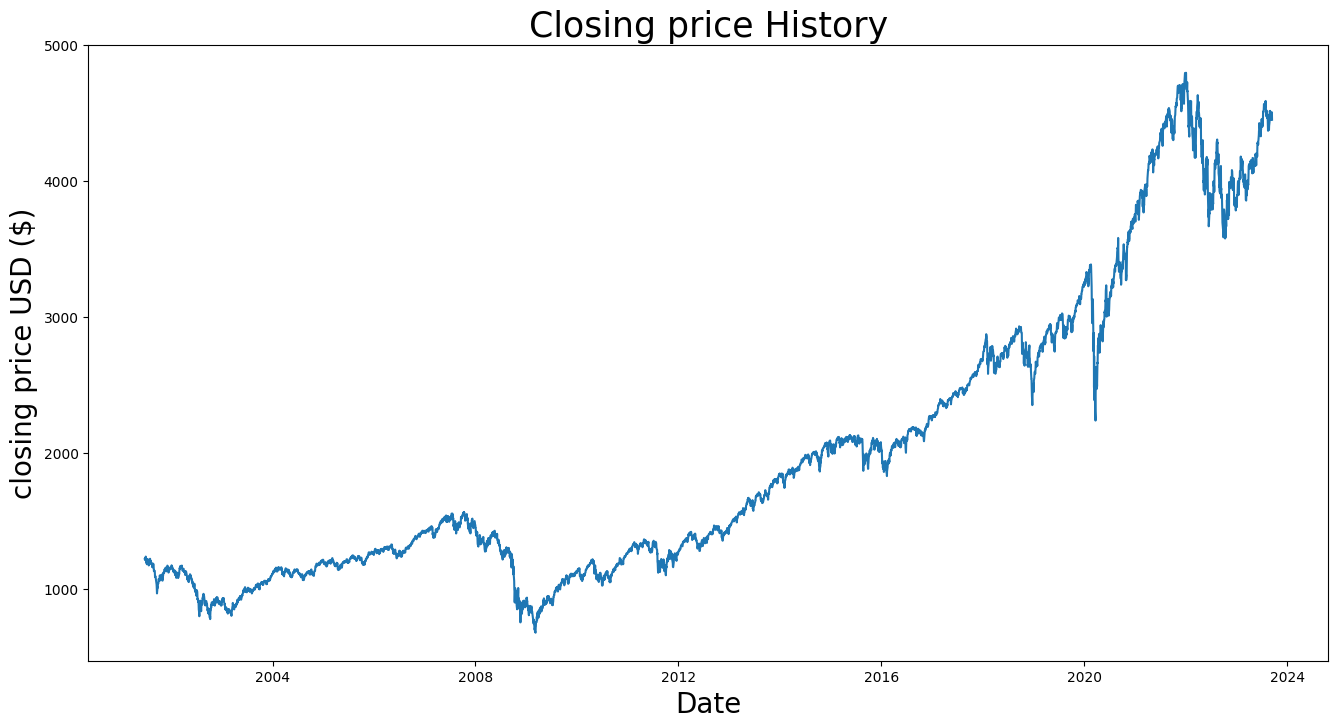

In [5]:
#lets look at the stock closing price of history
plt.figure(figsize=(16,8))
sns.lineplot(x= GSPC_data.index,y=GSPC_data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('closing price USD ($)',fontsize=20)
plt.title('Closing price History',fontsize=25)

In [6]:
# Liste de vos DataFrames et leurs noms
dataframes = [GSPC_data, VIX_data, CL_DF_data, GC_F_data, EURUSD_X_data, GBPUSD_X_data, JPY_X_data, RUB_X_data, NG_F_data, TNX_data, FVX_data, FCHI_data, DJI_data, CNY_X_data, SZ_data, SS_data, MXX_data, BVSP_data, N225_data, HSI_data, STI_data, BSESN_data, TSM_data, ORAPA_data, VZ_data, VODL_data, ADBE_data, AAPL_data, MSFT_data, ORCL_data, IBM_data, INTC_data, QCOM_data, NVDA_data, AMZN_data]
names = ['GSPC', 'VIX', 'CL_DF', 'GC_F', 'EURUSD_X', 'GBPUSD_X', 'JPY_X', 'RUB_X', 'NG_F', 'TNX', 'FVX', 'FCHI', 'DJI', 'CNY_X', 'SZ', 'SS', 'MXX', 'BVSP', 'N225', 'HSI', 'STI', 'BSESN', 'TSM', 'ORAPA', 'VZ', 'VODL', 'ADBE', 'AAPL', 'MSFT', 'ORCL', 'IBM', 'INTC', 'QCOM', 'NVDA', 'AMZN']

# Initialiser un DataFrame vide
combined_data = pd.DataFrame()

# Parcourir chaque DataFrame et ajouter ses colonnes au DataFrame combiné
for df, name in zip(dataframes, names):
    # Sélectionnez seulement les colonnes qui vous intéressent (Open, Close, Min, Max)
    selected_columns = df[['Open', 'Close', 'Low', 'High']]
    
    # Renommez les colonnes pour inclure le nom de l'indice
    selected_columns.columns = pd.MultiIndex.from_product([[name], ['Open', 'Close', 'Low', 'High']])
    
    # Concaténez les colonnes sélectionnées au DataFrame combiné
    if combined_data.empty:
        combined_data = selected_columns
    else:
        combined_data = pd.concat([combined_data, selected_columns], axis=1)

combined_data.dropna(inplace=True)
# Affichez les premières lignes du DataFrame combiné
print(combined_data.shape)

(3670, 140)


### Carte de chaleur de correlation entre les features du modèle:

In [7]:
# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

### Sélection des features

In [8]:
# Sélectionner les caractéristiques avec une forte corrélation
target = ('GSPC', 'Close')
correlation_threshold = 0.5

# Trouver les caractéristiques fortement corrélées
highly_correlated_features = [idx for idx, corr in correlation_matrix[target].items() if abs(corr) > correlation_threshold]

print(f"Selected indices: {highly_correlated_features}")

Selected indices: [('GSPC', 'Open'), ('GSPC', 'Close'), ('GSPC', 'Low'), ('GSPC', 'High'), ('GC_F', 'Open'), ('GC_F', 'Close'), ('GC_F', 'Low'), ('GC_F', 'High'), ('EURUSD_X', 'Open'), ('EURUSD_X', 'Close'), ('EURUSD_X', 'Low'), ('EURUSD_X', 'High'), ('GBPUSD_X', 'Open'), ('GBPUSD_X', 'Close'), ('GBPUSD_X', 'Low'), ('GBPUSD_X', 'High'), ('JPY_X', 'Open'), ('JPY_X', 'Close'), ('JPY_X', 'Low'), ('JPY_X', 'High'), ('RUB_X', 'Open'), ('RUB_X', 'Close'), ('RUB_X', 'Low'), ('RUB_X', 'High'), ('FCHI', 'Open'), ('FCHI', 'Close'), ('FCHI', 'Low'), ('FCHI', 'High'), ('DJI', 'Open'), ('DJI', 'Close'), ('DJI', 'Low'), ('DJI', 'High'), ('MXX', 'Open'), ('MXX', 'Close'), ('MXX', 'Low'), ('MXX', 'High'), ('BVSP', 'Open'), ('BVSP', 'Close'), ('BVSP', 'Low'), ('BVSP', 'High'), ('N225', 'Open'), ('N225', 'Close'), ('N225', 'Low'), ('N225', 'High'), ('BSESN', 'Open'), ('BSESN', 'Close'), ('BSESN', 'Low'), ('BSESN', 'High'), ('TSM', 'Open'), ('TSM', 'Close'), ('TSM', 'Low'), ('TSM', 'High'), ('ORAPA', 'Op

### Gestion de la Multicollinéarité

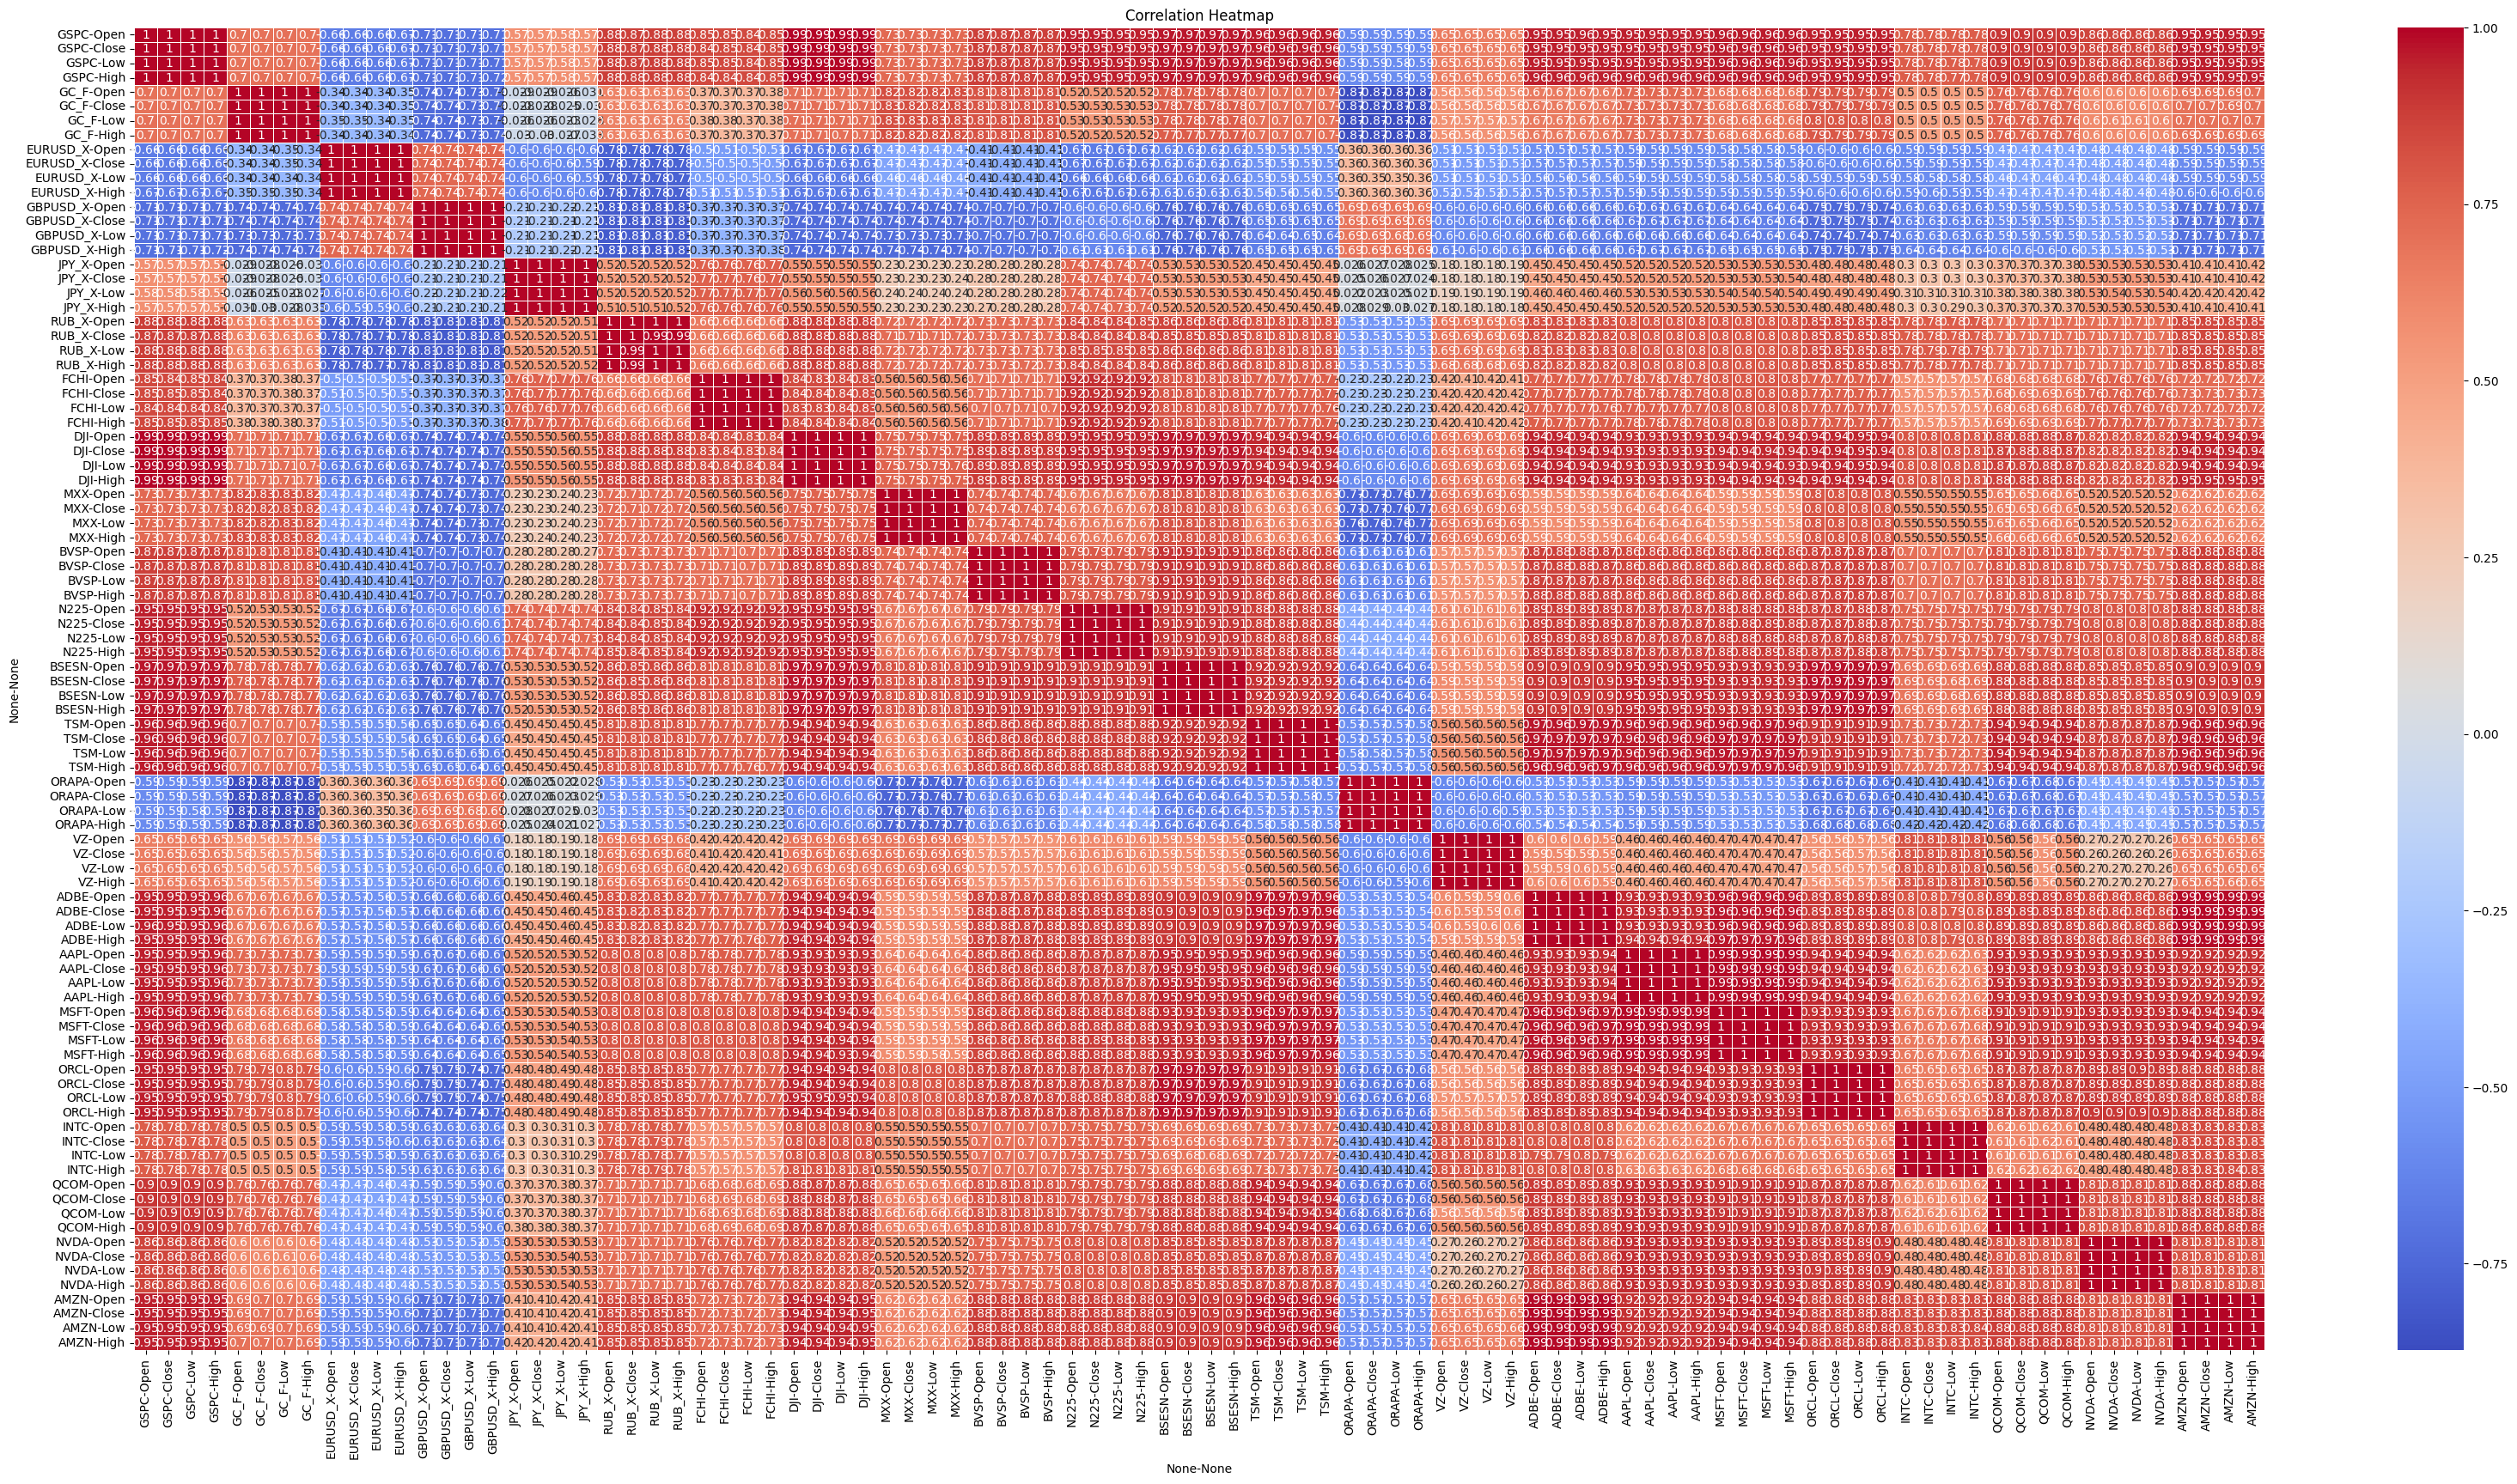

In [9]:
# Afficher la heatmap
selected_correlation_matrix = combined_data[highly_correlated_features].corr()

plt.figure(figsize=(40, 20))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Calculate VIF
def calculate_vif(dataframe, threshold=5.0):
    vif = pd.DataFrame()
    vif["Variable"] = [str(col) for col in dataframe.columns]
    vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    while vif["VIF"].max() > threshold:
        remove = vif.sort_values("VIF", ascending=False).iloc[0]
        removed_var = dataframe.columns[int(remove.name)]
        dataframe = dataframe.drop(removed_var, axis=1)
        vif = pd.DataFrame()
        vif["Variable"] = [str(col) for col in dataframe.columns]
        vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    return dataframe

### Sélection des features définitives:

In [11]:
#highly_correlated_features.remove(target)
filtred_df = combined_data[highly_correlated_features].copy()
# Extraire les valeurs de clôture pour chaque indice
close_values_df = combined_data.xs('Close', level=1, axis=1)

# Calculer le VIF sur ces valeurs
reduced_df = calculate_vif(close_values_df)

# Conserver seulement les indices qui ne sont pas colinéaires
valid_indices = reduced_df.columns.tolist()

# Créer un nouveau DataFrame contenant toutes les variables pour ces indices
final_df = combined_data.loc[:, pd.IndexSlice[valid_indices, :]]
print(final_df.shape)

(3670, 12)


### Normalisation des données

In [12]:
# Initialisez un dictionnaire pour stocker les scalers
scalers_dict = {}

# Créez un DataFrame vide pour stocker les données mises à l'échelle
scaled_data_df = pd.DataFrame(index=final_df.index)

# Itérer sur le premier niveau de l'index multi-niveaux (noms des indices)
for first_level in final_df.columns.levels[0]:
    # Itérer sur le second niveau de l'index multi-niveaux (Open, Close, High, Low)
    for second_level in final_df.columns.levels[1]:
        feature = (first_level, second_level)
        
        if feature in final_df.columns:
            feature_scaler = RobustScaler()
            scaled_feature = feature_scaler.fit_transform(final_df[feature].values.reshape(-1, 1))
            scaled_data_df[feature] = scaled_feature.flatten()  # Convertir les données 2D en 1D
            
            # Stocker le scaler pour chaque combinaison d'indice et de mesure
            scalers_dict[feature] = feature_scaler

print(scaled_data_df.head())

            (FVX, Close)  (FVX, High)  (FVX, Low)  (FVX, Open)  (NVDA, Close)  \
Date                                                                            
2003-12-01      0.841816     0.851580    0.842105     0.809777      -0.076715   
2003-12-02      0.826410     0.842320    0.853801     0.831626      -0.076877   
2003-12-03      0.841816     0.824891    0.837093     0.831626      -0.077271   
2003-12-04      0.814856     0.830338    0.840991     0.851291      -0.077468   
2003-12-05      0.710867     0.729031    0.726817     0.720743      -0.078688   

            (NVDA, High)  (NVDA, Low)  (NVDA, Open)  (VIX, Close)  \
Date                                                                
2003-12-01     -0.077247    -0.077114     -0.077205      0.004535   
2003-12-02     -0.076915    -0.076950     -0.077330     -0.052154   
2003-12-03     -0.076354    -0.077206     -0.077151     -0.011338   
2003-12-04     -0.077283    -0.078229     -0.077527     -0.048753   
2003-12-05     -0.

In [13]:
# Split into train and test:
# Définissez la taille de l'ensemble d'entraînement
train_size = int(len(scaled_data_df)) - 200
test_size = 200

# Séparez les données
train_data = scaled_data_df.iloc[:train_size]
test_data = scaled_data_df.iloc[train_size:]
print(train_data.shape)
print(test_data.shape)

(3470, 12)
(200, 12)


In [14]:
#Now, we can save the 2 csv files, Train and Test.
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

### Création d'une métrique personalisée pour la prédiction récursive 

In [15]:
def weighted_rmse(y_true, y_pred, total_observations):
    weights = np.arange(total_observations, 0, -1) / total_observations
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse
    
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse

#création d'un test pour éviter les modèles à prédictions récursives stationnaires
def adf_test(series):
    if np.all(series == series[0]):  # Vérifie si tous les éléments sont identiques
        return False  # Vous pouvez considérer que c'est non-stationnaire ou inapproprié pour vos besoins
    result = adfuller(series)
    return result[1] <= 0.10

# Recherche de la meilleure architecture pour les modèles neuronaux

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
best_params_per_feature = {}
top_n_trials_per_feature = {}

# Function to create sequences for multi-output prediction

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def generate_recursive_predictions(model, X_val, n_steps=10):
    # Supposons que X_val soit de forme (nombre_d'exemples, look_back, nombre_de_features)
    recursive_predictions = []
    input_sequence = X_val[0].reshape(1, X_val.shape[1], X_val.shape[2])  # Prendre la première séquence

    for i in range(n_steps):
        # Faire une prédiction à partir de la séquence d'entrée
        prediction = model.predict(input_sequence, verbose=0)
        recursive_predictions.append(prediction[0, 0])

        # Mettre à jour la séquence d'entrée pour inclure la nouvelle prédiction
        new_input_sequence = np.append(input_sequence[0, 1:, :], prediction)
        input_sequence = new_input_sequence.reshape(1, X_val.shape[1], X_val.shape[2])

    return np.array(recursive_predictions)


def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice

    # Définition de l'objectif
    def objective(trial):

        # Espace de recherche
        ###############################################################################################
        look_back = trial.suggest_int('look_back', int(test_size/4), int(test_size/2) - 1)
        num_layers = trial.suggest_int('num_layers', 5, 8)
        layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
        units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
        units_per_layer = [2 ** power for power in units_per_layer]
        dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
        use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
        attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
        use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
        if use_conv1d:
            conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
            conv1d_filters = 2 ** conv1d_filters
            conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
        l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
        ################################################################################################

        # Créez des séquences en utilisant look_back
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        n_splits = 5  # Nombre de splits
        tscv = TimeSeriesSplit(n_splits=n_splits)

        val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        mda_list = []  # Liste pour stocker MDA de chaque split
        train_loss_list = []  # Liste pour stocker la loss de chaque split

        for train_index, val_index in tscv.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            if use_conv1d:
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
            else:
                conv1d_filters = 36
                conv1d_kernel_size = 5
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, batch_size=64, verbose=0, callbacks=[early_stopping])

            last_val_loss = history.history['val_loss'][-1]
            last_train_loss = history.history['loss'][-1]
            
            # Calcul de MDA
            y_true_direction = np.sign(np.diff(y_val_fold.reshape(-1)))  # vrai direction
            y_pred_direction = np.sign(np.diff(model.predict(X_val_fold, verbose=0).reshape(-1)))  # prédiction de direction
            mda = np.mean(y_true_direction == y_pred_direction)
            
            val_loss_list.append(last_val_loss)
            train_loss_list.append(last_train_loss)
            mda_list.append(mda)
        
        mean_val_loss = np.mean(val_loss_list)
        mean_train_loss = np.mean(train_loss_list)
        mean_mda = np.mean(mda_list)
        
        
        # Calcul des malus
        loss_difference_malus = abs(mean_val_loss - mean_train_loss) * 1
        recursive_predictions = generate_recursive_predictions(model, X_val_fold, len(X_val_fold))
        if np.all(recursive_predictions == recursive_predictions[0]):
            adf_malus = 4
        else:
            adf_result = adfuller(recursive_predictions)
            adf_malus = (1 - adf_result[1]) * 3

        # Calcul du score final avec les malus
        final_score = (1-mean_mda) + loss_difference_malus + adf_malus
        
        print("mda: " + str(mean_mda))
        print("loss diff: " + str(loss_difference_malus))
        print("adf: " + str(adf_malus))

        return final_score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=35)
    
    best_params_per_feature[index_name] = study.best_params

    top_n_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

    # Stockez les meilleurs hyperparamètres
    top_n_params = [trial.params for trial in top_n_trials]

    # Stockez ces meilleurs paramètres dans le dictionnaire
    top_n_trials_per_feature[index_name] = top_n_params

    # Affichage des résultats
    print(f'Number of finished trials for {index_name}: ', len(study.trials))
    print('Best 5 trials:')
    for i, trial in enumerate(top_n_trials):
        print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-09-19 19:33:41,232] A new study created in memory with name: no-name-fa073f1e-bb42-4620-b1de-7aa61d16a1a3
[I 2023-09-19 19:40:22,629] Trial 0 finished with value: 3.9983239257453804 and parameters: {'look_back': 73, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.2742391952639728, 'dropout_1': 0.16192770557810413, 'dropout_2': 0.18621456755794094, 'dropout_3': 0.29681654984728534, 'dropout_4': 0.10634338955235481, 'dropout_5': 0.25769617675943046, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0028256959896296023, 'l2_reg': 0.0011122225018936848}. Best is trial 0 with value: 3.9983239257453804.


mda: 0.44920353982300887
loss diff: 0.447538709640503
adf: 2.999988755927886


[I 2023-09-19 19:49:21,730] Trial 1 finished with value: 4.160005318683377 and parameters: {'look_back': 83, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.11023584632272261, 'dropout_1': 0.10827346236749857, 'dropout_2': 0.11172846873653478, 'dropout_3': 0.1797804223475677, 'dropout_4': 0.264750384704273, 'dropout_5': 0.25845173568315455, 'dropout_6': 0.2462681494234616, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 1.3388696135283352e-05, 'l2_reg': 2.054445968142675e-05}. Best is trial 0 with value: 3.9983239257453804.


mda: 0.4792184724689165
loss diff: 0.6392238020896912
adf: 2.999999989062603


[I 2023-09-19 20:00:41,557] Trial 2 finished with value: 7.249234310729765 and parameters: {'look_back': 63, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.29341026065989173, 'dropout_1': 0.21903684743439697, 'dropout_2': 0.2585900992301793, 'dropout_3': 0.26310299175753393, 'dropout_4': 0.1431139488936531, 'dropout_5': 0.19483212057703547, 'dropout_6': 0.24723344547621143, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.09360126546063399, 'l2_reg': 0.00014669900055840169}. Best is trial 0 with value: 3.9983239257453804.


mda: 0.4734982332155477
loss diff: 3.7227325439453125
adf: 3.0


[I 2023-09-19 20:11:22,626] Trial 3 finished with value: 5.6650814092139345 and parameters: {'look_back': 70, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.18937886279754343, 'dropout_1': 0.19174679309415305, 'dropout_2': 0.10405184261392111, 'dropout_3': 0.15064143312748562, 'dropout_4': 0.23380579033378593, 'dropout_5': 0.14054554231907182, 'dropout_6': 0.2669019303235405, 'dropout_7': 0.149746139248584, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.042285707372930276, 'l2_reg': 3.6968095026520265e-05}. Best is trial 0 with value: 3.9983239257453804.


mda: 0.48991150442477877
loss diff: 2.156017303466797
adf: 2.998975610171916


[I 2023-09-19 20:17:08,018] Trial 4 finished with value: 3.6278491946670597 and parameters: {'look_back': 78, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.2105389543673279, 'dropout_1': 0.2012282083776957, 'dropout_2': 0.13016915316704397, 'dropout_3': 0.2919138056833085, 'dropout_4': 0.17091147998373282, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 6.69762846323875e-05, 'l2_reg': 3.973004978484407e-05}. Best is trial 4 with value: 3.6278491946670597.


mda: 0.47269503546099295
loss diff: 0.10365369319915807
adf: 2.9968905369288947


[I 2023-09-19 20:22:08,491] Trial 5 finished with value: 7.583276018068565 and parameters: {'look_back': 63, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.15182947307307737, 'dropout_1': 0.22557936737728915, 'dropout_2': 0.285234292751545, 'dropout_3': 0.2202702908452584, 'dropout_4': 0.1839751120908602, 'dropout_5': 0.2710916392919973, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.05008791803334217, 'l2_reg': 0.0035515974916907143}. Best is trial 4 with value: 3.6278491946670597.


mda: 0.4650176678445229
loss diff: 3.0482936859130874
adf: 4


[I 2023-09-19 20:27:26,225] Trial 6 finished with value: 5.4561238076577325 and parameters: {'look_back': 64, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.1768299302273048, 'dropout_1': 0.2970556494723552, 'dropout_2': 0.27043322432749795, 'dropout_3': 0.21925061104249327, 'dropout_4': 0.14524843816633623, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.04353861909317105, 'l2_reg': 0.00018400917796107766}. Best is trial 4 with value: 3.6278491946670597.


mda: 0.48233215547703184
loss diff: 0.9384559631347642
adf: 4


[I 2023-09-19 20:34:41,566] Trial 7 finished with value: 3.5649129791203826 and parameters: {'look_back': 68, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.18463330308378517, 'dropout_1': 0.20690909920140474, 'dropout_2': 0.20499186405469033, 'dropout_3': 0.2874634546312089, 'dropout_4': 0.22712023527988492, 'dropout_5': 0.23267188774110364, 'dropout_6': 0.2223202778495151, 'dropout_7': 0.11566881963203018, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.011241309778587881, 'l2_reg': 0.030748360671386858}. Best is trial 7 with value: 3.5649129791203826.


mda: 0.4597173144876325
loss diff: 0.043999481201172586
adf: 2.980630812406843


[I 2023-09-19 20:43:12,876] Trial 8 finished with value: 4.224585653261859 and parameters: {'look_back': 85, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.22595453469412777, 'dropout_1': 0.1626785955850091, 'dropout_2': 0.18471215463151555, 'dropout_3': 0.13233577596054016, 'dropout_4': 0.17728553663603422, 'dropout_5': 0.2980955837378174, 'dropout_6': 0.11279561729618162, 'dropout_7': 0.17614692328100845, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0005035865567134262, 'l2_reg': 0.001653278964631191}. Best is trial 7 with value: 3.5649129791203826.


mda: 0.4685612788632326
loss diff: 0.6931469321250918
adf: 3.0


[I 2023-09-19 20:49:49,621] Trial 9 finished with value: 3.64405320848979 and parameters: {'look_back': 76, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.12970459398904005, 'dropout_1': 0.21748323200000286, 'dropout_2': 0.28413918438504887, 'dropout_3': 0.1366922163232787, 'dropout_4': 0.22985681761827054, 'dropout_5': 0.1458923343496848, 'dropout_6': 0.1943521356947999, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 5.396115267879675e-05, 'l2_reg': 0.00022148036518857545}. Best is trial 7 with value: 3.5649129791203826.


mda: 0.4695035460992908
loss diff: 0.11355675458908077
adf: 3.0


[I 2023-09-19 20:59:35,543] Trial 10 finished with value: 3.772243635957622 and parameters: {'look_back': 99, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.23997368819056808, 'dropout_1': 0.25721845932947096, 'dropout_2': 0.22601493012087434, 'dropout_3': 0.24588123352969576, 'dropout_4': 0.2983451600325425, 'dropout_5': 0.2102310480122012, 'dropout_6': 0.1843334653047793, 'dropout_7': 0.10059483883387184, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.008132864935555699, 'l2_reg': 0.08504586871626289}. Best is trial 7 with value: 3.5649129791203826.


mda: 0.4767857142857143
loss diff: 0.249029350280761
adf: 2.9999999999625753


[I 2023-09-19 21:04:58,386] Trial 11 finished with value: 0.8610169780086461 and parameters: {'look_back': 51, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.21851618024715255, 'dropout_1': 0.18839691889951393, 'dropout_2': 0.15139988715294092, 'dropout_3': 0.2996378178274846, 'dropout_4': 0.2119317963336705, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0005007955679796888, 'l2_reg': 1.088531024722329e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4669014084507042
loss diff: 0.32791838645935023
adf: 0.0


[I 2023-09-19 21:10:30,426] Trial 12 finished with value: 4.304479989871172 and parameters: {'look_back': 52, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.17780373098419927, 'dropout_1': 0.1664966247362877, 'dropout_2': 0.16112717774776586, 'dropout_3': 0.26800483623868065, 'dropout_4': 0.2120549020625523, 'dropout_5': 0.10700297825726268, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0007257479349150387, 'l2_reg': 0.012862588052923205}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4352112676056338
loss diff: 0.7396912574768066
adf: 2.999999999999999


[I 2023-09-19 21:15:50,958] Trial 13 finished with value: 3.935541778242172 and parameters: {'look_back': 50, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.24672646614481972, 'dropout_1': 0.24973830960983814, 'dropout_2': 0.2147759426191118, 'dropout_3': 0.29883979154109097, 'dropout_4': 0.22221656114291477, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.006458361832815635, 'l2_reg': 1.0729793111582838e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4695957820738137
loss diff: 0.40513820648193466
adf: 2.9999993538340513


[I 2023-09-19 21:22:30,932] Trial 14 finished with value: 4.0845100181203495 and parameters: {'look_back': 56, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.20883205001823324, 'dropout_1': 0.18628501688472235, 'dropout_2': 0.1543692206990088, 'dropout_3': 0.26417933054776, 'dropout_4': 0.24856698664442384, 'dropout_5': 0.216722721408514, 'dropout_6': 0.2877050432210465, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0015909441390196937, 'l2_reg': 0.011623562092354768}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4598591549295775
loss diff: 0.5443691730499269
adf: 3.0


[I 2023-09-19 21:28:45,673] Trial 15 finished with value: 4.452788869287601 and parameters: {'look_back': 58, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.15491475005257216, 'dropout_1': 0.1387044154129038, 'dropout_2': 0.23670246144223805, 'dropout_3': 0.10613142100855404, 'dropout_4': 0.20121718931129523, 'dropout_5': 0.23044105725564074, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00030163250531087846, 'l2_reg': 0.08681562509587874}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4708994708994709
loss diff: 0.9236883401870717
adf: 3.0


[I 2023-09-19 21:38:44,485] Trial 16 finished with value: 3.5994319317548054 and parameters: {'look_back': 89, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.19811893590837795, 'dropout_1': 0.13912124596772493, 'dropout_2': 0.20173993391431702, 'dropout_3': 0.24565457975221794, 'dropout_4': 0.2584090658131247, 'dropout_5': 0.18179083991466746, 'dropout_6': 0.22277438676254818, 'dropout_7': 0.27665459587287144, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.012011041451347938, 'l2_reg': 0.0005849186288097958}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.46939501779359427
loss diff: 0.06882934570312571
adf: 2.999997603845274


[I 2023-09-19 21:43:35,090] Trial 17 finished with value: 4.270908634819695 and parameters: {'look_back': 67, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'dropout_0': 0.22225282349401898, 'dropout_1': 0.19222640836566487, 'dropout_2': 0.16076301413632368, 'dropout_3': 0.2804717345088423, 'dropout_4': 0.20280314146435305, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0026749739479912994, 'l2_reg': 7.336210780403076e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4738515901060071
loss diff: 0.7447636485099793
adf: 2.9999965764157226


[I 2023-09-19 21:49:59,773] Trial 18 finished with value: 3.727967511095868 and parameters: {'look_back': 55, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.25731047754581016, 'dropout_1': 0.2358942278792951, 'dropout_2': 0.24659310491424924, 'dropout_3': 0.27578476438323923, 'dropout_4': 0.24411556048423702, 'dropout_5': 0.2358173836640551, 'dropout_6': 0.2971617822171905, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.0002679149539837311, 'l2_reg': 0.00045644025257555933}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4711267605633803
loss diff: 0.19909427165985116
adf: 2.999999999999397


[I 2023-09-19 21:55:36,993] Trial 19 finished with value: 3.93158065671433 and parameters: {'look_back': 60, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.22757183340500237, 'dropout_1': 0.2643179916110718, 'dropout_2': 0.21470922040891408, 'dropout_3': 0.2986468739925251, 'dropout_4': 0.2188410591393861, 'dropout_5': 0.18475917570367303, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0014299142963181933, 'l2_reg': 1.076539453612315e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.47865961199294527
loss diff: 0.41024026870727504
adf: 3.0


[I 2023-09-19 22:02:17,044] Trial 20 finished with value: 3.6878097208247063 and parameters: {'look_back': 94, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.1707821877959947, 'dropout_1': 0.20581676673178892, 'dropout_2': 0.18350674401347133, 'dropout_3': 0.24889639333270425, 'dropout_4': 0.27220155413319774, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.020519333087624467, 'l2_reg': 0.0029574315021593544}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.46951871657754013
loss diff: 0.21260337829589915
adf: 2.9447250591063474


[I 2023-09-19 22:12:44,853] Trial 21 finished with value: 4.011704577245746 and parameters: {'look_back': 89, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.19562668158845145, 'dropout_1': 0.13117093975726998, 'dropout_2': 0.19958740784541468, 'dropout_3': 0.24057698143867126, 'dropout_4': 0.24961626655513125, 'dropout_5': 0.18720886854028046, 'dropout_6': 0.2204448263988313, 'dropout_7': 0.2918787343815721, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.006129014725812876, 'l2_reg': 0.0003217688822810533}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4718861209964412
loss diff: 0.48359069824218714
adf: 3.0


[I 2023-09-19 22:22:43,191] Trial 22 finished with value: 5.206176396705924 and parameters: {'look_back': 90, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.19870552621340798, 'dropout_1': 0.1809804036862313, 'dropout_2': 0.20338581436173125, 'dropout_3': 0.28137380097170883, 'dropout_4': 0.2656109818940027, 'dropout_5': 0.16853398884251378, 'dropout_6': 0.20846771998370608, 'dropout_7': 0.2537944266167515, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.016162541402749853, 'l2_reg': 0.00051861154180317}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.47259786476868326
loss diff: 0.678774261474608
adf: 4


[I 2023-09-19 22:32:30,664] Trial 23 finished with value: 3.622810516221909 and parameters: {'look_back': 81, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.21101118994487778, 'dropout_1': 0.14119444701395842, 'dropout_2': 0.23174651440562685, 'dropout_3': 0.25834977181906077, 'dropout_4': 0.2276110188679683, 'dropout_5': 0.22352159667608487, 'dropout_6': 0.1705455425145488, 'dropout_7': 0.2349782416914884, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.013137170684465745, 'l2_reg': 7.652066783386063e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4660746003552398
loss diff: 0.08888511657714915
adf: 3.0


[I 2023-09-19 22:40:15,181] Trial 24 finished with value: 4.123532476582385 and parameters: {'look_back': 71, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.19191189999312433, 'dropout_1': 0.17348023070868027, 'dropout_2': 0.1720156422278872, 'dropout_3': 0.27788195108850094, 'dropout_4': 0.20829789531847123, 'dropout_5': 0.20249925775695077, 'dropout_6': 0.23027882537358113, 'dropout_7': 0.21582671771358405, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0036055977946772805, 'l2_reg': 0.0006640388486819485}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4467256637168141
loss diff: 0.5702581405639648
adf: 2.999999999735234


[I 2023-09-19 22:49:28,535] Trial 25 finished with value: 3.9481353664568175 and parameters: {'look_back': 98, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.1626411083485664, 'dropout_1': 0.15421392523671446, 'dropout_2': 0.14506382936760812, 'dropout_3': 0.23059956429488487, 'dropout_4': 0.23929178499381096, 'dropout_5': 0.1712731023465617, 'dropout_6': 0.16458848663581951, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.022370441019883787, 'l2_reg': 0.0007778918077326749}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4688057040998218
loss diff: 0.4169410705566392
adf: 3.0


[I 2023-09-19 22:59:27,234] Trial 26 finished with value: 3.75548476376323 and parameters: {'look_back': 87, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.185753979139061, 'dropout_1': 0.1757382012358463, 'dropout_2': 0.1990701051735286, 'dropout_3': 0.2538450039761594, 'dropout_4': 0.1920698244693606, 'dropout_5': 0.23876792451036224, 'dropout_6': 0.22350940381617007, 'dropout_7': 0.2860796542462556, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.0010316227942250304, 'l2_reg': 0.00010249948200551815}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.45088967971530247
loss diff: 0.2500682353973387
adf: 2.9563062080811937


[I 2023-09-19 23:06:41,552] Trial 27 finished with value: 4.192812905413039 and parameters: {'look_back': 80, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.2027311353151138, 'dropout_1': 0.2053775574597022, 'dropout_2': 0.13524087808596003, 'dropout_3': 0.28369600337210354, 'dropout_4': 0.2796789833066302, 'dropout_5': 0.2091408243587726, 'dropout_6': 0.25377535206906915, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.004003776781945213, 'l2_reg': 0.00018643526144547913}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.46914893617021275
loss diff: 0.6619618415832518
adf: 3.0


[I 2023-09-19 23:14:30,907] Trial 28 finished with value: 3.4033943828594406 and parameters: {'look_back': 68, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.21919641078112936, 'dropout_1': 0.10312800901182437, 'dropout_2': 0.1791606002963175, 'dropout_3': 0.2676991200237881, 'dropout_4': 0.2596522613745896, 'dropout_5': 0.24583033096706458, 'dropout_6': 0.20546106057284966, 'dropout_7': 0.19036879090179087, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.010099240641883556, 'l2_reg': 0.00031102188582462955}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4339222614840989
loss diff: 0.14837112426757848
adf: 2.6889455200759613


[I 2023-09-19 23:20:53,079] Trial 29 finished with value: 3.5473296008248925 and parameters: {'look_back': 74, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.2623598671205617, 'dropout_1': 0.10694815346795174, 'dropout_2': 0.18016183888514542, 'dropout_3': 0.29102413891555323, 'dropout_4': 0.2186440752194077, 'dropout_5': 0.2474505825585269, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0021582318131873005, 'l2_reg': 4.221702406040643e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4665486725663717
loss diff: 0.013886499404907937
adf: 2.999991773986356


[I 2023-09-19 23:28:00,371] Trial 30 finished with value: 3.899607172595136 and parameters: {'look_back': 74, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.26857147472980825, 'dropout_1': 0.1049943931141367, 'dropout_2': 0.1815558514150705, 'dropout_3': 0.29732915644879593, 'dropout_4': 0.21537735981993755, 'dropout_5': 0.28131983459069676, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0021970919371466025, 'l2_reg': 2.2708482693060015e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.47221238938053095
loss diff: 0.3718198776245121
adf: 2.999999684351155


[I 2023-09-19 23:34:26,590] Trial 31 finished with value: 4.110170668477803 and parameters: {'look_back': 68, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.23634085150241016, 'dropout_1': 0.1185873956349881, 'dropout_2': 0.16247770514521467, 'dropout_3': 0.28689226906000065, 'dropout_4': 0.2329699117785707, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0043833108035030155, 'l2_reg': 4.906019396922714e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.4042402826855124
loss diff: 0.5554688453674315
adf: 2.958942105795884


[I 2023-09-19 23:40:58,663] Trial 32 finished with value: 3.5775896169308714 and parameters: {'look_back': 74, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.2529438875786734, 'dropout_1': 0.1021123156189242, 'dropout_2': 0.17160839473016948, 'dropout_3': 0.269830314094404, 'dropout_4': 0.24960913233203494, 'dropout_5': 0.2474043528083724, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0026414016634092458, 'l2_reg': 2.2344787801507445e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.448141592920354
loss diff: 0.04207022190093923
adf: 2.983660987950286


[I 2023-09-19 23:47:29,595] Trial 33 finished with value: 4.988952716921748 and parameters: {'look_back': 67, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.27625684368661274, 'dropout_1': 0.11446822051873559, 'dropout_2': 0.1718782654110764, 'dropout_3': 0.2999924211875072, 'dropout_4': 0.2258973355338042, 'dropout_5': 0.24926197520792853, 'dropout_6': 0.20024817702944928, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.009759780983173495, 'l2_reg': 6.855335625864661e-05}. Best is trial 11 with value: 0.8610169780086461.


mda: 0.04452296819787986
loss diff: 0.03347568511962784
adf: 4


[I 2023-09-19 23:53:15,701] Trial 34 finished with value: 4.888159085497444 and parameters: {'look_back': 61, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.21883489972648368, 'dropout_1': 0.11827325604369023, 'dropout_2': 0.19313816081201154, 'dropout_3': 0.2667339567335862, 'dropout_4': 0.19356356353041598, 'dropout_5': 0.23068921647985738, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.005604280464971422, 'l2_reg': 0.00013746551497489858}. Best is trial 11 with value: 0.8610169780086461.
[I 2023-09-19 23:53:15,715] A new study created in memory with name: no-name-91007240-a2f4-4647-9ed8-1d564e8d281b


mda: 0.35802469135802467
loss diff: 0.24618377685546822
adf: 4
Number of finished trials for VIX:  35
Best 5 trials:
Rank 1 - Value: 0.8610169780086461, Params: {'look_back': 51, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.21851618024715255, 'dropout_1': 0.18839691889951393, 'dropout_2': 0.15139988715294092, 'dropout_3': 0.2996378178274846, 'dropout_4': 0.2119317963336705, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0005007955679796888, 'l2_reg': 1.088531024722329e-05}
Rank 2 - Value: 3.4033943828594406, Params: {'look_back': 68, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'u

[I 2023-09-20 00:00:41,488] Trial 0 finished with value: 3.6174057589450355 and parameters: {'look_back': 56, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.22690384835540667, 'dropout_1': 0.29016874297914347, 'dropout_2': 0.1628387934188273, 'dropout_3': 0.2815973759807632, 'dropout_4': 0.28268072110688824, 'dropout_5': 0.1572013239442896, 'dropout_6': 0.1453509745000236, 'dropout_7': 0.25050536243199695, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.2429863832765173e-05, 'l2_reg': 0.00035289942927950273}. Best is trial 0 with value: 3.6174057589450355.


mda: 0.477112676056338
loss diff: 0.09451843500137347
adf: 3.0


[I 2023-09-20 00:07:55,788] Trial 1 finished with value: 5.649313895882655 and parameters: {'look_back': 74, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.19469239935790128, 'dropout_1': 0.12720757481527903, 'dropout_2': 0.17272140051784357, 'dropout_3': 0.15884553796526002, 'dropout_4': 0.2135055536993793, 'dropout_5': 0.137980358144762, 'dropout_6': 0.27747370141651323, 'dropout_7': 0.28144691307974345, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0059385846295375725, 'l2_reg': 5.720485977694558e-05}. Best is trial 0 with value: 3.6174057589450355.


mda: 0.49805309734513276
loss diff: 2.1473700046539292
adf: 2.9999969885738587


[I 2023-09-20 00:15:48,663] Trial 2 finished with value: 3.983624716631462 and parameters: {'look_back': 81, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.1505262185810357, 'dropout_1': 0.28057073139751143, 'dropout_2': 0.2927523356218317, 'dropout_3': 0.19093960811840444, 'dropout_4': 0.24748812146138768, 'dropout_5': 0.1456522408556153, 'dropout_6': 0.13295509742500194, 'dropout_7': 0.11482666819046106, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0005515229587144053, 'l2_reg': 0.002490530900194928}. Best is trial 0 with value: 3.6174057589450355.


mda: 0.49342806394316163
loss diff: 0.4770529985427858
adf: 2.999999782031838


[I 2023-09-20 00:21:52,911] Trial 3 finished with value: 3.8975734784312905 and parameters: {'look_back': 53, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.22828335891749477, 'dropout_1': 0.14966902852388123, 'dropout_2': 0.21941638288700857, 'dropout_3': 0.19879122203297422, 'dropout_4': 0.2838833820655544, 'dropout_5': 0.2615004009920679, 'dropout_6': 0.16835101396418556, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0011200490166128022, 'l2_reg': 2.2451559615104865e-05}. Best is trial 0 with value: 3.6174057589450355.


mda: 0.4883802816901408
loss diff: 0.38595376014709437
adf: 2.999999999974337


[I 2023-09-20 00:29:39,073] Trial 4 finished with value: 0.6062246730359505 and parameters: {'look_back': 96, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.274025333184188, 'dropout_1': 0.22263317283223893, 'dropout_2': 0.12739324735612922, 'dropout_3': 0.1751004836973755, 'dropout_4': 0.14799881064330148, 'dropout_5': 0.12495124204072493, 'dropout_6': 0.28141535103556214, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.8451194147278945e-05, 'l2_reg': 0.0006043349400708659}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4834224598930481
loss diff: 0.050119853019714444
adf: 0.039527279909284174


[I 2023-09-20 00:35:11,043] Trial 5 finished with value: 3.9656923671810493 and parameters: {'look_back': 86, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.17193922707324322, 'dropout_1': 0.23877922850417557, 'dropout_2': 0.27934774198583423, 'dropout_3': 0.10287433882615156, 'dropout_4': 0.16880701289294234, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.006382440532936508, 'l2_reg': 0.0001523513278481437}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48170515097690947
loss diff: 0.4473975181579588
adf: 3.0


[I 2023-09-20 00:43:43,676] Trial 6 finished with value: 5.805894156622299 and parameters: {'look_back': 90, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.10445439289740027, 'dropout_1': 0.14180749673388765, 'dropout_2': 0.2596219570333821, 'dropout_3': 0.13806878696210598, 'dropout_4': 0.1730106140087045, 'dropout_5': 0.11599934084130786, 'dropout_6': 0.18143510650974934, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.02454394118937139, 'l2_reg': 0.00023066305527822146}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4419928825622776
loss diff: 1.247887039184576
adf: 4


[I 2023-09-20 00:52:28,152] Trial 7 finished with value: 7.673304854235465 and parameters: {'look_back': 83, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.26947139217520333, 'dropout_1': 0.22299277898751177, 'dropout_2': 0.16488051626011746, 'dropout_3': 0.253013220123695, 'dropout_4': 0.14054787807218502, 'dropout_5': 0.13860933754937482, 'dropout_6': 0.2962987731711408, 'dropout_7': 0.26184034010219626, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.05215852249149615, 'l2_reg': 0.0006191574219843739}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.06181172291296625
loss diff: 2.735116577148432
adf: 4


[I 2023-09-20 00:57:46,385] Trial 8 finished with value: 6.092350157797498 and parameters: {'look_back': 77, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.22018969587993736, 'dropout_1': 0.253850647862523, 'dropout_2': 0.14833973911319626, 'dropout_3': 0.21794813557681808, 'dropout_4': 0.20998851378229155, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.07361171694169892, 'l2_reg': 0.0018337547946800127}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48049645390070933
loss diff: 3.072978973388672
adf: 2.499867638309536


[I 2023-09-20 01:03:29,457] Trial 9 finished with value: 4.447469398611998 and parameters: {'look_back': 63, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.2824319608744814, 'dropout_1': 0.16246347827349725, 'dropout_2': 0.17185287602341412, 'dropout_3': 0.16546527562543453, 'dropout_4': 0.23981889188211636, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.030399220649326777, 'l2_reg': 0.002850058981483967}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4809187279151944
loss diff: 0.928865814208983
adf: 2.9995223123182098


[I 2023-09-20 01:10:09,018] Trial 10 finished with value: 3.7113059059956246 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.2992585977116924, 'dropout_1': 0.19709382275851697, 'dropout_2': 0.1098025699161412, 'dropout_3': 0.22801806240091105, 'dropout_4': 0.1033793049039193, 'dropout_5': 0.19953686882563068, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 1.0059335964865435e-05, 'l2_reg': 0.02989711068944123}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.47928571428571426
loss diff: 0.1905916202813387
adf: 3.0


[I 2023-09-20 01:16:21,337] Trial 11 finished with value: 3.5536505325208845 and parameters: {'look_back': 50, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.25192911368437837, 'dropout_1': 0.29727883392451593, 'dropout_2': 0.10289975506326356, 'dropout_3': 0.29033666706463124, 'dropout_4': 0.2885000034802767, 'dropout_5': 0.18156612713433634, 'dropout_6': 0.10024144735441787, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.2651924607251354e-05, 'l2_reg': 1.2076744517328186e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.47978910369068545
loss diff: 0.03343963623046875
adf: 2.999999999981101


[I 2023-09-20 01:23:13,454] Trial 12 finished with value: 3.641943570749325 and parameters: {'look_back': 67, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2593707894308343, 'dropout_1': 0.29556553397843416, 'dropout_2': 0.10099307472598033, 'dropout_3': 0.296406234973178, 'dropout_4': 0.2969310497785238, 'dropout_5': 0.19203320355545267, 'dropout_6': 0.10687748047886851, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 5.907821289304428e-05, 'l2_reg': 1.4021763242288668e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.489399293286219
loss diff: 0.1313428640365597
adf: 2.9999999999989844


[I 2023-09-20 01:30:33,359] Trial 13 finished with value: 3.0179559458992906 and parameters: {'look_back': 98, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.2542519024043434, 'dropout_1': 0.263650646836297, 'dropout_2': 0.12839464601254522, 'dropout_3': 0.25956167393551893, 'dropout_4': 0.24761287657916142, 'dropout_5': 0.11191252587309122, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.3778992566870905e-05, 'l2_reg': 1.2829172487712715e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4816399286987522
loss diff: 0.048335266113281206
adf: 2.4512606084847617


[I 2023-09-20 01:37:48,189] Trial 14 finished with value: 1.9537458024532453 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.2875612135794501, 'dropout_1': 0.19619212793116653, 'dropout_2': 0.13625526192396786, 'dropout_3': 0.24559763917985752, 'dropout_4': 0.17914692095934523, 'dropout_5': 0.11278551006356148, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 7.064624492593807e-05, 'l2_reg': 6.660467263609438e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48071428571428576
loss diff: 0.056056189537048384
adf: 1.3784038986304825


[I 2023-09-20 01:45:23,483] Trial 15 finished with value: 3.6554436563721238 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.2920203183814962, 'dropout_1': 0.1941679644631291, 'dropout_2': 0.13695521975350106, 'dropout_3': 0.22830008759839288, 'dropout_4': 0.1528757635362401, 'dropout_5': 0.10501751617148045, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.0001234520988291472, 'l2_reg': 9.914100334932747e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4804270462633452
loss diff: 0.13594846725463894
adf: 2.99992223538083


[I 2023-09-20 01:51:44,509] Trial 16 finished with value: 3.5844690937993784 and parameters: {'look_back': 93, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 7, 'dropout_0': 0.27700109607569606, 'dropout_1': 0.21230551710730275, 'dropout_2': 0.19181445110855758, 'dropout_3': 0.18638572523031743, 'dropout_4': 0.1850772614577431, 'dropout_5': 0.16786707764970388, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00014969559806388678, 'l2_reg': 5.9412754166826895e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4816399286987522
loss diff: 0.06610902249813067
adf: 3.0


[I 2023-09-20 01:58:52,330] Trial 17 finished with value: 3.513276793525824 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.2865840194876255, 'dropout_1': 0.10090613376775788, 'dropout_2': 0.12837363608178898, 'dropout_3': 0.2517925556442323, 'dropout_4': 0.13828009887506415, 'dropout_5': 0.10520987581454776, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 3.6946273969875833e-05, 'l2_reg': 0.0008945829897942828}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4860714285714286
loss diff: 0.06563590764999416
adf: 2.9337123144472583


[I 2023-09-20 02:05:56,954] Trial 18 finished with value: 3.7427406771539373 and parameters: {'look_back': 88, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2997925019152991, 'dropout_1': 0.17975137796475432, 'dropout_2': 0.12298480328060998, 'dropout_3': 0.21524825898760006, 'dropout_4': 0.11699620692156924, 'dropout_5': 0.22393365894638054, 'dropout_6': 0.2397401373049871, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.0002879793952440428, 'l2_reg': 4.5702143659563036e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4804270462633452
loss diff: 0.22316772341728264
adf: 3.0


[I 2023-09-20 02:13:28,034] Trial 19 finished with value: 3.527975597700057 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.24421769583820352, 'dropout_1': 0.2278222021001254, 'dropout_2': 0.1446175022870322, 'dropout_3': 0.18185199306449723, 'dropout_4': 0.19172719221346707, 'dropout_5': 0.12733451112235328, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 2.631479369965799e-05, 'l2_reg': 0.00033232154011537436}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48021390374331546
loss diff: 0.037289345264434726
adf: 2.9709001561789377


[I 2023-09-20 02:20:56,715] Trial 20 finished with value: 3.700428470144881 and parameters: {'look_back': 76, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.27223903121216453, 'dropout_1': 0.20725470072736482, 'dropout_2': 0.19602288426349407, 'dropout_3': 0.21257339383535565, 'dropout_4': 0.1560280713816388, 'dropout_5': 0.16290829765736173, 'dropout_6': 0.22073119671077435, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.00010297162385016494, 'l2_reg': 0.00012417104845911347}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4819148936170213
loss diff: 0.18234336376190186
adf: 3.0


[I 2023-09-20 02:29:45,088] Trial 21 finished with value: 3.554759069828128 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.25606062043463684, 'dropout_1': 0.2626491771109861, 'dropout_2': 0.12280713521487335, 'dropout_3': 0.25964734626456293, 'dropout_4': 0.19166895046855123, 'dropout_5': 0.10036282210558434, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 3.2619175441290294e-05, 'l2_reg': 2.8657810972141278e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48035714285714287
loss diff: 0.03511626124382028
adf: 2.999999951441451


[I 2023-09-20 02:37:35,979] Trial 22 finished with value: 3.5875214280928978 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.2658805175095546, 'dropout_1': 0.24411827352519297, 'dropout_2': 0.14612968789767417, 'dropout_3': 0.2706726143729666, 'dropout_4': 0.2204380959239115, 'dropout_5': 0.12504910711174036, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 6.247038067438942e-05, 'l2_reg': 1.0782961230612778e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4780748663101604
loss diff: 0.06559629440307613
adf: 2.9999999999999822


[I 2023-09-20 02:43:15,938] Trial 23 finished with value: 3.531513257480662 and parameters: {'look_back': 95, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2801086820411951, 'dropout_1': 0.266724924581213, 'dropout_2': 0.11948385203156532, 'dropout_3': 0.23948220399271133, 'dropout_4': 0.17734752506228346, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.3126428198908082e-05, 'l2_reg': 2.6462139624399802e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4780748663101604
loss diff: 0.009684267640113875
adf: 2.9999038561507088


[I 2023-09-20 02:49:55,300] Trial 24 finished with value: 3.5431844180419954 and parameters: {'look_back': 86, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.24207215400413723, 'dropout_1': 0.22992973489514634, 'dropout_2': 0.13370211589591724, 'dropout_3': 0.2754176012008891, 'dropout_4': 0.20534595885933282, 'dropout_5': 0.12266034437825091, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 5.2580144778179274e-05, 'l2_reg': 6.93196392151172e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4870337477797513
loss diff: 0.030218327045440585
adf: 2.999999838776306


[I 2023-09-20 02:57:25,345] Trial 25 finished with value: 3.732817595661319 and parameters: {'look_back': 91, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.26786842753456674, 'dropout_1': 0.24783189442819067, 'dropout_2': 0.11527354074461561, 'dropout_3': 0.24657161639813782, 'dropout_4': 0.23010814660244217, 'dropout_5': 0.1466548405780907, 'dropout_6': 0.257028813997716, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00024561824136588704, 'l2_reg': 3.700308253495353e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.47935943060498226
loss diff: 0.2121770262718199
adf: 2.9999999999944817


[I 2023-09-20 03:04:07,283] Trial 26 finished with value: 3.543383063953466 and parameters: {'look_back': 96, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.24314941697854814, 'dropout_1': 0.21659732317477215, 'dropout_2': 0.10043951662629708, 'dropout_3': 0.26460304956142555, 'dropout_4': 0.2591452021849178, 'dropout_5': 0.12084874489970852, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.1021022264568872e-05, 'l2_reg': 0.00012662410750941976}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48199643493761146
loss diff: 0.02540395855903621
adf: 2.9999755403320414


[I 2023-09-20 03:09:23,831] Trial 27 finished with value: 3.155074116614649 and parameters: {'look_back': 82, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2864076682212715, 'dropout_1': 0.18817751452648077, 'dropout_2': 0.15480371763374007, 'dropout_3': 0.23742990980128478, 'dropout_4': 0.20436742193056748, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 5.941583505069235e-05, 'l2_reg': 1.750767301525785e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.47957371225577267
loss diff: 0.027890598773956277
adf: 2.6067572300964654


[I 2023-09-20 03:16:04,086] Trial 28 finished with value: 3.5420286838881667 and parameters: {'look_back': 72, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.2580049517146326, 'dropout_1': 0.23577681011612137, 'dropout_2': 0.13407539857564824, 'dropout_3': 0.2852302452141038, 'dropout_4': 0.191357984053253, 'dropout_5': 0.1357804264149223, 'dropout_6': 0.21330890375526085, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.6865120666509024e-05, 'l2_reg': 2.898597717057659e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4753982300884956
loss diff: 0.01742691397666918
adf: 2.9999999999999933


[I 2023-09-20 03:23:44,485] Trial 29 finished with value: 3.5698053545422024 and parameters: {'look_back': 60, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.23423025464885006, 'dropout_1': 0.2732070047028766, 'dropout_2': 0.16205566291048498, 'dropout_3': 0.2711416211757804, 'dropout_4': 0.2637157127907399, 'dropout_5': 0.10057171063992827, 'dropout_6': 0.26068300936557265, 'dropout_7': 0.1630418798537574, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.0957931214169015e-05, 'l2_reg': 0.00023888241742299026}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4888888888888888
loss diff: 0.05869424343109131
adf: 3.0


[I 2023-09-20 03:30:42,913] Trial 30 finished with value: 3.566855975709978 and parameters: {'look_back': 88, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.21321479445483832, 'dropout_1': 0.2798110539756306, 'dropout_2': 0.11494300399029242, 'dropout_3': 0.2969159816337664, 'dropout_4': 0.22657683406054946, 'dropout_5': 0.15229563680478897, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 3.478635331392251e-05, 'l2_reg': 0.0004493552928263631}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4893238434163701
loss diff: 0.056179821491241455
adf: 2.9999999976351064


[I 2023-09-20 03:36:02,355] Trial 31 finished with value: 3.5428967061543113 and parameters: {'look_back': 81, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2863660189583026, 'dropout_1': 0.18444619001310536, 'dropout_2': 0.15112419882684808, 'dropout_3': 0.23886861870253354, 'dropout_4': 0.20798253813508627, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 8.50298393532517e-05, 'l2_reg': 1.8540527566988666e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.48277087033747784
loss diff: 0.02566757649183271
adf: 2.9999999999999565


[I 2023-09-20 03:41:44,043] Trial 32 finished with value: 3.5284336337293816 and parameters: {'look_back': 97, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.27720090061349106, 'dropout_1': 0.20699288399838933, 'dropout_2': 0.1554552692493845, 'dropout_3': 0.26116081555665926, 'dropout_4': 0.1999442605008256, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 5.013697140189426e-05, 'l2_reg': 1.1756476232117078e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.4834224598930481
loss diff: 0.011856094002723694
adf: 2.999999999619706


[I 2023-09-20 03:47:20,893] Trial 33 finished with value: 2.335263238696886 and parameters: {'look_back': 93, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.2904246309179175, 'dropout_1': 0.22287179746195998, 'dropout_2': 0.13989001149068908, 'dropout_3': 0.22946020036256176, 'dropout_4': 0.2679620160360008, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 1.7861793996117336e-05, 'l2_reg': 5.242556710220719e-05}. Best is trial 4 with value: 0.6062246730359505.


mda: 0.47023172905525856
loss diff: 0.0017679259181022644
adf: 1.8037270418340425


[I 2023-09-20 03:53:04,332] Trial 34 finished with value: 3.722062810476075 and parameters: {'look_back': 92, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.29735760772348296, 'dropout_1': 0.2556434149023732, 'dropout_2': 0.1328476463055138, 'dropout_3': 0.2047157215888582, 'dropout_4': 0.26254214324200387, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 2.1070764670068062e-05, 'l2_reg': 6.313630202870755e-05}. Best is trial 4 with value: 0.6062246730359505.
[I 2023-09-20 03:53:04,349] A new study created in memory with name: no-name-256aa935-66cd-4a2e-ac63-c57e8fcf394a


mda: 0.47259786476868326
loss diff: 0.19487516880035405
adf: 2.9997855064444043
Number of finished trials for FVX:  35
Best 5 trials:
Rank 1 - Value: 0.6062246730359505, Params: {'look_back': 96, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.274025333184188, 'dropout_1': 0.22263317283223893, 'dropout_2': 0.12739324735612922, 'dropout_3': 0.1751004836973755, 'dropout_4': 0.14799881064330148, 'dropout_5': 0.12495124204072493, 'dropout_6': 0.28141535103556214, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.8451194147278945e-05, 'l2_reg': 0.0006043349400708659}
Rank 2 - Value: 1.9537458024532453, Params: {'look

[I 2023-09-20 04:01:36,331] Trial 0 finished with value: 4.7707904763412525 and parameters: {'look_back': 73, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.13603351071527908, 'dropout_1': 0.26735399241786495, 'dropout_2': 0.283987898243271, 'dropout_3': 0.18013320362054386, 'dropout_4': 0.28833774315067096, 'dropout_5': 0.19245517584153013, 'dropout_6': 0.2646161045973101, 'dropout_7': 0.14427187809569195, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 1.5915447873928905e-05, 'l2_reg': 0.01454377820416627}. Best is trial 0 with value: 4.7707904763412525.


mda: 0.36318584070796456
loss diff: 1.133976319991052
adf: 2.9999999970581652


[I 2023-09-20 04:07:49,232] Trial 1 finished with value: 7.036124279969175 and parameters: {'look_back': 54, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.17085950260260344, 'dropout_1': 0.15394701819945616, 'dropout_2': 0.22105458128343003, 'dropout_3': 0.14733127016450207, 'dropout_4': 0.2945830139886522, 'dropout_5': 0.2983614108590847, 'dropout_6': 0.19329339823625255, 'dropout_7': 0.23974848830906656, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.0010265349382802525, 'l2_reg': 0.004374223231034905}. Best is trial 0 with value: 4.7707904763412525.


mda: 0.2517605633802817
loss diff: 2.2878848433494565
adf: 4


[I 2023-09-20 04:13:15,770] Trial 2 finished with value: 5.939926430009834 and parameters: {'look_back': 93, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'dropout_0': 0.165279255760711, 'dropout_1': 0.11629478391623707, 'dropout_2': 0.2641079755828676, 'dropout_3': 0.23965828015698243, 'dropout_4': 0.15596523315784855, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.0008662547200781419, 'l2_reg': 0.007587455206988935}. Best is trial 0 with value: 4.7707904763412525.


mda: 0.3696969696969697
loss diff: 2.309641623497009
adf: 2.9999817762097942


[I 2023-09-20 04:19:27,881] Trial 3 finished with value: 5.734748598814275 and parameters: {'look_back': 84, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.13205447121157737, 'dropout_1': 0.16224047629725, 'dropout_2': 0.21074175866931064, 'dropout_3': 0.1423147998681317, 'dropout_4': 0.15760114099326655, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.0037920390616879686, 'l2_reg': 8.943002775662071e-05}. Best is trial 0 with value: 4.7707904763412525.


mda: 0.4948490230905861
loss diff: 2.2299415111541743
adf: 2.999656110750687


[I 2023-09-20 04:24:12,959] Trial 4 finished with value: 4.435420312424019 and parameters: {'look_back': 65, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.29449671549270284, 'dropout_1': 0.11275818941385381, 'dropout_2': 0.23417794136389578, 'dropout_3': 0.1646256775424279, 'dropout_4': 0.28781113983185214, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 2.2879617886740595e-05, 'l2_reg': 0.0006958850171954291}. Best is trial 4 with value: 4.435420312424019.


mda: 0.37809187279151946
loss diff: 0.81351218521595
adf: 2.9999999999995883


[I 2023-09-20 04:31:16,451] Trial 5 finished with value: 4.627531067169235 and parameters: {'look_back': 70, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.288298667111017, 'dropout_1': 0.2101578278832431, 'dropout_2': 0.18589258732596234, 'dropout_3': 0.20324044590222584, 'dropout_4': 0.23493012235492175, 'dropout_5': 0.22096909432915052, 'dropout_6': 0.10144002313520127, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 5.9643296675703675e-05, 'l2_reg': 0.00025210322430116433}. Best is trial 4 with value: 4.435420312424019.


mda: 0.2198230088495575
loss diff: 0.8473585940897466
adf: 2.999995481929046


[I 2023-09-20 04:38:02,943] Trial 6 finished with value: 4.978826113829765 and parameters: {'look_back': 68, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 7, 'dropout_0': 0.2821817086339492, 'dropout_1': 0.29869846705321546, 'dropout_2': 0.24769954244799716, 'dropout_3': 0.2229570297066547, 'dropout_4': 0.22467607574005588, 'dropout_5': 0.21716285512397432, 'dropout_6': 0.27869736195021216, 'dropout_7': 0.1449838942568949, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0005051473233538984, 'l2_reg': 3.360856516651818e-05}. Best is trial 4 with value: 4.435420312424019.


mda: 0.423321554770318
loss diff: 1.4021476686000824
adf: 3.0


[I 2023-09-20 04:44:33,879] Trial 7 finished with value: 6.094826989166138 and parameters: {'look_back': 89, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.1277894524816205, 'dropout_1': 0.10092186376490318, 'dropout_2': 0.12585147634667077, 'dropout_3': 0.2624693383206873, 'dropout_4': 0.23441189057261105, 'dropout_5': 0.2654797245235281, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 1.1371283362267756e-05, 'l2_reg': 0.09087687533147312}. Best is trial 4 with value: 4.435420312424019.


mda: 0.15160142348754452
loss diff: 2.2724384829984046
adf: 2.9739899296552776


[I 2023-09-20 04:52:04,450] Trial 8 finished with value: 5.074705730404297 and parameters: {'look_back': 65, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.16100001341821746, 'dropout_1': 0.2829527733040007, 'dropout_2': 0.2914618635203157, 'dropout_3': 0.10161613180678003, 'dropout_4': 0.25881572973525746, 'dropout_5': 0.24048366179528322, 'dropout_6': 0.2317138482050374, 'dropout_7': 0.2544478415943363, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 4.023410052256133e-05, 'l2_reg': 0.09253519905683277}. Best is trial 4 with value: 4.435420312424019.


mda: 0.2067137809187279
loss diff: 1.2814195113256572
adf: 2.9999999999973674


[I 2023-09-20 04:57:14,908] Trial 9 finished with value: 6.8701306463966905 and parameters: {'look_back': 56, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'dropout_0': 0.18401861695076724, 'dropout_1': 0.1143654803743811, 'dropout_2': 0.2540614369108414, 'dropout_3': 0.10576109410991281, 'dropout_4': 0.2854563759004712, 'dropout_5': 0.2688218774088363, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00719154089503524, 'l2_reg': 0.0006119706128697113}. Best is trial 4 with value: 4.435420312424019.


mda: 0.08098591549295774
loss diff: 1.9511165618896484
adf: 4


[I 2023-09-20 05:02:10,593] Trial 10 finished with value: 4.928056951175149 and parameters: {'look_back': 62, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.23433623242357954, 'dropout_1': 0.2140154762808854, 'dropout_2': 0.1667145671970732, 'dropout_3': 0.2848235215460383, 'dropout_4': 0.11579804316728767, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.03409475372446929, 'l2_reg': 1.3858246387285567e-05}. Best is trial 4 with value: 4.435420312424019.


mda: 0.3887125220458554
loss diff: 1.3167877197265625
adf: 2.9999817534944415


[I 2023-09-20 05:09:39,816] Trial 11 finished with value: 4.453923627763196 and parameters: {'look_back': 74, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.2978040218112873, 'dropout_1': 0.22188275075110397, 'dropout_2': 0.17564383216718737, 'dropout_3': 0.19896853602992648, 'dropout_4': 0.25669379285825694, 'dropout_5': 0.12922352411218094, 'dropout_6': 0.10000353914881398, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 9.556840960558224e-05, 'l2_reg': 0.0003413168966260629}. Best is trial 4 with value: 4.435420312424019.


mda: 0.19221238938053098
loss diff: 0.6461360171437265
adf: 3.0


[I 2023-09-20 05:17:11,670] Trial 12 finished with value: 2.3384749200707917 and parameters: {'look_back': 81, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.25565930303975865, 'dropout_1': 0.24065537774994974, 'dropout_2': 0.16042545134840183, 'dropout_3': 0.1855578509224922, 'dropout_4': 0.26288450198230795, 'dropout_5': 0.11855967465719626, 'dropout_6': 0.10826402647330081, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.00011888635964639773, 'l2_reg': 0.001144279573437617}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.14849023090586144
loss diff: 1.4836365461349488
adf: 0.0033286048417042746


[I 2023-09-20 05:23:47,968] Trial 13 finished with value: 4.976264937375555 and parameters: {'look_back': 81, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.2534480613694344, 'dropout_1': 0.2500573642104814, 'dropout_2': 0.1445944881830832, 'dropout_3': 0.16934734472909116, 'dropout_4': 0.2996769660337665, 'dropout_5': 0.10579700726493686, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.0002616225703844456, 'l2_reg': 0.0017430260638774718}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.25648312611012436
loss diff: 1.2346407622098923
adf: 2.998107301275787


[I 2023-09-20 05:30:16,259] Trial 14 finished with value: 5.202307216815422 and parameters: {'look_back': 80, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.22914277991639792, 'dropout_1': 0.1822638752861305, 'dropout_2': 0.10709175037289367, 'dropout_3': 0.1655077498175576, 'dropout_4': 0.25948726816490536, 'dropout_5': 0.15885961353777892, 'dropout_6': 0.15341987434439838, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 0.00014414649324859236, 'l2_reg': 0.0011189419793365366}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.3
loss diff: 1.502307216823101
adf: 2.999999999992321


[I 2023-09-20 05:37:09,022] Trial 15 finished with value: 4.026486125857238 and parameters: {'look_back': 97, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.2636011353311693, 'dropout_1': 0.2415713396896286, 'dropout_2': 0.22164535940672028, 'dropout_3': 0.20331804906354722, 'dropout_4': 0.2137290894718104, 'dropout_5': 0.1619590781262502, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 3.22956336445864e-05, 'l2_reg': 0.00014364734978969466}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.49946524064171116
loss diff: 0.5259513664990663
adf: 2.9999999999998828


[I 2023-09-20 05:44:52,937] Trial 16 finished with value: 4.641749323542629 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.21634868033743382, 'dropout_1': 0.2411171347731597, 'dropout_2': 0.19680721822782601, 'dropout_3': 0.23014412196280518, 'dropout_4': 0.1959188885961668, 'dropout_5': 0.15986203394189183, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 4.61700777417495e-05, 'l2_reg': 0.00015599706746854855}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.3560714285714286
loss diff: 0.9978207521140576
adf: 3.0


[I 2023-09-20 05:53:06,249] Trial 17 finished with value: 4.875972736374113 and parameters: {'look_back': 99, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.2646204974580922, 'dropout_1': 0.23539511006107966, 'dropout_2': 0.16517301662461495, 'dropout_3': 0.20503372617685534, 'dropout_4': 0.19541691713443116, 'dropout_5': 0.10372360722378483, 'dropout_6': 0.1631143517186903, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.00018323702735714204, 'l2_reg': 7.80616033554444e-05}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.4482142857142857
loss diff: 1.324187022447586
adf: 2.9999999996408127


[I 2023-09-20 06:00:00,829] Trial 18 finished with value: 5.019326022027386 and parameters: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 8, 'dropout_0': 0.25482035642257744, 'dropout_1': 0.2628909517851568, 'dropout_2': 0.20557916824648384, 'dropout_3': 0.2539249898018513, 'dropout_4': 0.21384603424763618, 'dropout_5': 0.14667079112960768, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 3.381715010482081e-05, 'l2_reg': 0.00023809657042230946}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.25516014234875445
loss diff: 1.2744861643761398
adf: 3.0


[I 2023-09-20 06:07:59,854] Trial 19 finished with value: 4.639187369230773 and parameters: {'look_back': 87, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.20726068818302043, 'dropout_1': 0.22593151402277445, 'dropout_2': 0.22657670619184542, 'dropout_3': 0.19055257253000965, 'dropout_4': 0.24810787718416677, 'dropout_5': 0.182925252016457, 'dropout_6': 0.14752159061249248, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 1.3147018992795355e-05, 'l2_reg': 0.002138584684775623}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.2612099644128114
loss diff: 0.9003980612382292
adf: 2.999999272405355


[I 2023-09-20 06:15:34,475] Trial 20 finished with value: 4.549207525424635 and parameters: {'look_back': 79, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.2403412977294338, 'dropout_1': 0.19205526781989013, 'dropout_2': 0.1547779422307371, 'dropout_3': 0.21271949974508586, 'dropout_4': 0.20933338543317884, 'dropout_5': 0.13133705154619105, 'dropout_6': 0.21681391524886584, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 9.639177203212189e-05, 'l2_reg': 5.986385363965553e-05}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.37234042553191493
loss diff: 0.9323627218604087
adf: 2.9891852290961416


[I 2023-09-20 06:20:08,747] Trial 21 finished with value: 4.321302799378643 and parameters: {'look_back': 61, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.2712685139851572, 'dropout_1': 0.2506725135458815, 'dropout_2': 0.2317880343841025, 'dropout_3': 0.17556298100783196, 'dropout_4': 0.2744980157048476, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 2.768133991547471e-05, 'l2_reg': 0.0006052228973086785}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.3527336860670194
loss diff: 0.6918914470821619
adf: 2.9821450383635


[I 2023-09-20 06:24:19,528] Trial 22 finished with value: 4.6210847708337806 and parameters: {'look_back': 50, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.27511126402878355, 'dropout_1': 0.25383834876307454, 'dropout_2': 0.18728649499662067, 'dropout_3': 0.1887575790821352, 'dropout_4': 0.2702213516935543, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 2.966282371430686e-05, 'l2_reg': 0.0006113043991933631}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.3268892794376098
loss diff: 0.9479740504175423
adf: 2.9999999998538476


[I 2023-09-20 06:29:37,370] Trial 23 finished with value: 4.162066257376897 and parameters: {'look_back': 59, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.26900947392699304, 'dropout_1': 0.24331390555692808, 'dropout_2': 0.2128398969860409, 'dropout_3': 0.21868839651110175, 'dropout_4': 0.27231562647137075, 'dropout_5': 0.16974935186446335, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 1.069399997808888e-05, 'l2_reg': 0.0003904583239446131}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.41763668430335094
loss diff: 0.5797029469162225
adf: 2.9999999947640252


[I 2023-09-20 06:36:23,909] Trial 24 finished with value: 4.2823463282084715 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.25317444772495207, 'dropout_1': 0.23454672372964674, 'dropout_2': 0.20533969513784228, 'dropout_3': 0.22135843108071163, 'dropout_4': 0.2416811683542062, 'dropout_5': 0.17511079238224095, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 4, 'l1_reg': 1.3739505940047976e-05, 'l2_reg': 0.00014169669260854386}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.5262032085561497
loss diff: 0.8085495367646218
adf: 2.9999999999999996


[I 2023-09-20 06:42:21,856] Trial 25 finished with value: 3.6307262532751494 and parameters: {'look_back': 77, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.26612544917677, 'dropout_1': 0.2717851436631907, 'dropout_2': 0.19830167735145326, 'dropout_3': 0.21026656339796151, 'dropout_4': 0.27154334600297947, 'dropout_5': 0.16918629012592962, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 7.283556836885457e-05, 'l2_reg': 0.00038677983108454614}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.5255319148936171
loss diff: 0.15649451315402985
adf: 2.9997636550147364


[I 2023-09-20 06:49:20,588] Trial 26 finished with value: 4.072077262929987 and parameters: {'look_back': 78, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.2263931284782946, 'dropout_1': 0.2720877987445046, 'dropout_2': 0.18972143970287886, 'dropout_3': 0.23754265219386836, 'dropout_4': 0.25418733945769095, 'dropout_5': 0.13846981531577016, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 7.140277271321372e-05, 'l2_reg': 0.00015668641504876685}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.5039007092198581
loss diff: 0.5759779721498489
adf: 2.9999999999999964


[I 2023-09-20 06:56:29,457] Trial 27 finished with value: 4.24847551728314 and parameters: {'look_back': 87, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.24473778394011877, 'dropout_1': 0.2842064977197847, 'dropout_2': 0.1765760700223233, 'dropout_3': 0.20411064697878092, 'dropout_4': 0.2227801432197099, 'dropout_5': 0.1954037981870939, 'dropout_6': 0.29537216301753855, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.0002577491857501641, 'l2_reg': 0.0013139543886725362}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.2711743772241993
loss diff: 0.5196498945355416
adf: 2.9999999999717977


[I 2023-09-20 07:02:16,717] Trial 28 finished with value: 5.071743122400771 and parameters: {'look_back': 83, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'dropout_0': 0.2814283970575914, 'dropout_1': 0.26296705670356785, 'dropout_2': 0.14064852310769113, 'dropout_3': 0.18868154110857438, 'dropout_4': 0.27488919529302486, 'dropout_5': 0.11980405411114722, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 6, 'l1_reg': 0.00010038096375503929, 'l2_reg': 3.7588502511878734e-05}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.4571936056838366
loss diff: 1.5289367280900479
adf: 2.99999999999456


[I 2023-09-20 07:10:24,654] Trial 29 finished with value: 4.517440708890452 and parameters: {'look_back': 75, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 7, 'dropout_0': 0.10442140121825946, 'dropout_1': 0.27299727678119834, 'dropout_2': 0.27469072892862745, 'dropout_3': 0.2156031008541087, 'dropout_4': 0.24404135226717133, 'dropout_5': 0.15303338617452364, 'dropout_6': 0.12606982356726124, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 5.5373735633601153e-05, 'l2_reg': 0.003137168731995541}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.45070921985815604
loss diff: 0.9681499287486076
adf: 3.0


[I 2023-09-20 07:18:25,107] Trial 30 finished with value: 4.267336365325843 and parameters: {'look_back': 72, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.29932245832264404, 'dropout_1': 0.22735048366930571, 'dropout_2': 0.24320535214939376, 'dropout_3': 0.18711860571499692, 'dropout_4': 0.28561436130760504, 'dropout_5': 0.14763511988309133, 'dropout_6': 0.19617065416670854, 'dropout_7': 0.28350854197289455, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 2.1810398591007347e-05, 'l2_reg': 0.0009643442947671574}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.5061946902654867
loss diff: 0.7735312346369028
adf: 2.999999820954426


[I 2023-09-20 07:25:23,240] Trial 31 finished with value: 4.664855675927713 and parameters: {'look_back': 77, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.22488124527361386, 'dropout_1': 0.2719850116575704, 'dropout_2': 0.19517708995891328, 'dropout_3': 0.23749311333526418, 'dropout_4': 0.2504210169301321, 'dropout_5': 0.14001487764409823, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 7.176871933560353e-05, 'l2_reg': 0.0001658636241171914}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.5039007092198581
loss diff: 1.1687563851475715
adf: 3.0


[I 2023-09-20 07:32:16,728] Trial 32 finished with value: 4.591437822396312 and parameters: {'look_back': 77, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.26237285528675597, 'dropout_1': 0.2580130372222175, 'dropout_2': 0.21683735189888373, 'dropout_3': 0.2354051650328492, 'dropout_4': 0.26688028682179327, 'dropout_5': 0.12705486584219772, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0001306324461081489, 'l2_reg': 0.00039282165182474946}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.49787234042553197
loss diff: 1.0893102288246155
adf: 2.9999999339972283


[I 2023-09-20 07:39:15,776] Trial 33 finished with value: 4.4494636002769665 and parameters: {'look_back': 85, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 8, 'dropout_0': 0.24345151003942261, 'dropout_1': 0.27568654031449014, 'dropout_2': 0.19413725004315066, 'dropout_3': 0.24857987089259448, 'dropout_4': 0.2996364266003287, 'dropout_5': 0.16772293012667577, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 6.629493463812965e-05, 'l2_reg': 0.00022642710716899592}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.4937833037300178
loss diff: 0.9432469040155411
adf: 2.9999999999914433


[I 2023-09-20 07:45:48,033] Trial 34 finished with value: 4.985332584142044 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.22070440393115007, 'dropout_1': 0.2966163909303639, 'dropout_2': 0.22050092665053997, 'dropout_3': 0.22901555341031388, 'dropout_4': 0.2808916165920462, 'dropout_5': 0.1401157713036713, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00033974076867915125, 'l2_reg': 0.0001310477696606881}. Best is trial 12 with value: 2.3384749200707917.


mda: 0.4449197860962567
loss diff: 1.430252370238304
adf: 2.9999999999999964
Number of finished trials for NVDA:  35
Best 5 trials:
Rank 1 - Value: 2.3384749200707917, Params: {'look_back': 81, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.25565930303975865, 'dropout_1': 0.24065537774994974, 'dropout_2': 0.16042545134840183, 'dropout_3': 0.1855578509224922, 'dropout_4': 0.26288450198230795, 'dropout_5': 0.11855967465719626, 'dropout_6': 0.10826402647330081, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.00011888635964639773, 'l2_reg': 0.001144279573437617}
Rank 2 - Value: 3.6307262532751494, Params: {'look_back

# Prédiction de l'ensemble des features

Ici, nous allons mettre en concurrence 3 types de modèle de prédiction (CNN : GRU/LSTM), XGBoost, SARIMA)  et choisir le meilleur pour chacune des caractéristiques, on peut donc se retrouver avec un système hybride en amont pour les features d'entrée du modèle final.

### Création des modèles pour chaque features:

#### Modèle de réseaux de neurones:

Training for VIX with configuration rank 1
Epoch 1/1000
54/54 [==============================] - 19s 161ms/step - loss: 62.9829 - val_loss: 31.7052
Epoch 2/1000
54/54 [==============================] - 7s 121ms/step - loss: 22.7348 - val_loss: 16.6320
Epoch 3/1000
54/54 [==============================] - 6s 119ms/step - loss: 13.6429 - val_loss: 10.8249
Epoch 4/1000
54/54 [==============================] - 6s 120ms/step - loss: 9.1417 - val_loss: 7.4002
Epoch 5/1000
54/54 [==============================] - 6s 118ms/step - loss: 6.3135 - val_loss: 5.1430
Epoch 6/1000
54/54 [==============================] - 7s 121ms/step - loss: 4.4510 - val_loss: 3.6608
Epoch 7/1000
54/54 [==============================] - 6s 120ms/step - loss: 3.2068 - val_loss: 2.6423
Epoch 8/1000
54/54 [==============================] - 7s 120ms/step - loss: 2.3887 - val_loss: 1.9623
Epoch 9/1000
54/54 [==============================] - 7s 133ms/step - loss: 1.7824 - val_loss: 1.4812
Epoch 10/1000
54/54 [===========

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 60ms/step


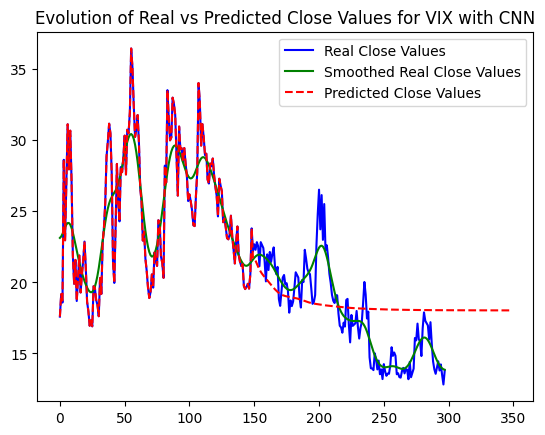

Feature: VIX - RMSE: 0.22939333246731516
Training for VIX with configuration rank 2
Epoch 1/1000
54/54 [==============================] - 27s 257ms/step - loss: 1063.1324 - val_loss: 136.3142
Epoch 2/1000
54/54 [==============================] - 11s 206ms/step - loss: 46.4927 - val_loss: 15.7702
Epoch 3/1000
54/54 [==============================] - 11s 204ms/step - loss: 14.4984 - val_loss: 12.9393
Epoch 4/1000
54/54 [==============================] - 11s 206ms/step - loss: 13.7197 - val_loss: 12.8103
Epoch 5/1000
54/54 [==============================] - 11s 205ms/step - loss: 13.6848 - val_loss: 12.8685
Epoch 6/1000
54/54 [==============================] - 11s 206ms/step - loss: 13.6494 - val_loss: 12.8872
Epoch 7/1000
54/54 [==============================] - 11s 204ms/step - loss: 13.6524 - val_loss: 12.8075
Epoch 8/1000
54/54 [==============================] - 11s 209ms/step - loss: 13.6286 - val_loss: 12.7783
Epoch 9/1000
54/54 [==============================] - 11s 205ms/step - lo

54/54 [==============================] - 11s 205ms/step - loss: 13.4805 - val_loss: 12.7182
Epoch 78/1000
54/54 [==============================] - 11s 196ms/step - loss: 13.4810 - val_loss: 12.6088
Epoch 79/1000
54/54 [==============================] - 11s 205ms/step - loss: 13.4809 - val_loss: 12.6448
Epoch 80/1000
54/54 [==============================] - 10s 193ms/step - loss: 13.4755 - val_loss: 12.6396
Epoch 81/1000
54/54 [==============================] - 10s 185ms/step - loss: 13.4767 - val_loss: 12.7035
Epoch 82/1000
54/54 [==============================] - 10s 184ms/step - loss: 13.4709 - val_loss: 12.6623
Epoch 83/1000
54/54 [==============================] - 10s 185ms/step - loss: 13.4739 - val_loss: 12.6762
Epoch 84/1000
54/54 [==============================] - 10s 185ms/step - loss: 13.4777 - val_loss: 12.6173
Epoch 85/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.4770 - val_loss: 12.6629
Epoch 86/1000
54/54 [==============================] - 10s 1

Epoch 154/1000
54/54 [==============================] - 10s 183ms/step - loss: 13.3436 - val_loss: 12.4752
Epoch 155/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.3445 - val_loss: 12.5182
Epoch 156/1000
54/54 [==============================] - 10s 186ms/step - loss: 13.3411 - val_loss: 12.5052
Epoch 157/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.3326 - val_loss: 12.5728
Epoch 158/1000
54/54 [==============================] - 10s 188ms/step - loss: 13.3400 - val_loss: 12.4679
Epoch 159/1000
54/54 [==============================] - 10s 188ms/step - loss: 13.3415 - val_loss: 12.5069
Epoch 160/1000
54/54 [==============================] - 10s 189ms/step - loss: 13.3318 - val_loss: 12.4623
Epoch 161/1000
54/54 [==============================] - 11s 199ms/step - loss: 13.3291 - val_loss: 12.5456
Epoch 162/1000
54/54 [==============================] - 11s 205ms/step - loss: 13.3309 - val_loss: 12.4870
Epoch 163/1000
54/54 [===============

54/54 [==============================] - 11s 204ms/step - loss: 13.2085 - val_loss: 12.3350
Epoch 231/1000
54/54 [==============================] - 11s 204ms/step - loss: 13.2137 - val_loss: 12.3943
Epoch 232/1000
54/54 [==============================] - 11s 207ms/step - loss: 13.2137 - val_loss: 12.3489
Epoch 233/1000
54/54 [==============================] - 11s 206ms/step - loss: 13.2072 - val_loss: 12.4081
Epoch 234/1000
54/54 [==============================] - 11s 203ms/step - loss: 13.2044 - val_loss: 12.3428
Epoch 235/1000
54/54 [==============================] - 11s 204ms/step - loss: 13.2062 - val_loss: 12.3678
Epoch 236/1000
54/54 [==============================] - 11s 207ms/step - loss: 13.2054 - val_loss: 12.3392
Epoch 237/1000
54/54 [==============================] - 11s 205ms/step - loss: 13.1959 - val_loss: 12.4548
Epoch 238/1000
54/54 [==============================] - 11s 200ms/step - loss: 13.2013 - val_loss: 12.3270
Epoch 239/1000
54/54 [==============================

54/54 [==============================] - 11s 201ms/step - loss: 13.1276 - val_loss: 12.2857
Epoch 307/1000
54/54 [==============================] - 11s 203ms/step - loss: 13.1170 - val_loss: 12.3397
Epoch 308/1000
54/54 [==============================] - 11s 202ms/step - loss: 13.1235 - val_loss: 12.2472
Epoch 309/1000
54/54 [==============================] - 10s 192ms/step - loss: 13.1302 - val_loss: 12.3363
Epoch 310/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.1321 - val_loss: 12.2610
Epoch 311/1000
54/54 [==============================] - 10s 188ms/step - loss: 13.1201 - val_loss: 12.3289
Epoch 312/1000
54/54 [==============================] - 10s 185ms/step - loss: 13.1344 - val_loss: 12.2630
Epoch 313/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.1350 - val_loss: 12.3445
Epoch 314/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.1454 - val_loss: 12.2758
Epoch 315/1000
54/54 [==============================

54/54 [==============================] - 10s 184ms/step - loss: 13.0612 - val_loss: 12.1959
Epoch 383/1000
54/54 [==============================] - 10s 184ms/step - loss: 13.0678 - val_loss: 12.2482
Epoch 384/1000
54/54 [==============================] - 10s 187ms/step - loss: 13.0610 - val_loss: 12.1809
Epoch 385/1000
54/54 [==============================] - 10s 188ms/step - loss: 13.0580 - val_loss: 12.2365
Epoch 386/1000
54/54 [==============================] - 10s 189ms/step - loss: 13.0588 - val_loss: 12.2002
Epoch 387/1000
54/54 [==============================] - 10s 188ms/step - loss: 13.0514 - val_loss: 12.2576
Epoch 388/1000
54/54 [==============================] - 10s 185ms/step - loss: 13.0492 - val_loss: 12.1845
Epoch 389/1000
54/54 [==============================] - 10s 186ms/step - loss: 13.0566 - val_loss: 12.2370
Epoch 390/1000
54/54 [==============================] - 11s 204ms/step - loss: 13.0672 - val_loss: 12.1909
Epoch 391/1000
54/54 [==============================

54/54 [==============================] - 10s 193ms/step - loss: 12.9549 - val_loss: 12.0948
Epoch 459/1000
54/54 [==============================] - 11s 206ms/step - loss: 12.9718 - val_loss: 12.1153
Epoch 460/1000
54/54 [==============================] - 11s 210ms/step - loss: 12.9582 - val_loss: 12.0861
Epoch 461/1000
54/54 [==============================] - 11s 206ms/step - loss: 12.9428 - val_loss: 12.1793
Epoch 462/1000
54/54 [==============================] - 11s 207ms/step - loss: 12.9505 - val_loss: 12.0994
Epoch 463/1000
54/54 [==============================] - 11s 202ms/step - loss: 12.9594 - val_loss: 12.1165
Epoch 464/1000
54/54 [==============================] - 11s 203ms/step - loss: 12.9513 - val_loss: 12.0695
Epoch 465/1000
54/54 [==============================] - 11s 206ms/step - loss: 12.9461 - val_loss: 12.1450
Epoch 466/1000
54/54 [==============================] - 11s 206ms/step - loss: 12.9478 - val_loss: 12.0803
Epoch 467/1000
54/54 [==============================

1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 102ms/step


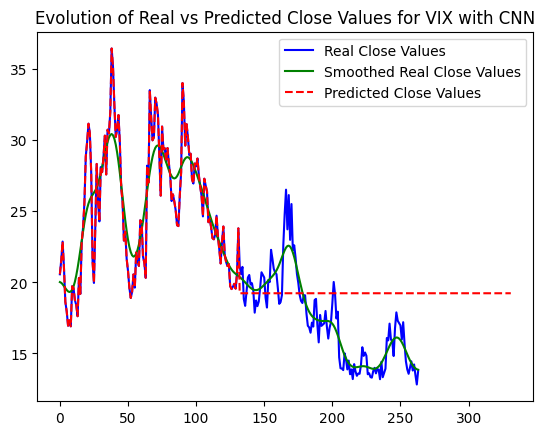

Feature: VIX - RMSE: 0.2072438738245441
Training for VIX with configuration rank 3
Epoch 1/1000
54/54 [==============================] - 21s 187ms/step - loss: 141.3010 - val_loss: 62.7813
Epoch 2/1000
54/54 [==============================] - 8s 145ms/step - loss: 42.6877 - val_loss: 28.3406
Epoch 3/1000
54/54 [==============================] - 8s 144ms/step - loss: 21.7655 - val_loss: 15.9050
Epoch 4/1000
54/54 [==============================] - 8s 145ms/step - loss: 12.5182 - val_loss: 9.4233
Epoch 5/1000
54/54 [==============================] - 8s 144ms/step - loss: 7.6058 - val_loss: 5.6319
Epoch 6/1000
54/54 [==============================] - 8s 143ms/step - loss: 4.9586 - val_loss: 3.7539
Epoch 7/1000
54/54 [==============================] - 8s 141ms/step - loss: 3.3997 - val_loss: 2.6501
Epoch 8/1000
54/54 [==============================] - 8s 144ms/step - loss: 2.3812 - val_loss: 2.0021
Epoch 9/1000
54/54 [==============================] - 8s 144ms/step - loss: 1.9543 - val_los

54/54 [==============================] - 9s 162ms/step - loss: 1.0237 - val_loss: 0.9666
Epoch 80/1000
54/54 [==============================] - 8s 153ms/step - loss: 1.0113 - val_loss: 0.9664
Epoch 81/1000
54/54 [==============================] - 8s 156ms/step - loss: 1.0129 - val_loss: 0.9597
Epoch 82/1000
54/54 [==============================] - 9s 165ms/step - loss: 1.0136 - val_loss: 0.9496
Epoch 83/1000
54/54 [==============================] - 8s 155ms/step - loss: 1.0067 - val_loss: 0.9504
Epoch 84/1000
54/54 [==============================] - 8s 156ms/step - loss: 1.0118 - val_loss: 0.9489
Epoch 85/1000
54/54 [==============================] - 9s 160ms/step - loss: 1.0150 - val_loss: 0.9918
Epoch 86/1000
54/54 [==============================] - 8s 154ms/step - loss: 1.0206 - val_loss: 0.9718
Epoch 87/1000
54/54 [==============================] - 8s 141ms/step - loss: 1.0216 - val_loss: 0.9930
Epoch 88/1000
54/54 [==============================] - 8s 144ms/step - loss: 1.0329 - v

1/1 [==============================] - 0s 90ms/step
Feature: VIX - RMSE: 0.3699220192108782
Training for VIX with configuration rank 4
Epoch 1/1000
54/54 [==============================] - 26s 235ms/step - loss: 1182.8914 - val_loss: 131.5139
Epoch 2/1000
54/54 [==============================] - 9s 173ms/step - loss: 42.7566 - val_loss: 16.3489
Epoch 3/1000
54/54 [==============================] - 10s 191ms/step - loss: 14.2261 - val_loss: 12.6775
Epoch 4/1000
54/54 [==============================] - 10s 190ms/step - loss: 13.3589 - val_loss: 12.4495
Epoch 5/1000
54/54 [==============================] - 10s 194ms/step - loss: 13.2358 - val_loss: 12.4078
Epoch 6/1000
54/54 [==============================] - 10s 189ms/step - loss: 13.1715 - val_loss: 12.3507
Epoch 7/1000
54/54 [==============================] - 10s 191ms/step - loss: 13.1089 - val_loss: 12.2270
Epoch 8/1000
54/54 [==============================] - 10s 192ms/step - loss: 13.0369 - val_loss: 12.2747
Epoch 9/1000
54/54 [===

54/54 [==============================] - 9s 171ms/step - loss: 13.5557 - val_loss: 12.7096
Epoch 43/1000
54/54 [==============================] - 9s 170ms/step - loss: 13.5564 - val_loss: 12.7580
Epoch 44/1000
54/54 [==============================] - 9s 171ms/step - loss: 13.5581 - val_loss: 12.7844
Epoch 45/1000
54/54 [==============================] - 9s 168ms/step - loss: 13.5578 - val_loss: 12.7585
Epoch 46/1000
54/54 [==============================] - 9s 172ms/step - loss: 13.5630 - val_loss: 12.6303
Epoch 47/1000
1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 90ms/step


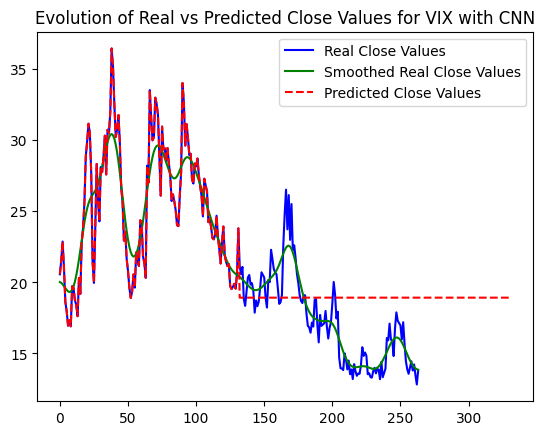

Feature: VIX - RMSE: 0.20296595268995812
Training for VIX with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 21s 202ms/step - loss: 161.1532 - val_loss: 59.1132
Epoch 2/1000
54/54 [==============================] - 9s 165ms/step - loss: 33.9426 - val_loss: 17.5697
Epoch 3/1000
54/54 [==============================] - 9s 164ms/step - loss: 11.9525 - val_loss: 7.2086
Epoch 4/1000
54/54 [==============================] - 9s 164ms/step - loss: 5.7440 - val_loss: 3.6397
Epoch 5/1000
54/54 [==============================] - 9s 164ms/step - loss: 3.2979 - val_loss: 2.3886
Epoch 6/1000
54/54 [==============================] - 9s 163ms/step - loss: 2.3577 - val_loss: 2.1077
Epoch 7/1000
54/54 [==============================] - 9s 162ms/step - loss: 1.8440 - val_loss: 1.5621
Epoch 8/1000
54/54 [==============================] - 9s 159ms/step - loss: 1.5910 - val_loss: 1.4318
Epoch 9/1000
54/54 [==============================] - 9s 164ms/step - loss: 1.4148 - val_loss

54/54 [==============================] - 8s 143ms/step - loss: 1.2423 - val_loss: 1.1878
Epoch 80/1000
54/54 [==============================] - 8s 147ms/step - loss: 1.2286 - val_loss: 1.1749
Epoch 81/1000
54/54 [==============================] - 8s 148ms/step - loss: 1.2138 - val_loss: 1.1792
Epoch 82/1000
54/54 [==============================] - 8s 147ms/step - loss: 1.2152 - val_loss: 1.1620
Epoch 83/1000
54/54 [==============================] - 8s 146ms/step - loss: 1.2131 - val_loss: 1.2114
Epoch 84/1000
54/54 [==============================] - 8s 143ms/step - loss: 13.0379 - val_loss: 47.9267
Epoch 85/1000
54/54 [==============================] - 8s 144ms/step - loss: 148.2278 - val_loss: 174.0114
Epoch 86/1000
54/54 [==============================] - 8s 144ms/step - loss: 162.5144 - val_loss: 151.5638
Epoch 87/1000
54/54 [==============================] - 8s 148ms/step - loss: 145.7417 - val_loss: 140.9662
Epoch 88/1000
54/54 [==============================] - 9s 162ms/step - lo

1/1 [==============================] - 0s 90ms/step
Feature: VIX - RMSE: 0.3475159252635845
Training for FVX with configuration rank 1
Epoch 1/1000
53/53 [==============================] - 26s 283ms/step - loss: 4.2573 - val_loss: 2.6337
Epoch 2/1000
53/53 [==============================] - 11s 211ms/step - loss: 1.9828 - val_loss: 1.5405
Epoch 3/1000
53/53 [==============================] - 10s 190ms/step - loss: 1.3012 - val_loss: 1.1191
Epoch 4/1000
53/53 [==============================] - 10s 186ms/step - loss: 0.9853 - val_loss: 0.8690
Epoch 5/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.7749 - val_loss: 0.7119
Epoch 6/1000
53/53 [==============================] - 10s 192ms/step - loss: 0.6175 - val_loss: 0.5812
Epoch 7/1000
53/53 [==============================] - 10s 190ms/step - loss: 0.4964 - val_loss: 0.5047
Epoch 8/1000
53/53 [==============================] - 10s 188ms/step - loss: 0.4018 - val_loss: 0.3718
Epoch 9/1000
53/53 [=====================

53/53 [==============================] - 10s 189ms/step - loss: 0.1767 - val_loss: 0.1596
Epoch 13/1000
53/53 [==============================] - 10s 190ms/step - loss: 0.1446 - val_loss: 0.1315
Epoch 14/1000
53/53 [==============================] - 10s 194ms/step - loss: 0.1210 - val_loss: 0.1125
Epoch 15/1000
53/53 [==============================] - 11s 211ms/step - loss: 0.1116 - val_loss: 0.1008
Epoch 16/1000
53/53 [==============================] - 11s 216ms/step - loss: 0.0886 - val_loss: 0.0811
Epoch 17/1000
53/53 [==============================] - 11s 216ms/step - loss: 0.0743 - val_loss: 0.0690
Epoch 18/1000
53/53 [==============================] - 11s 213ms/step - loss: 0.0622 - val_loss: 0.0743
Epoch 19/1000
53/53 [==============================] - 11s 215ms/step - loss: 0.0566 - val_loss: 0.0741
Epoch 20/1000
53/53 [==============================] - 11s 214ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 21/1000
53/53 [==============================] - 12s 218ms/step - loss: 

Epoch 91/1000
53/53 [==============================] - 11s 211ms/step - loss: 0.0128 - val_loss: 0.0149
Epoch 92/1000
53/53 [==============================] - 11s 206ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 93/1000
53/53 [==============================] - 10s 193ms/step - loss: 0.0127 - val_loss: 0.0150
Epoch 94/1000
53/53 [==============================] - 10s 189ms/step - loss: 0.0125 - val_loss: 0.0143
Epoch 95/1000
53/53 [==============================] - 10s 193ms/step - loss: 0.0132 - val_loss: 0.0139
Epoch 96/1000
53/53 [==============================] - 10s 190ms/step - loss: 0.0125 - val_loss: 0.0156
Epoch 97/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.0123 - val_loss: 0.0138
Epoch 98/1000
53/53 [==============================] - 10s 186ms/step - loss: 0.0128 - val_loss: 0.0138
Epoch 99/1000
53/53 [==============================] - 10s 194ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 100/1000
53/53 [==============================] - 10s 190m

53/53 [==============================] - 10s 192ms/step - loss: 0.0126 - val_loss: 0.0167
Epoch 170/1000
53/53 [==============================] - 10s 193ms/step - loss: 0.0122 - val_loss: 0.0213
Epoch 171/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.0120 - val_loss: 0.0146
Epoch 172/1000
53/53 [==============================] - 10s 194ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 173/1000
53/53 [==============================] - 11s 216ms/step - loss: 0.0126 - val_loss: 0.0145
Epoch 174/1000
53/53 [==============================] - 11s 215ms/step - loss: 0.0124 - val_loss: 0.0164
Epoch 175/1000
53/53 [==============================] - 11s 214ms/step - loss: 0.0125 - val_loss: 0.0164
Epoch 176/1000
53/53 [==============================] - 11s 214ms/step - loss: 0.0121 - val_loss: 0.0129
Epoch 177/1000
53/53 [==============================] - 12s 218ms/step - loss: 0.0120 - val_loss: 0.0130
Epoch 178/1000
53/53 [==============================] - 11s 213ms/step

53/53 [==============================] - 11s 203ms/step - loss: 0.0117 - val_loss: 0.0126
Epoch 248/1000
53/53 [==============================] - 11s 212ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 249/1000
53/53 [==============================] - 11s 212ms/step - loss: 0.0117 - val_loss: 0.0155
Epoch 250/1000
53/53 [==============================] - 11s 201ms/step - loss: 0.0116 - val_loss: 0.0145
Epoch 251/1000
53/53 [==============================] - 10s 188ms/step - loss: 0.0123 - val_loss: 0.0143
Epoch 252/1000
53/53 [==============================] - 10s 188ms/step - loss: 0.0116 - val_loss: 0.0130
Epoch 253/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.0115 - val_loss: 0.0171
Epoch 254/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 255/1000
53/53 [==============================] - 10s 191ms/step - loss: 0.0115 - val_loss: 0.0127
Epoch 256/1000
53/53 [==============================] - 10s 192ms/step

1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 71ms/step


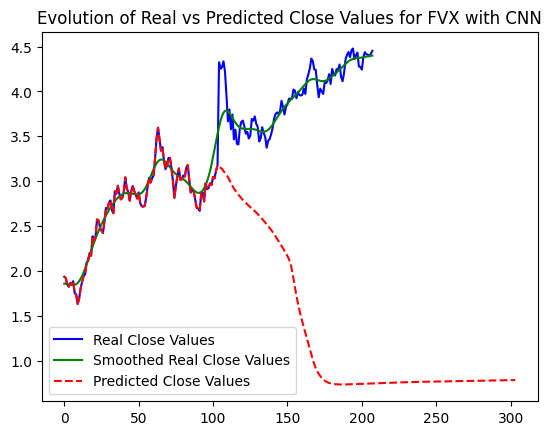

Feature: FVX - RMSE: 1.0525832885446695
Training for FVX with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 22s 227ms/step - loss: 4.8322 - val_loss: 2.8077
Epoch 2/1000
53/53 [==============================] - 9s 176ms/step - loss: 2.0361 - val_loss: 1.5857
Epoch 3/1000
53/53 [==============================] - 9s 175ms/step - loss: 1.3710 - val_loss: 1.1982
Epoch 4/1000
53/53 [==============================] - 9s 176ms/step - loss: 1.0526 - val_loss: 0.9616
Epoch 5/1000
53/53 [==============================] - 9s 175ms/step - loss: 0.8134 - val_loss: 0.7104
Epoch 6/1000
53/53 [==============================] - 9s 177ms/step - loss: 0.6235 - val_loss: 0.5460
Epoch 7/1000
53/53 [==============================] - 9s 175ms/step - loss: 0.4765 - val_loss: 0.4184
Epoch 8/1000
53/53 [==============================] - 9s 177ms/step - loss: 0.3639 - val_loss: 0.3358
Epoch 9/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.2844 - val_loss: 0.287

53/53 [==============================] - 9s 172ms/step - loss: 0.0264 - val_loss: 0.0381
Epoch 80/1000
53/53 [==============================] - 9s 176ms/step - loss: 0.0270 - val_loss: 0.0293
Epoch 81/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.0265 - val_loss: 0.0282
Epoch 82/1000
53/53 [==============================] - 9s 179ms/step - loss: 0.0262 - val_loss: 0.0274
Epoch 83/1000
53/53 [==============================] - 10s 180ms/step - loss: 0.0270 - val_loss: 0.0306
Epoch 84/1000
53/53 [==============================] - 9s 177ms/step - loss: 0.0272 - val_loss: 0.0323
Epoch 85/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.0267 - val_loss: 0.0278
Epoch 86/1000
53/53 [==============================] - 10s 196ms/step - loss: 0.0264 - val_loss: 0.0557
Epoch 87/1000
53/53 [==============================] - 10s 195ms/step - loss: 0.0267 - val_loss: 0.0306
Epoch 88/1000
53/53 [==============================] - 10s 189ms/step - loss: 0.026

1/1 [==============================] - 0s 130ms/step


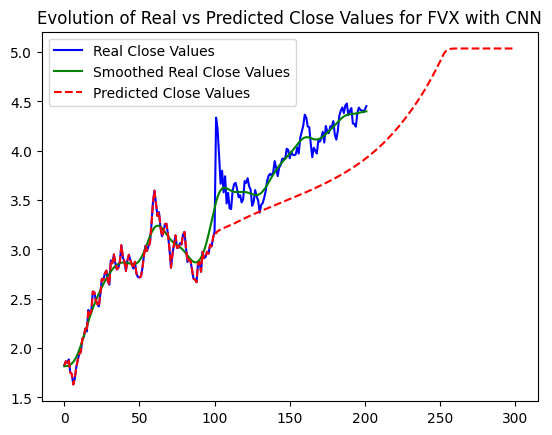

Feature: FVX - RMSE: 0.2988455713793852
Training for FVX with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 19s 180ms/step - loss: 1.2511 - val_loss: 0.8267
Epoch 2/1000
53/53 [==============================] - 7s 125ms/step - loss: 0.6402 - val_loss: 0.5205
Epoch 3/1000
53/53 [==============================] - 7s 127ms/step - loss: 0.4509 - val_loss: 0.4085
Epoch 4/1000
53/53 [==============================] - 6s 122ms/step - loss: 0.3585 - val_loss: 0.3313
Epoch 5/1000
53/53 [==============================] - 7s 123ms/step - loss: 0.2973 - val_loss: 0.2721
Epoch 6/1000
53/53 [==============================] - 7s 124ms/step - loss: 0.2472 - val_loss: 0.2277
Epoch 7/1000
53/53 [==============================] - 6s 121ms/step - loss: 0.2065 - val_loss: 0.1933
Epoch 8/1000
53/53 [==============================] - 6s 121ms/step - loss: 0.1735 - val_loss: 0.1610
Epoch 9/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.1471 - val_loss: 0.144

Epoch 80/1000
53/53 [==============================] - 7s 126ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 81/1000
53/53 [==============================] - 7s 125ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 82/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 83/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0079 - val_loss: 0.0094
Epoch 84/1000
53/53 [==============================] - 7s 124ms/step - loss: 0.0080 - val_loss: 0.0095
Epoch 85/1000
53/53 [==============================] - 7s 124ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 86/1000
53/53 [==============================] - 6s 121ms/step - loss: 0.0077 - val_loss: 0.0093
Epoch 87/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 88/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 89/1000
53/53 [==============================] - 6s 117ms/step - lo

Epoch 159/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.0080 - val_loss: 0.0152
Epoch 160/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 161/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 162/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0073 - val_loss: 0.0085
Epoch 163/1000
53/53 [==============================] - 6s 121ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 164/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.0073 - val_loss: 0.0123
Epoch 165/1000
53/53 [==============================] - 6s 120ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 166/1000
53/53 [==============================] - 6s 119ms/step - loss: 0.0080 - val_loss: 0.0106
Epoch 167/1000
53/53 [==============================] - 6s 118ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 168/1000
53/53 [==============================] - 6s 119ms

1/1 [==============================] - 0s 100ms/step


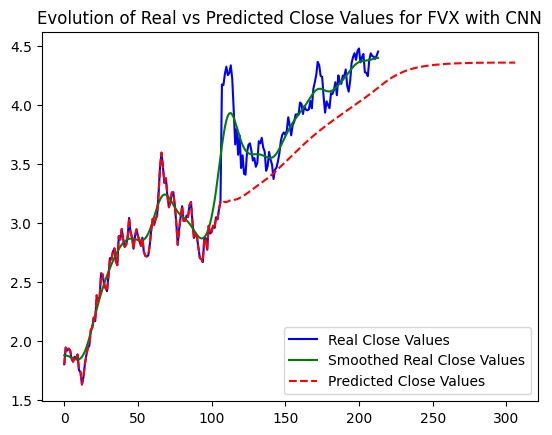

Feature: FVX - RMSE: 0.19313532537096353
Training for FVX with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 25s 253ms/step - loss: 4.2052 - val_loss: 3.0277
Epoch 2/1000
53/53 [==============================] - 11s 206ms/step - loss: 2.4347 - val_loss: 2.0036
Epoch 3/1000
53/53 [==============================] - 11s 203ms/step - loss: 1.7661 - val_loss: 1.5789
Epoch 4/1000
53/53 [==============================] - 10s 196ms/step - loss: 1.4431 - val_loss: 1.3425
Epoch 5/1000
53/53 [==============================] - 11s 198ms/step - loss: 1.2418 - val_loss: 1.1901
Epoch 6/1000
53/53 [==============================] - 10s 193ms/step - loss: 1.0951 - val_loss: 1.0327
Epoch 7/1000
53/53 [==============================] - 10s 193ms/step - loss: 0.9752 - val_loss: 0.9240
Epoch 8/1000
53/53 [==============================] - 10s 188ms/step - loss: 0.8737 - val_loss: 0.8383
Epoch 9/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.7842 - val_lo

53/53 [==============================] - 10s 192ms/step - loss: 0.0196 - val_loss: 0.0206
Epoch 80/1000
53/53 [==============================] - 10s 185ms/step - loss: 0.0192 - val_loss: 0.0197
Epoch 81/1000
53/53 [==============================] - 10s 185ms/step - loss: 0.0197 - val_loss: 0.0205
Epoch 82/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.0190 - val_loss: 0.0211
Epoch 83/1000
53/53 [==============================] - 10s 180ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 84/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.0197 - val_loss: 0.0202
Epoch 85/1000
53/53 [==============================] - 10s 188ms/step - loss: 0.0189 - val_loss: 0.0224
Epoch 86/1000
53/53 [==============================] - 10s 182ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 87/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 88/1000
53/53 [==============================] - 10s 184ms/step - loss: 0

1/1 [==============================] - 0s 70ms/step


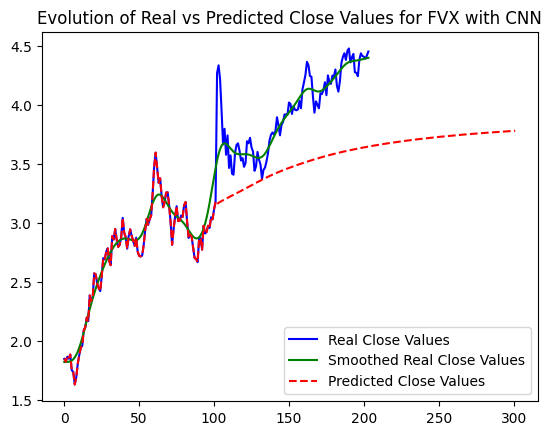

Feature: FVX - RMSE: 0.1460054051609267
Training for FVX with configuration rank 5
Epoch 1/1000
53/53 [==============================] - 18s 150ms/step - loss: 3.4874 - val_loss: 2.0141
Epoch 2/1000
53/53 [==============================] - 6s 111ms/step - loss: 1.4702 - val_loss: 1.1528
Epoch 3/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.9799 - val_loss: 0.8441
Epoch 4/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.7262 - val_loss: 0.6279
Epoch 5/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.5416 - val_loss: 0.4691
Epoch 6/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.4047 - val_loss: 0.3566
Epoch 7/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.3052 - val_loss: 0.2651
Epoch 8/1000
53/53 [==============================] - 6s 109ms/step - loss: 0.2300 - val_loss: 0.2115
Epoch 9/1000
53/53 [==============================] - 6s 116ms/step - loss: 0.1800 - val_loss: 0.156

Epoch 80/1000
53/53 [==============================] - 6s 109ms/step - loss: 0.0204 - val_loss: 0.0278
Epoch 81/1000
53/53 [==============================] - 6s 111ms/step - loss: 0.0215 - val_loss: 0.0225
Epoch 82/1000
53/53 [==============================] - 6s 108ms/step - loss: 0.0202 - val_loss: 0.0209
Epoch 83/1000
53/53 [==============================] - 6s 109ms/step - loss: 0.0201 - val_loss: 0.0216
Epoch 84/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.0197 - val_loss: 0.0209
Epoch 85/1000
53/53 [==============================] - 6s 111ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 86/1000
53/53 [==============================] - 6s 108ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 87/1000
53/53 [==============================] - 6s 109ms/step - loss: 0.0199 - val_loss: 0.0224
Epoch 88/1000
53/53 [==============================] - 6s 110ms/step - loss: 0.0199 - val_loss: 0.0294
Epoch 89/1000
53/53 [==============================] - 6s 119ms/step - lo

1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 100ms/step
Feature: FVX - RMSE: 0.2485818774926038
Training for NVDA with configuration rank 1
Epoch 1/1000
53/53 [==============================] - 24s 229ms/step - loss: 22.6282 - val_loss: 21.1234
Epoch 2/1000
53/53 [==============================] - 9s 169ms/step - loss: 12.4487 - val_loss: 20.1538
Epoch 3/1000
53/53 [==============================] - 9s 169ms/step - loss: 9.0005 - val_loss: 12.4192
Epoch 4/1000
53/53 [==============================] - 9s 167ms/step - loss: 7.2418 - val_loss: 11.1608
Epoch 5/1000
53/53 [==============================] - 9s 174ms/step - loss: 6.0505 - val_loss: 8.1349
Epoch 6/1000
53/53 [==============================] - 9s 170ms/step - loss: 5.1364 - val_loss: 9.1871
Epoch 7/1000
53/53 [==============================] - 9s 172ms/step - loss: 4.3821 - val_loss: 7.7224
Epoch 8/1000
53/53 [==============================] - 9s 170ms/step - loss: 3.7217 - val_loss: 8.0883
Epoch 9/1000
53/53 [====================

53/53 [==============================] - 9s 178ms/step - loss: 0.1234 - val_loss: 4.9628
Epoch 72/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.0933 - val_loss: 7.2318
Epoch 73/1000
53/53 [==============================] - 9s 177ms/step - loss: 0.0935 - val_loss: 6.5849
Epoch 74/1000
53/53 [==============================] - 9s 177ms/step - loss: 0.0935 - val_loss: 6.2495
Epoch 75/1000
53/53 [==============================] - 9s 172ms/step - loss: 0.0918 - val_loss: 6.0304
Epoch 76/1000
53/53 [==============================] - 9s 172ms/step - loss: 0.0947 - val_loss: 6.4405
Epoch 77/1000
53/53 [==============================] - 9s 170ms/step - loss: 0.0971 - val_loss: 6.1700
Epoch 78/1000
53/53 [==============================] - 9s 170ms/step - loss: 0.0998 - val_loss: 5.4101
Epoch 79/1000
53/53 [==============================] - 9s 170ms/step - loss: 0.0926 - val_loss: 6.9941
Epoch 80/1000
53/53 [==============================] - 9s 170ms/step - loss: 0.0919 - v

1/1 [==============================] - 0s 111ms/step


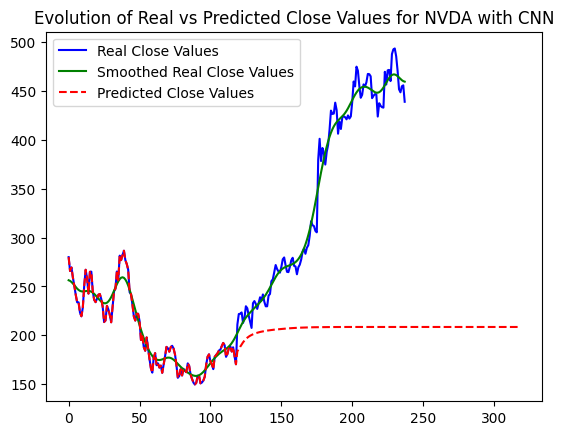

Feature: NVDA - RMSE: 1.885194175008191
Training for NVDA with configuration rank 2
Epoch 1/1000
54/54 [==============================] - 22s 196ms/step - loss: 9.7801 - val_loss: 16.0701
Epoch 2/1000
54/54 [==============================] - 8s 143ms/step - loss: 5.8606 - val_loss: 13.7478
Epoch 3/1000
54/54 [==============================] - 7s 126ms/step - loss: 4.3008 - val_loss: 10.4928
Epoch 4/1000
54/54 [==============================] - 7s 131ms/step - loss: 3.5521 - val_loss: 6.5693
Epoch 5/1000
54/54 [==============================] - 7s 128ms/step - loss: 3.0709 - val_loss: 9.9663
Epoch 6/1000
54/54 [==============================] - 7s 129ms/step - loss: 2.6700 - val_loss: 6.1066
Epoch 7/1000
54/54 [==============================] - 7s 127ms/step - loss: 2.4097 - val_loss: 6.0796
Epoch 8/1000
54/54 [==============================] - 7s 130ms/step - loss: 2.1046 - val_loss: 5.7818
Epoch 9/1000
54/54 [==============================] - 7s 124ms/step - loss: 1.9038 - val_loss: 6

Epoch 80/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.0419 - val_loss: 2.9886
Epoch 81/1000
54/54 [==============================] - 7s 122ms/step - loss: 0.0382 - val_loss: 2.9990
Epoch 82/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.0373 - val_loss: 2.7027
Epoch 83/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.0383 - val_loss: 3.8248
Epoch 84/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.0451 - val_loss: 2.9352
Epoch 85/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.0435 - val_loss: 3.2829
Epoch 86/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.0384 - val_loss: 3.7391
Epoch 87/1000
54/54 [==============================] - 7s 123ms/step - loss: 0.0416 - val_loss: 3.7758
Epoch 88/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.0360 - val_loss: 3.0828
Epoch 89/1000
54/54 [==============================] - 7s 124ms/step - lo

1/1 [==============================] - 0s 103ms/step


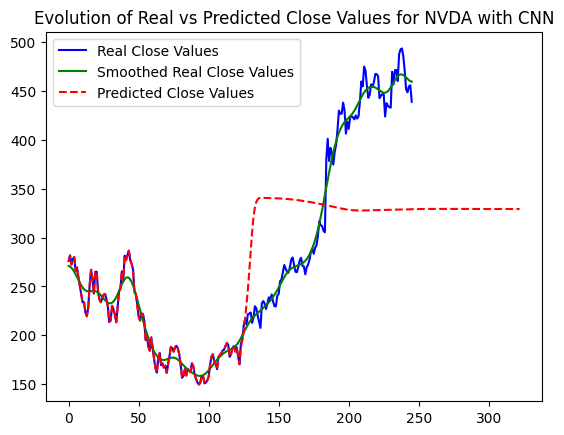

Feature: NVDA - RMSE: 1.3818982747444346
Training for NVDA with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 25s 279ms/step - loss: 5.8115 - val_loss: 13.5775
Epoch 2/1000
53/53 [==============================] - 11s 200ms/step - loss: 3.5905 - val_loss: 12.5690
Epoch 3/1000
53/53 [==============================] - 11s 201ms/step - loss: 2.9781 - val_loss: 10.6619
Epoch 4/1000
53/53 [==============================] - 10s 192ms/step - loss: 2.5396 - val_loss: 9.2774
Epoch 5/1000
53/53 [==============================] - 10s 190ms/step - loss: 2.2665 - val_loss: 7.8802
Epoch 6/1000
53/53 [==============================] - 10s 187ms/step - loss: 2.0485 - val_loss: 5.5028
Epoch 7/1000
53/53 [==============================] - 10s 184ms/step - loss: 1.8990 - val_loss: 7.9101
Epoch 8/1000
53/53 [==============================] - 10s 186ms/step - loss: 1.7068 - val_loss: 5.8178
Epoch 9/1000
53/53 [==============================] - 9s 177ms/step - loss: 1.5667 - val

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 90ms/step


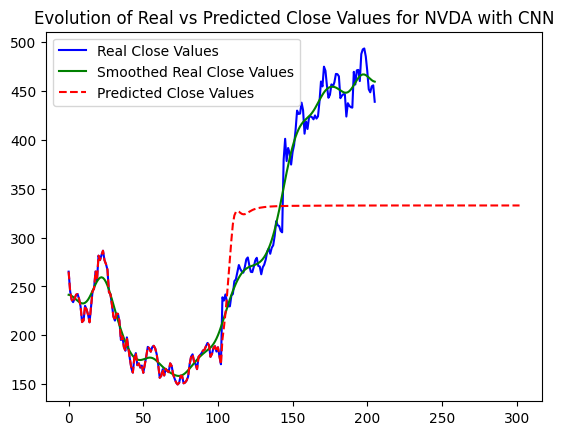

Feature: NVDA - RMSE: 1.2148813884070129
Training for NVDA with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 21s 231ms/step - loss: 13.6410 - val_loss: 19.8176
Epoch 2/1000
53/53 [==============================] - 10s 185ms/step - loss: 8.5407 - val_loss: 15.2442
Epoch 3/1000
53/53 [==============================] - 10s 183ms/step - loss: 6.3493 - val_loss: 10.9631
Epoch 4/1000
53/53 [==============================] - 10s 182ms/step - loss: 4.9897 - val_loss: 8.8539
Epoch 5/1000
53/53 [==============================] - 10s 183ms/step - loss: 4.1104 - val_loss: 9.0468
Epoch 6/1000
53/53 [==============================] - 9s 175ms/step - loss: 3.4289 - val_loss: 7.3095
Epoch 7/1000
53/53 [==============================] - 9s 174ms/step - loss: 2.9292 - val_loss: 9.6297
Epoch 8/1000
53/53 [==============================] - 9s 179ms/step - loss: 2.5313 - val_loss: 6.4866
Epoch 9/1000
53/53 [==============================] - 9s 170ms/step - loss: 2.1706 - val_l

53/53 [==============================] - 8s 160ms/step - loss: 0.0654 - val_loss: 4.3252
Epoch 80/1000
53/53 [==============================] - 9s 166ms/step - loss: 0.0648 - val_loss: 4.8696
Epoch 81/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.0657 - val_loss: 4.5827
Epoch 82/1000
53/53 [==============================] - 10s 185ms/step - loss: 0.0635 - val_loss: 5.0864
Epoch 83/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.0648 - val_loss: 4.7111
Epoch 84/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.0668 - val_loss: 5.2451
Epoch 85/1000
53/53 [==============================] - 10s 180ms/step - loss: 0.0680 - val_loss: 4.8579
Epoch 86/1000
53/53 [==============================] - 9s 179ms/step - loss: 0.0698 - val_loss: 5.3806
Epoch 87/1000
53/53 [==============================] - 9s 174ms/step - loss: 0.0675 - val_loss: 5.2335
Epoch 88/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.06

1/1 [==============================] - 0s 111ms/step
Feature: NVDA - RMSE: 1.4063496217714107
Training for NVDA with configuration rank 5
Epoch 1/1000
54/54 [==============================] - 21s 169ms/step - loss: 3.6921 - val_loss: 9.6735
Epoch 2/1000
54/54 [==============================] - 6s 116ms/step - loss: 2.0287 - val_loss: 2.9926
Epoch 3/1000
54/54 [==============================] - 6s 115ms/step - loss: 1.5181 - val_loss: 2.6648
Epoch 4/1000
54/54 [==============================] - 6s 117ms/step - loss: 1.2656 - val_loss: 2.8574
Epoch 5/1000
54/54 [==============================] - 6s 114ms/step - loss: 1.0990 - val_loss: 3.5744
Epoch 6/1000
54/54 [==============================] - 6s 113ms/step - loss: 0.9459 - val_loss: 3.2846
Epoch 7/1000
54/54 [==============================] - 6s 114ms/step - loss: 0.8340 - val_loss: 1.6236
Epoch 8/1000
54/54 [==============================] - 6s 112ms/step - loss: 0.7393 - val_loss: 3.0753
Epoch 9/1000
54/54 [=========================

54/54 [==============================] - 6s 112ms/step - loss: 0.0913 - val_loss: 5.4382
Epoch 27/1000
54/54 [==============================] - 6s 113ms/step - loss: 0.0945 - val_loss: 4.2096
Epoch 28/1000
54/54 [==============================] - 6s 119ms/step - loss: 0.0836 - val_loss: 5.6856
Epoch 29/1000
54/54 [==============================] - 6s 120ms/step - loss: 0.0742 - val_loss: 3.7164
Epoch 30/1000
54/54 [==============================] - 7s 128ms/step - loss: 0.0826 - val_loss: 5.5016
Epoch 31/1000
54/54 [==============================] - 7s 128ms/step - loss: 0.0585 - val_loss: 4.5191
Epoch 32/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0556 - val_loss: 4.9795
Epoch 33/1000
54/54 [==============================] - 7s 126ms/step - loss: 0.0497 - val_loss: 4.8164
Epoch 34/1000
54/54 [==============================] - 7s 124ms/step - loss: 0.0471 - val_loss: 3.9037
Epoch 35/1000
54/54 [==============================] - 7s 127ms/step - loss: 0.0446 - v

1/1 [==============================] - 0s 61ms/step
Feature: NVDA - RMSE: 1.8562277338479516
Entraînement des modèles de réseau neuronal terminé.


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def recursive_prediction_multi_output(model, initial_input, steps):
    recursive_predictions = []  # Une liste pour stocker les prédictions à chaque étape
    current_input = initial_input.copy()  # Copie de l'entrée initiale pour éviter les modifications indésirables

    for i in range(steps):
        # Faire une prédiction pour le jour suivant en utilisant l'entrée actuelle
        predicted_values = model.predict(current_input.to_numpy().reshape(1, current_input.shape[0], current_input.shape[1]))
        
        # Ajouter ces prédictions à notre liste
        recursive_predictions.append(predicted_values[0])
        
        # Préparer l'entrée pour la prochaine prédiction
        # Supprimer la première valeur (jour le plus ancien)
        current_input = current_input.shift(-1)
        # Ajouter la nouvelle valeur prédite à la fin de l'entrée
        current_input.iloc[-1:] = pd.DataFrame(predicted_values)

    return np.array(recursive_predictions)

# Dictionnaires pour stocker les modèles et leurs performances
gru_models = {}
mse_gru = {}
recursive_preds_gru = {}

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice
    # Sélectionner hyperparamètre optimaux
    top_n_params = top_n_trials_per_feature[index_name]
    best_rmse = float('inf') 
    best_model = None
    
    for rank, best_params in enumerate(top_n_params, 1):
        print(f"Training for {index_name} with configuration rank {rank}")
        look_back=best_params['look_back']

        # Créer des séquences pour l'entraînement et les tests
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        # Create the neural network model
        model = create_model(
            num_layers=best_params['num_layers'],
            units_per_layer=[2 ** (best_params[f'units_power_{i}']) for i in range(best_params['num_layers'])],
            layer_type=[best_params[f'layer_type_{i}'] for i in range(best_params['num_layers'])],
            dropout_per_layer=[best_params[f'dropout_{i}'] for i in range(best_params['num_layers'])],
            input_shape=(X_train.shape[1], 1),
            use_conv1d=best_params['use_conv1d'],
            conv1d_filters=2 ** best_params['conv1d_filters'] if best_params['use_conv1d'] else None,
            conv1d_kernel_size=best_params.get('conv1d_kernel_size', None),
            use_residual_connection=best_params['use_residual_connection'],
            attention_layer=best_params['use_attention_layer'],
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg']
        )

        # Entraîner le modèle
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=64, callbacks=[early_stopping])

        # Évaluer le modèle

        # Initial input: X dernières observations du jeu de données d'entraînement
        initial_input = train_data[[(index_name, 'Close')]][-look_back:]

        # Prédictions récursives
        predictions = recursive_prediction_multi_output(model, initial_input, len(test_data))

        # Initialisation
        inverse_predictions = np.zeros_like(predictions)
        inverse_real_values = np.zeros_like(y_test)

        # Parcourir chaque caractéristique et chaque indice
        for idx, feature_name in enumerate(['Close']):
            scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
            feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant

            # Inverser la mise à l'échelle pour les prédictions et les valeurs réelles
            inverse_predictions = feature_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            inverse_real_values_test = feature_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

            # Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement
            last_real_values_train_scaled = train_data[(index_name, 'Close')].iloc[-len(y_test):].values
            last_real_values_train = feature_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1)).flatten()

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
            real_values = np.concatenate([last_real_values_train, inverse_real_values_test])

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
            predicted_values = np.concatenate([last_real_values_train, inverse_predictions])
            
            # Appliquer le filtre gaussien
            sigma = 5
            smoothed_values_test = gaussian_filter1d(y_test, sigma)
            smoothed_values = gaussian_filter1d(real_values, sigma)

            rmse = weighted_rmse(smoothed_values_test, np.array(predictions), len(smoothed_values_test))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                plt.plot(real_values, label='Real Close Values', color='blue')
                plt.plot(smoothed_values, label='Smoothed Real Close Values', color='green')
                plt.plot(predicted_values, label='Predicted Close Values', color='red', linestyle='--')
                plt.title(f"Evolution of Real vs Predicted Close Values for {index_name} with CNN")
                plt.legend()
                plt.show()
                
                # Stockez les prédictions pour cette caractéristique
                recursive_preds_gru[scaler_key] = inverse_predictions

            # Stocker le modèle et sa performance
            gru_models[scaler_key] = best_model
            mse_gru[scaler_key] = best_rmse
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles de réseau neuronal terminé.")

#### Modèle XGBoost:

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Si les données sont une liste ou un tableau 1D, les convertir en DataFrame
    if type(data) is list or len(data.shape) == 1:
        df = pd.DataFrame(data)
        n_vars = 1
    else:
        df = pd.DataFrame(data)
        n_vars = data.shape[1]
    cols, names = list(), list()
    # Séquence d'entrée (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Séquence de prévision (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concaténer le tout
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Supprimer les lignes avec des valeurs NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def recursive_prediction_xgb(model, initial_input, steps):
    current_input = np.array(initial_input)
    predictions = []
    for _ in range(steps):
        predicted_values = model.predict(current_input.reshape(1, -1))
        predictions.append(predicted_values)
        current_input = np.roll(current_input, -1)
        current_input[-1:] = predicted_values
    return np.array(predictions)

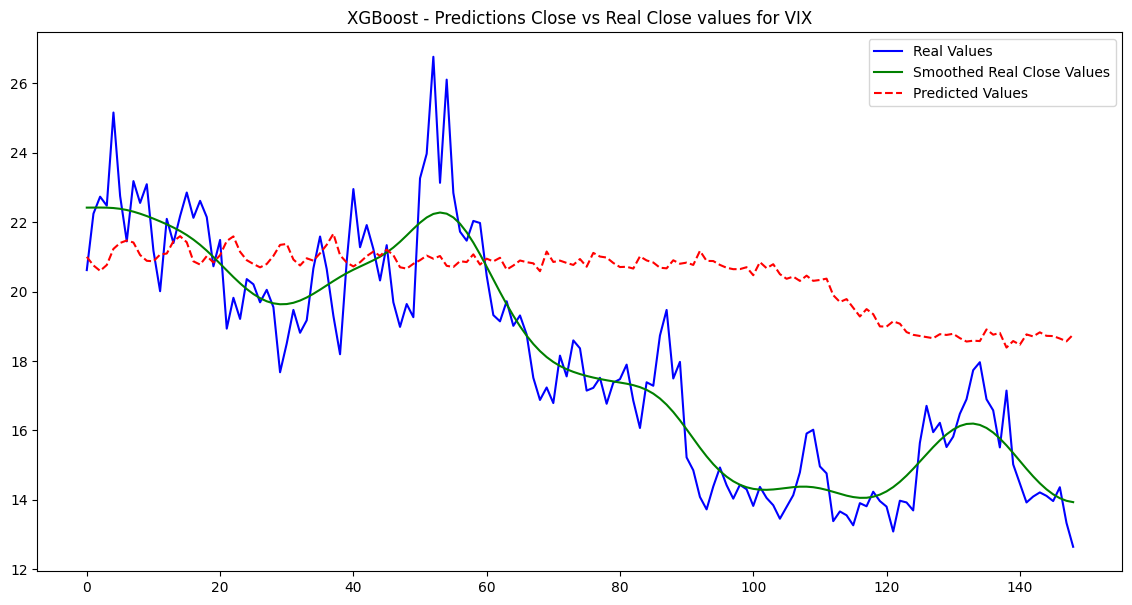

Feature: VIX - RMSE: 0.23167969061944327


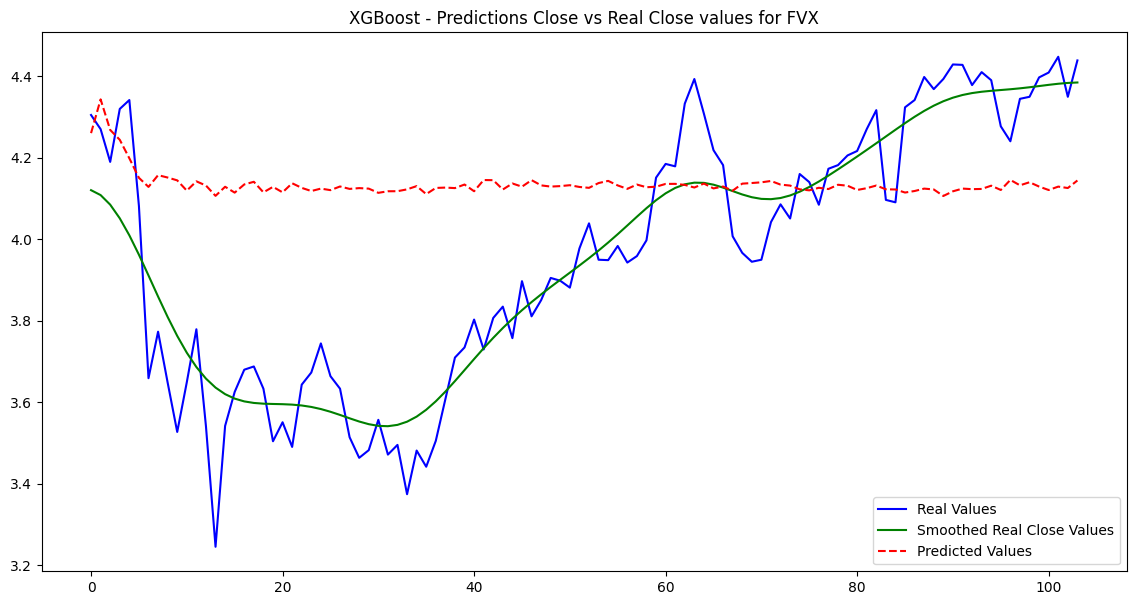

Feature: FVX - RMSE: 0.15152109630999225


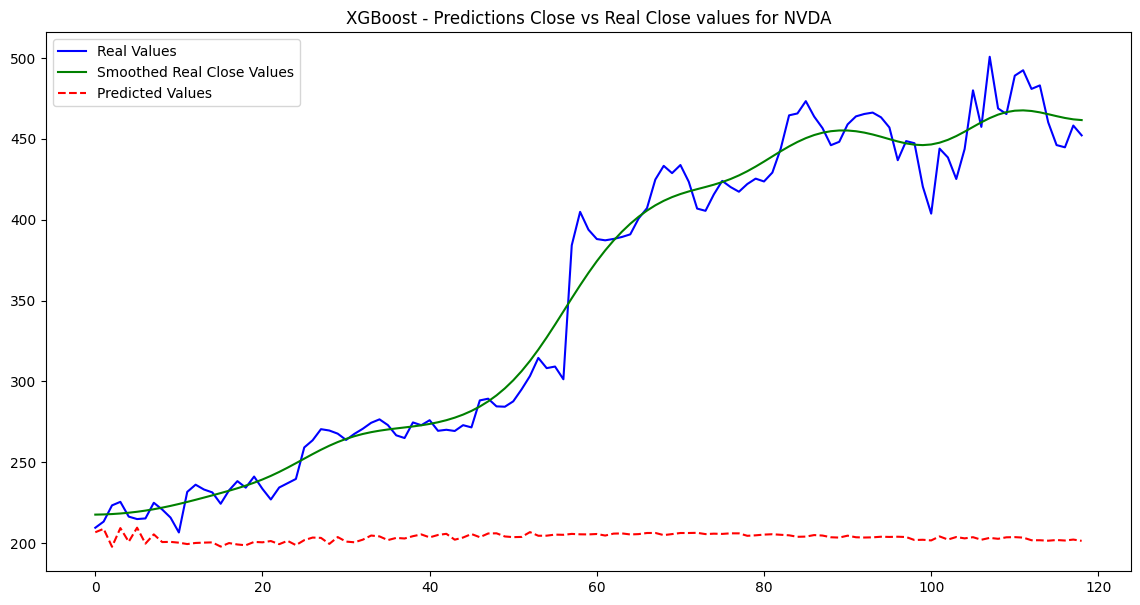

Feature: NVDA - RMSE: 1.914896501751244
Entraînement des modèles XGBoost terminé.


In [19]:
# Dictionnaires pour stocker les modèles XGBoost et leurs performances
xgb_models = {}
mse_xgb = {}
recursive_preds_xgb = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    # Modèle XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(X_train, y_train)
    
    # Prédictions
    initial_input = X_test[0]
    predictions = recursive_prediction_xgb(model, initial_input, len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        # Afficher les graphiques
        plt.figure(figsize=(14,7))

        # Tracez les valeurs réelles
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')

        # Tracez les prédictions
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')

        plt.title(f"XGBoost - Predictions Close vs Real Close values for {index_name}")
        plt.legend()
        plt.show()

        # Évaluer le modèle
        rmse = weighted_rmse(smoothed_values, np.array(predictions), len(smoothed_values))

        # Stocker le modèle et sa performance
        xgb_models[scaler_key] = model
        mse_xgb[scaler_key] = rmse
        recursive_preds_xgb[scaler_key] = inverse_predictions
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles XGBoost terminé.")

#### Modèle SARIMA:

[I 2023-09-20 13:29:38,137] A new study created in memory with name: no-name-bdde262a-0177-4feb-93fe-7c334d45e627
[I 2023-09-20 13:30:22,081] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 4, 'P': 2, 'D': 0, 'Q': 4, 's': 9}. Best is trial 0 with value: inf.
[I 2023-09-20 13:30:25,600] Trial 1 finished with value: inf and parameters: {'p': 3, 'd': 1, 'q': 2, 'P': 2, 'D': 1, 'Q': 0, 's': 4}. Best is trial 0 with value: inf.
[I 2023-09-20 13:30:31,433] Trial 2 finished with value: 0.14047911670051344 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 3, 'D': 0, 'Q': 4, 's': 6}. Best is trial 2 with value: 0.14047911670051344.
[I 2023-09-20 13:30:33,607] Trial 3 finished with value: 0.2932214718349226 and parameters: {'p': 5, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 's': 5}. Best is trial 2 with value: 0.14047911670051344.
[I 2023-09-20 13:30:47,595] Trial 4 finished with value: inf and parameters: {'p': 5, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 3, 's': 4}. Best is trial 2 

[I 2023-09-20 13:52:05,552] Trial 42 finished with value: 0.13982604779927027 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 3, 'D': 0, 'Q': 4, 's': 6}. Best is trial 31 with value: 0.13982604779927027.
[I 2023-09-20 13:52:12,845] Trial 43 finished with value: 0.1486288981352333 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 2, 'D': 0, 'Q': 4, 's': 6}. Best is trial 31 with value: 0.13982604779927027.
[I 2023-09-20 13:52:16,928] Trial 44 finished with value: 0.15410948744600794 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 4, 'D': 0, 'Q': 4, 's': 4}. Best is trial 31 with value: 0.13982604779927027.
[I 2023-09-20 13:52:22,276] Trial 45 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 3, 'D': 0, 'Q': 3, 's': 7}. Best is trial 31 with value: 0.13982604779927027.
[I 2023-09-20 13:52:33,524] Trial 46 finished with value: 0.14165146843951024 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 4, 'D': 0, 'Q': 4, 's': 6}. Best is trial 31 with value: 0.13982604779927027.
[I 2023

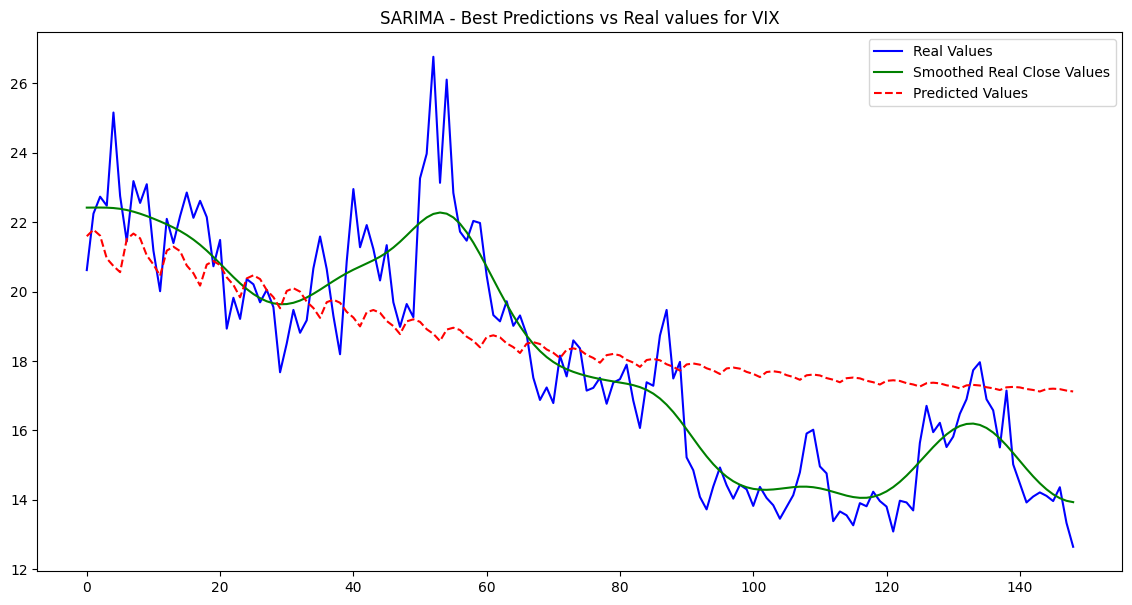

[I 2023-09-20 13:54:18,944] A new study created in memory with name: no-name-5c925a8d-cf25-4205-9970-74f1971814bb


Feature: VIX - Best RMSE: 0.13982604779927027


[I 2023-09-20 13:54:22,800] Trial 0 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 1, 'D': 0, 'Q': 3, 's': 5}. Best is trial 0 with value: inf.
[I 2023-09-20 13:54:27,650] Trial 1 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 1, 'D': 0, 'Q': 4, 's': 5}. Best is trial 0 with value: inf.
[I 2023-09-20 13:54:27,662] Trial 2 finished with value: inf and parameters: {'p': 3, 'd': 0, 'q': 4, 'P': 0, 'D': 1, 'Q': 2, 's': 3}. Best is trial 0 with value: inf.
[I 2023-09-20 13:55:07,767] Trial 3 finished with value: 0.09896000834604965 and parameters: {'p': 2, 'd': 0, 'q': 4, 'P': 0, 'D': 1, 'Q': 3, 's': 10}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 13:55:07,777] Trial 4 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 4, 'P': 2, 'D': 1, 'Q': 2, 's': 4}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 13:55:07,777] Trial 5 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 4, 'P': 3, '

[I 2023-09-20 14:30:15,372] Trial 43 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 3, 's': 9}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 14:30:50,691] Trial 44 finished with value: 0.10998445442257872 and parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 5, 'D': 1, 'Q': 3, 's': 7}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 14:31:46,646] Trial 45 finished with value: 0.1230293348013307 and parameters: {'p': 3, 'd': 0, 'q': 4, 'P': 5, 'D': 1, 'Q': 4, 's': 7}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 14:32:41,117] Trial 46 finished with value: 0.1230293348013307 and parameters: {'p': 3, 'd': 0, 'q': 4, 'P': 5, 'D': 1, 'Q': 4, 's': 7}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 14:32:41,149] Trial 47 finished with value: inf and parameters: {'p': 3, 'd': 0, 'q': 4, 'P': 5, 'D': 1, 'Q': 4, 's': 4}. Best is trial 3 with value: 0.09896000834604965.
[I 2023-09-20 14:33:31,050] T

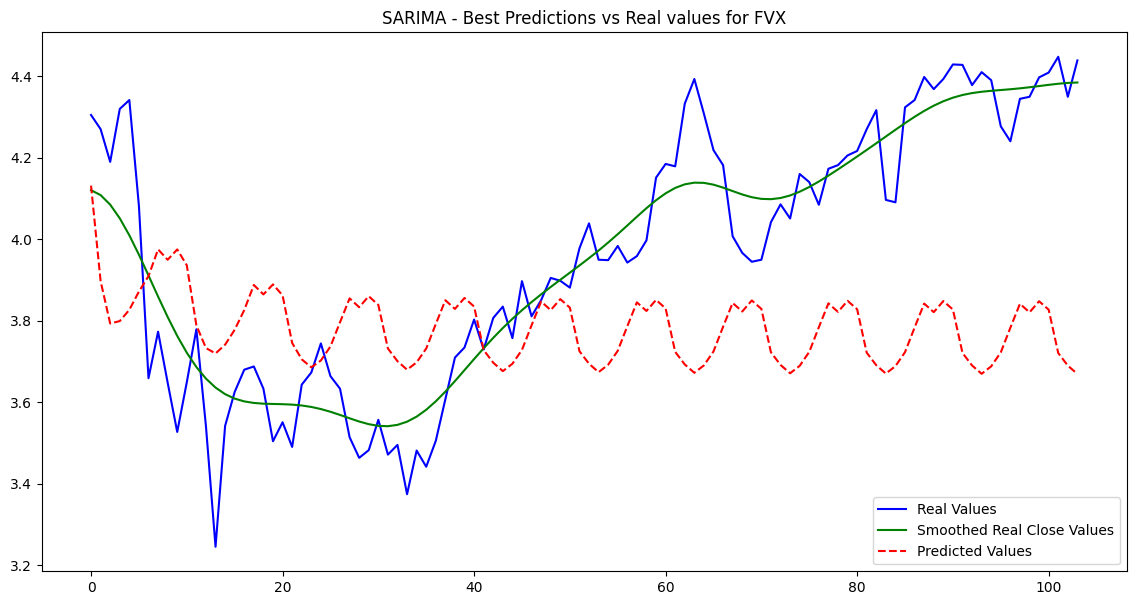

[I 2023-09-20 14:35:52,922] A new study created in memory with name: no-name-c9c6e839-a808-4410-9024-8600d5a1093a


Feature: FVX - Best RMSE: 0.09896000834604965


[I 2023-09-20 14:35:56,879] Trial 0 finished with value: 1.907106021516616 and parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 3, 'D': 0, 'Q': 4, 's': 3}. Best is trial 0 with value: 1.907106021516616.
[I 2023-09-20 14:36:29,417] Trial 1 finished with value: 2.222105519851103 and parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 3, 's': 9}. Best is trial 0 with value: 1.907106021516616.
[I 2023-09-20 14:36:29,417] Trial 2 finished with value: inf and parameters: {'p': 1, 'd': 1, 'q': 3, 'P': 1, 'D': 0, 'Q': 3, 's': 5}. Best is trial 0 with value: 1.907106021516616.
[I 2023-09-20 14:36:31,992] Trial 3 finished with value: 1.9064735414798653 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 5, 'D': 0, 'Q': 1, 's': 3}. Best is trial 3 with value: 1.9064735414798653.
[I 2023-09-20 14:36:47,915] Trial 4 finished with value: inf and parameters: {'p': 5, 'd': 1, 'q': 3, 'P': 0, 'D': 1, 'Q': 2, 's': 5}. Best is trial 3 with value: 1.9064735414798653.
[I 2023-09-20 14:36:47,915] Trial 5 finished 

[I 2023-09-20 14:42:11,577] Trial 40 finished with value: 1.8366483780485063 and parameters: {'p': 5, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 2, 's': 4}. Best is trial 38 with value: 1.7268353651092259.
[I 2023-09-20 14:42:11,593] Trial 41 finished with value: inf and parameters: {'p': 5, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 2, 's': 5}. Best is trial 38 with value: 1.7268353651092259.
[I 2023-09-20 14:42:20,841] Trial 42 finished with value: 1.76273062834317 and parameters: {'p': 5, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 3, 's': 7}. Best is trial 38 with value: 1.7268353651092259.
[I 2023-09-20 14:42:27,408] Trial 43 finished with value: 1.7886238909618393 and parameters: {'p': 5, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 3, 's': 7}. Best is trial 38 with value: 1.7268353651092259.
[I 2023-09-20 14:42:32,614] Trial 44 finished with value: 1.7781070715430707 and parameters: {'p': 4, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 3, 's': 6}. Best is trial 38 with value: 1.7268353651092259.
[I 2023-09-20 14:

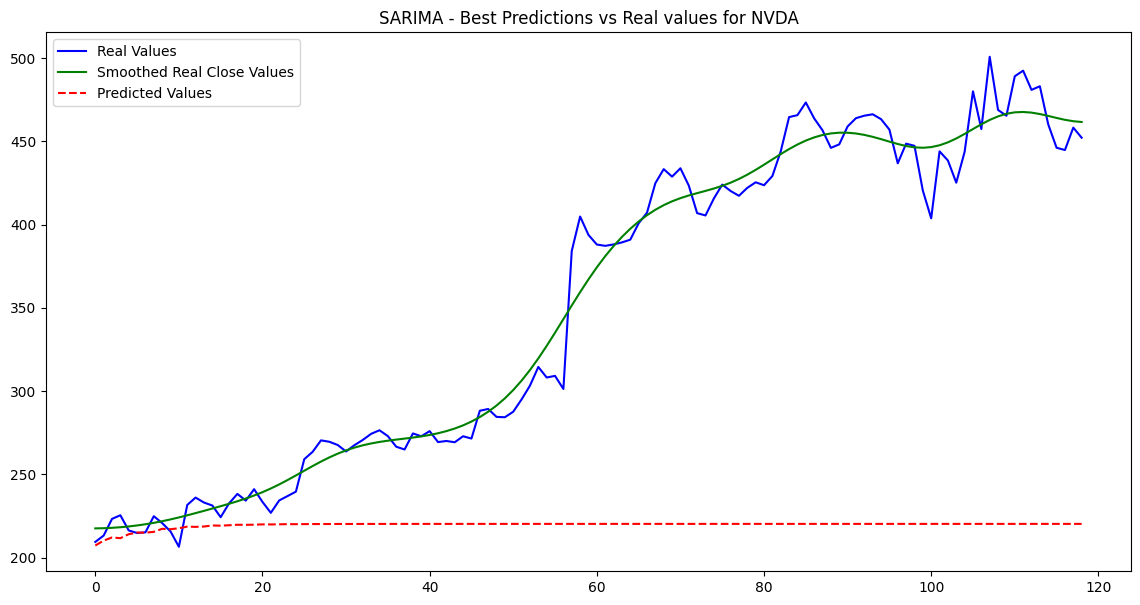

Feature: NVDA - Best RMSE: 1.7268353651092259
Entraînement des modèles SARIMA terminé.


In [20]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", "Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", "Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
# Dictionnaires pour stocker les modèles SARIMA et leurs performances
sarima_models = {}
mse_sarima = {}
recursive_preds_sarima = {}

for index_name in final_df.columns.get_level_values(0).unique():
    def objective_sarima(trial):
        # Paramètres à optimiser
        p = trial.suggest_int('p', 0, 5)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 4)
        P = trial.suggest_int('P', 0, 5)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 4)
        s = trial.suggest_int('s', 2, 12)  # saisonnalité

        # Validation des hyperparamètres
        if p == P:
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

        try:
            # Création du modèle SARIMA
            sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima.fit(disp=False, maxiter=300, method='bfgs')

            # Prédictions
            predictions = sarima_fit.forecast(steps=len(y_test))
            
            if not adf_test(predictions):
                return float('inf')  # Rejeter le modèle si les prédictions sont stationnaires
            
            smoothed_values_test = gaussian_filter1d(y_test, sigma)

            # Calcul de la RMSE
            rmse = weighted_rmse(smoothed_values_test, predictions, len(smoothed_values_test))

            return rmse

        except Exception as e:  # Attrape toutes les exceptions, y compris les problèmes de convergence ou les erreurs de spécification du modèle
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    
    # Création d'une étude Optuna
    study_sarima = optuna.create_study(direction='minimize')
    study_sarima.optimize(objective_sarima, n_trials=50)
    
    best_params = study_sarima.best_params
    best_rmse = study_sarima.best_value

    # Modèle SARIMA avec les meilleurs hyperparamètres
    best_model = SARIMAX(y_train, 
                          order=(best_params['p'], best_params['d'], best_params['q']), 
                          seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
    best_model_fit = best_model.fit(disp=False, maxiter=200, method='bfgs')
    
    # Meilleures prédictions
    best_predictions = best_model_fit.forecast(steps=len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
        
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(best_predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        
        # Affichage des graphiques
        plt.figure(figsize=(14,7))
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')
        plt.title(f"SARIMA - Best Predictions vs Real values for {index_name}")
        plt.legend()
        plt.show()

        # Stocker le modèle et sa performance
        sarima_models[scaler_key] = best_model
        mse_sarima[scaler_key] = best_rmse
        recursive_preds_sarima[scaler_key] = inverse_predictions

        print(f"Feature: {index_name} - Best RMSE: {best_rmse}")
        
print("Entraînement des modèles SARIMA terminé.")

### Choix du modèle par features

In [21]:
features_choice_df = pd.DataFrame({"GRU": mse_gru, "XGBoost": mse_xgb, "SARIMA" : mse_sarima})

best_model_per_feature = features_choice_df.idxmin(axis=1).to_frame(name='Best Model')
best_model_per_feature['MSE'] = features_choice_df.min(axis=1)


print(best_model_per_feature)

           Best Model       MSE
VIX  Close     SARIMA  0.139826
FVX  Close     SARIMA  0.098960
NVDA Close        GRU  1.214881


### Filtrage : comparaison avec un modèle naif

Ce n'est parce que un modèle est meilleurs que les autres qu'il est réellement pertinant, la comparaison avec un modèle naif/simpliste indiquera si le modèle est réelement performant (et pas seulement par rapport aux autres)

In [22]:
# Créer un dictionnaire avec les données de test pour chaque feature
test_data_dict = {}
for feature in scaled_data_df.columns:
    test_data_dict[feature] = test_data[feature]
    
# Dictionnaire pour regrouper toutes les prédictions récursives
all_recursive_preds = {
    'GRU': recursive_preds_gru,
    'XGBoost': recursive_preds_xgb,
    'SARIMA': recursive_preds_sarima
}

def naive_recursive_forecast(series, steps):
    """Génère des prédictions récursives en utilisant la dernière valeur connue pour `steps` prédictions."""
    predictions = [series[-1]]  # on commence avec la dernière observation
    for _ in range(steps-1):
        predictions.append(predictions[-1])
    return np.array(predictions)

mse_naive_recursive_dict = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    actual_values = data.values[1:]
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))
    mse_naive_recursive = mean_squared_error(actual_values, naive_predictions)
    mse_naive_recursive_dict[index_name] = mse_naive_recursive
    
    # Récupérer les valeurs réelles, les prédictions du modèle et les prédictions naïves
    best_model_name = best_model_per_feature.loc[(index_name, 'Close'), 'Best Model']
    best_model_predictions = all_recursive_preds[best_model_name][index_name, 'Close']
    
    actual_values = data.values
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))

# Comparer les MSE des modèles et des prévisions naïves récursives
comparison_recursive_dict = {}
for feature, row in best_model_per_feature.iterrows():
    comparison_recursive_dict[feature] = {
        'Model MSE': row['MSE'],
        'Naive Recursive MSE': mse_naive_recursive_dict[index_name],
        'Model is Better': row['MSE'] < mse_naive_recursive_dict[index_name]
    }

comparison_recursive_dict

{('VIX', 'Close'): {'Model MSE': 0.13982604779927027,
  'Naive Recursive MSE': 63.44466551876942,
  'Model is Better': True},
 ('FVX', 'Close'): {'Model MSE': 0.09896000834604965,
  'Naive Recursive MSE': 63.44466551876942,
  'Model is Better': True},
 ('NVDA', 'Close'): {'Model MSE': 1.2148813884070129,
  'Naive Recursive MSE': 63.44466551876942,
  'Model is Better': True}}

### Conclusion sur les features finales

In [23]:
# Vérifier pour quelles features le modèle naïf est meilleur
naive_better_features = [feature for feature, values in comparison_recursive_dict.items() if not values['Model is Better']]

# Afficher un message d'avertissement pour ces features
if naive_better_features:
    print("Avertissement : Pour les features suivantes, le modèle naïf a performé mieux que le modèle choisi :")
    for feature in naive_better_features:
        print(f"- {feature}")

# Modèle final : basé sur les précédentes features

#### Préparation des données

In [24]:
final_features  = []
for model_type in all_recursive_preds:
    for feature in comparison_recursive_dict:
        print("for : " + str(feature) + "/" + str(model_type) + ":" + str(all_recursive_preds[model_type][feature][0]))
        
for feature in comparison_recursive_dict:
    final_features.append(feature)

# Initialiser le dictionnaire pour stocker les scalers pour chaque feature
final_scalers = {}
print(final_features)
# Mettre à l'échelle les données pour chaque feature
final_features_with_sp500 = final_features + [('GSPC', 'Open')] + [('GSPC', 'Close')]
final_combined_data = combined_data[final_features_with_sp500].copy()

print("Combined data shape:", combined_data.shape)

for feature in final_features:
    scaler = MinMaxScaler()
    final_combined_data[feature] = scaler.fit_transform(final_combined_data[feature].values.reshape(-1, 1))
    final_scalers[feature] = scaler

# Mettre à l'échelle le SP500
sp500_scaler = RobustScaler()
final_combined_data[('GSPC', 'Open')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Open')].values.reshape(-1, 1))
final_combined_data[('GSPC', 'Close')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Close')].values.reshape(-1, 1))

final_combined_data.tail()

for : ('VIX', 'Close')/GRU:18.925804
for : ('FVX', 'Close')/GRU:3.1589434
for : ('NVDA', 'Close')/GRU:195.71416
for : ('VIX', 'Close')/XGBoost:[21.002235]
for : ('FVX', 'Close')/XGBoost:[4.2604957]
for : ('NVDA', 'Close')/XGBoost:[206.62352]
for : ('VIX', 'Close')/SARIMA:[21.5970278]
for : ('FVX', 'Close')/SARIMA:[4.13156516]
for : ('NVDA', 'Close')/SARIMA:[207.24504081]
[('VIX', 'Close'), ('FVX', 'Close'), ('NVDA', 'Close')]
Combined data shape: (3670, 140)


VIX       FVX      NVDA      GSPC          
               Close     Close     Close      Open     Close
Date                                                        
2023-09-11  0.064653  0.838434  0.915233  1.748817  1.753573
2023-09-12  0.070723  0.837639  0.908983  1.743742  1.736751
2023-09-13  0.060136  0.833863  0.921463  1.736751  1.740397
2023-09-14  0.050819  0.839428  0.923412  1.753293  1.765183
2023-09-15  0.064512  0.846184  0.889298  1.760007  1.729130

# Etudes des paramètres optimaux du modèle final

In [52]:
early_stopping = EarlyStopping(monitor='val_mean_directional_accuracy', mode='max', patience=10, restore_best_weights=True)

def mean_directional_accuracy(y_true, y_pred):
    # Obtenir la forme du tenseur y_true (ou y_pred, ils ont la même forme)
    y_shape = K.shape(y_true)

    # Calculer le nombre d'échantillons dans ce lot
    batch_size = y_shape[0]

    # Calculer le nombre de blocs de 10 que nous pouvons avoir
    num_blocks = batch_size // 10

    # Calculer le nombre d'échantillons à garder pour avoir un multiple de 10
    keep_samples = num_blocks * 10

    # Tronquer les tenseurs pour avoir un multiple de 10
    y_true = y_true[:keep_samples]
    y_pred = y_pred[:keep_samples]

    # Si keep_samples est 0, retourner 0 comme métrique
    if keep_samples == 0:
        return K.constant(0, dtype='float32')

    # Réorganiser en blocs de 10
    y_true_reshaped = K.reshape(y_true, (-1, 10))
    y_pred_reshaped = K.reshape(y_pred, (-1, 10))

    # Calculer la différence entre le premier et le dernier élément de chaque bloc
    true_diff = y_true_reshaped[:, -1] - y_true_reshaped[:, 0]
    pred_diff = y_pred_reshaped[:, -1] - y_pred_reshaped[:, 0]

    # Comparer les signes
    matches = K.equal(K.sign(true_diff), K.sign(pred_diff))

    # Calculer la précision directionnelle moyenne
    accuracy = K.mean(K.cast(matches, dtype='float32'))

    return accuracy

def create_sequences(data, look_back=100):
    X, y = [], []
    total_data_points = len(data) // 2 * 2  # Pour s'assurer que nous avons un nombre pair de jours à considérer
    
    for i in range(look_back, total_data_points - 1, 1):  # On avance de un en un pour prendre en compte chaque jour
        sequence_data_open = []
        sequence_data_close = []

        # Ajouter les valeurs d'ouverture et de clôture, alternées
        for j in range(i - look_back, i):
            sequence_data_open.append([data[j, -2]])  # Valeur d'ouverture
            sequence_data_close.append([data[j, -1]])  # Valeur de clôture

        # Séquence pour les autres features
        other_features_seq = data[i - look_back:i, :-2]

        # Double chaque valeur de clôture prédite pour les autres features
        other_features_seq_doubled_open = np.repeat(other_features_seq, 1, axis=0)
        other_features_seq_doubled_close = np.repeat(other_features_seq, 1, axis=0)

        # Combinez les séquences
        combined_seq_open = np.hstack([other_features_seq_doubled_open, sequence_data_open])
        combined_seq_close = np.hstack([other_features_seq_doubled_close, sequence_data_close])

        X.append(combined_seq_open)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i, -1])  # Clôture du jour i

        X.append(combined_seq_close)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i + 1, -2])  # Ouverture du jour i+1

    return np.array(X), np.array(y)

def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_directional_accuracy])
    return model

# Fonction pour réaliser une prédiction récursive avec le modèle final
def recursive_prediction_final_model(model, initial_input, steps, best_model_per_feature, final_scalers, look_back):
    recursive_predictions = []
    current_input = initial_input.copy()

    for step in range(steps):
        # Utilisez les X derniers jours (qu'ils soient réels ou prédits) pour faire la prédiction
        input_for_prediction = current_input[-look_back:]
        
        # Prédire la prochaine valeur du SP500 en utilisant le modèle final
        predicted_sp500_values = model.predict(input_for_prediction.reshape(1, look_back, input_for_prediction.shape[1]), verbose=0)
        recursive_predictions.append(predicted_sp500_values)

        # Mettez à jour l'entrée pour la prochaine prédiction en utilisant les meilleurs modèles pour chaque caractéristique
        new_input_row = []
        for feature in final_features:
            model_type = best_model_per_feature['Best Model'][feature]
            predicted_feature_value = all_recursive_preds[model_type][feature][step//2]

            # Mettez à l'échelle la caractéristique prédite
            scaled_feature_prediction = final_scalers[feature].transform(np.array(predicted_feature_value).reshape(-1, 1))
            new_input_row.append(scaled_feature_prediction[0][0])

        # Utilisez deux fois la valeur de clôture prédite pour les autres indices comme entrée
        #new_input_row = [item for item in new_input_row for _ in range(2)]

        # Ajouter les valeurs prédites ajustées pour le S&P 500
        new_input_row.append(predicted_sp500_values[0, 0])

        # Mettez à jour l'entrée pour la prochaine prédiction
        current_input = np.vstack([current_input[1:], np.array(new_input_row)])

    return np.array(recursive_predictions)

def objective(trial):

    # Espace de recherche
    ###############################################################################################
    look_back = trial.suggest_int('look_back', int(test_size/3), int(test_size/2) - 1)
    num_layers = trial.suggest_int('num_layers', 3, 9)
    layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
    units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
    units_per_layer = [2 ** power for power in units_per_layer]
    dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
    use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
    attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
    use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
    if use_conv1d:
        conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
        conv1d_filters = 2 ** conv1d_filters
        conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    ################################################################################################
    
    # Créez des séquences en utilisant look_back
    X_train, y_train = create_sequences(final_combined_data.iloc[:train_size].values, look_back)
    X_test, y_test = create_sequences(final_combined_data.iloc[train_size:].values, look_back)
    
    n_splits = 5  # Nombre de splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        if use_conv1d:
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
        else:
            conv1d_filters = 36
            conv1d_kernel_size = 5
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

        recursive_predictions = []
        
        input_sequence = X_val_fold[0].reshape(1, look_back, len(reduced_df.columns) + 1)

        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=15, batch_size=32, verbose=0, callbacks=[early_stopping])
        
        # Obtenez la val_loss du dernier epoch
        last_val_loss = history.history['val_loss'][-1]
        val_loss_list.append(last_val_loss)
    
    mean_val_loss = np.mean(val_loss_list)  # Moyenne des val_loss sur tous les plis
    
    initial_input = X_val_fold[0]
    recursive_predictions = recursive_prediction_final_model(model, initial_input, look_back, best_model_per_feature, final_scalers, look_back) #prédictions que sur le dernier pli
    if not adf_test(recursive_predictions[:, 0][:, 0]):
        return float('inf')  # Rejeter le modèle si les prédictions sont stationnaires
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_final = study.best_params
top_5_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

# Affichage des résultats
print('Number of finished trials: ', len(study.trials))
for i, trial in enumerate(top_5_trials):
    print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2023-09-21 21:46:51,913] A new study created in memory with name: no-name-229cd73a-63a1-48e3-b824-40d0f09bb271
[I 2023-09-21 21:56:26,694] Trial 0 finished with value: 3.358732795715332 and parameters: {'look_back': 73, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'dropout_0': 0.22131676338333647, 'dropout_1': 0.2303800747746968, 'dropout_2': 0.19628729152158853, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 5, 'l1_reg': 0.017601762270333707, 'l2_reg': 0.030316449452104384}. Best is trial 0 with value: 3.358732795715332.
[I 2023-09-21 22:07:28,060] Trial 1 finished with value: 1.2065063953399657 and parameters: {'look_back': 69, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 8, 'dropout_0': 0.24350577507171267

[I 2023-09-22 01:16:48,709] Trial 10 finished with value: 0.3157904140651226 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.17643130363901344, 'dropout_1': 0.2986237919693142, 'dropout_2': 0.10738339940499843, 'dropout_3': 0.29950635195278474, 'dropout_4': 0.12244719129266184, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 1.2260854449549495e-05, 'l2_reg': 0.009446027478776623}. Best is trial 6 with value: 0.08599650990217925.
[I 2023-09-22 01:33:24,588] Trial 11 finished with value: 0.5908891495317221 and parameters: {'look_back': 99, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4'

[I 2023-09-22 04:16:10,173] Trial 22 finished with value: 0.06931634992361069 and parameters: {'look_back': 86, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'dropout_0': 0.19336738099745887, 'dropout_1': 0.12211930822241737, 'dropout_2': 0.1539800362615173, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.00029721684350889717, 'l2_reg': 0.03526565273919606}. Best is trial 17 with value: 0.010223802458494902.
[I 2023-09-22 04:32:49,981] Trial 23 finished with value: 0.06843323288485408 and parameters: {'look_back': 80, 'num_layers': 4, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'dropout_0': 0.19493363494857727, 'dropout_1': 0.10114401253618313, 'dropout_2': 0.12417839

[I 2023-09-22 07:27:17,994] Trial 36 finished with value: inf and parameters: {'look_back': 95, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.17866185491722, 'dropout_1': 0.17533960293975243, 'dropout_2': 0.1797493862555963, 'dropout_3': 0.14280635611241527, 'dropout_4': 0.21404655885651813, 'dropout_5': 0.10715862668628696, 'dropout_6': 0.10117670464781985, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 2.9193620605894308e-05, 'l2_reg': 0.054300684257866154}. Best is trial 33 with value: 0.01000875923782587.
[I 2023-09-22 07:44:17,257] Trial 37 finished with value: inf and parameters: {'look_back': 97, 'num_lay

[I 2023-09-22 10:33:57,747] Trial 48 finished with value: 0.0805507529526949 and parameters: {'look_back': 70, 'num_layers': 4, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'dropout_0': 0.20158405523623696, 'dropout_1': 0.17172506865651602, 'dropout_2': 0.13153359517091506, 'dropout_3': 0.15967196934892858, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 1.869564918155565e-05, 'l2_reg': 0.0010535913056776095}. Best is trial 44 with value: 0.008970312681049109.
[I 2023-09-22 10:42:55,336] Trial 49 finished with value: 5.0160438136197625 and parameters: {'look_back': 74, 'num_layers': 3, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'dropout_0': 0.22058663327959463, 'dropout_1': 0.16172150

Number of finished trials:  50
Rank 1 - Value: 0.008970312681049109, Params: {'look_back': 69, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'dropout_0': 0.20752394667837853, 'dropout_1': 0.12292180797367502, 'dropout_2': 0.11849371838389214, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 1.516042153553812e-05, 'l2_reg': 0.03128850446345891}
Rank 2 - Value: 0.01000875923782587, Params: {'look_back': 91, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'dropout_0': 0.18339735001933138, 'dropout_1': 0.15404592566154876, 'dropout_2': 0.1590647053207016, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 2.680687900495

#### Création du modèle

Epoch 1/1000
213/213 [==============================] - 24s 84ms/step - loss: 9.4526 - mean_directional_accuracy: 0.9624 - val_loss: 0.0881 - val_mean_directional_accuracy: 0.4074
Epoch 2/1000
213/213 [==============================] - 16s 73ms/step - loss: 0.0325 - mean_directional_accuracy: 0.9703 - val_loss: 0.0183 - val_mean_directional_accuracy: 0.4444
Epoch 3/1000
213/213 [==============================] - 15s 69ms/step - loss: 0.0097 - mean_directional_accuracy: 0.9765 - val_loss: 0.0061 - val_mean_directional_accuracy: 0.4815
Epoch 4/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0064 - mean_directional_accuracy: 0.9844 - val_loss: 0.0062 - val_mean_directional_accuracy: 0.4815
Epoch 5/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9765 - val_loss: 0.0090 - val_mean_directional_accuracy: 0.5185
Epoch 6/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0054 - mean_directio

213/213 [==============================] - 14s 66ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9812 - val_loss: 0.0099 - val_mean_directional_accuracy: 0.6296
Epoch 47/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0059 - mean_directional_accuracy: 0.9765 - val_loss: 0.0075 - val_mean_directional_accuracy: 0.6296
Epoch 48/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9859 - val_loss: 0.0073 - val_mean_directional_accuracy: 0.6296
Epoch 49/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0055 - mean_directional_accuracy: 0.9765 - val_loss: 0.0226 - val_mean_directional_accuracy: 0.5926
Epoch 50/1000
213/213 [==============================] - 15s 68ms/step - loss: 0.0055 - mean_directional_accuracy: 0.9875 - val_loss: 0.0099 - val_mean_directional_accuracy: 0.6296
Epoch 51/1000
213/213 [==============================] - 15s 70ms/step - loss: 0.0056 - mean_directional_accu

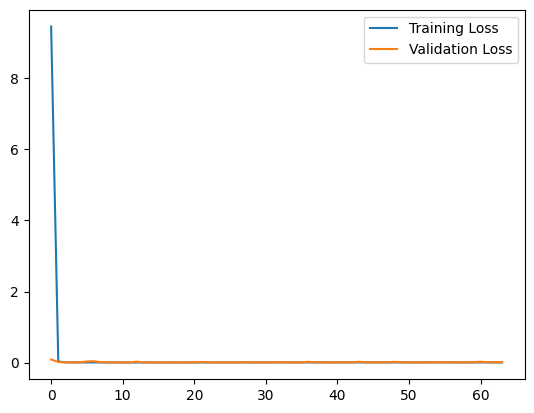

Epoch 1/1000
213/213 [==============================] - 21s 70ms/step - loss: 8.4950 - mean_directional_accuracy: 0.9687 - val_loss: 0.0382 - val_mean_directional_accuracy: 0.3704
Epoch 2/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0098 - mean_directional_accuracy: 0.9687 - val_loss: 0.0786 - val_mean_directional_accuracy: 0.4815
Epoch 3/1000
213/213 [==============================] - 15s 70ms/step - loss: 0.0068 - mean_directional_accuracy: 0.9859 - val_loss: 0.0115 - val_mean_directional_accuracy: 0.5185
Epoch 4/1000
213/213 [==============================] - 15s 71ms/step - loss: 0.0054 - mean_directional_accuracy: 0.9734 - val_loss: 0.0099 - val_mean_directional_accuracy: 0.4815
Epoch 5/1000
213/213 [==============================] - 15s 72ms/step - loss: 0.0051 - mean_directional_accuracy: 0.9765 - val_loss: 0.0055 - val_mean_directional_accuracy: 0.5556
Epoch 6/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0067 - mean_directio

213/213 [==============================] - 14s 65ms/step - loss: 0.0058 - mean_directional_accuracy: 0.9828 - val_loss: 0.0077 - val_mean_directional_accuracy: 0.6296
Epoch 47/1000
213/213 [==============================] - 13s 63ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9765 - val_loss: 0.0157 - val_mean_directional_accuracy: 0.5926
Epoch 48/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0058 - mean_directional_accuracy: 0.9844 - val_loss: 0.0073 - val_mean_directional_accuracy: 0.5556
Epoch 49/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9844 - val_loss: 0.0120 - val_mean_directional_accuracy: 0.5926
Epoch 50/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9750 - val_loss: 0.0091 - val_mean_directional_accuracy: 0.5926
Epoch 51/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0053 - mean_directional_accu

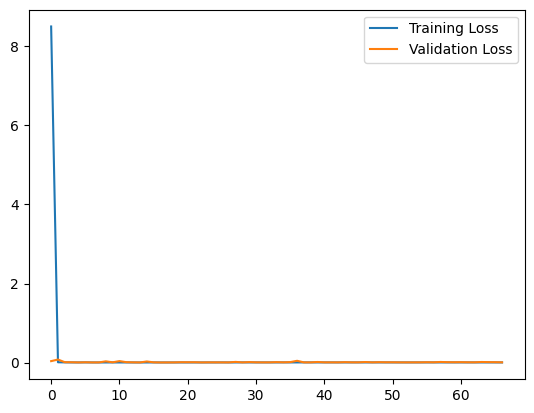

Epoch 1/1000
213/213 [==============================] - 21s 74ms/step - loss: 8.7453 - mean_directional_accuracy: 0.9577 - val_loss: 0.0293 - val_mean_directional_accuracy: 0.4074
Epoch 2/1000
213/213 [==============================] - 15s 72ms/step - loss: 0.0107 - mean_directional_accuracy: 0.9750 - val_loss: 0.0095 - val_mean_directional_accuracy: 0.4444
Epoch 3/1000
213/213 [==============================] - 15s 71ms/step - loss: 0.0063 - mean_directional_accuracy: 0.9734 - val_loss: 0.0234 - val_mean_directional_accuracy: 0.5185
Epoch 4/1000
213/213 [==============================] - 15s 69ms/step - loss: 0.0071 - mean_directional_accuracy: 0.9875 - val_loss: 0.0237 - val_mean_directional_accuracy: 0.5185
Epoch 5/1000
213/213 [==============================] - 15s 70ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9906 - val_loss: 0.0160 - val_mean_directional_accuracy: 0.5556
Epoch 6/1000
213/213 [==============================] - 15s 69ms/step - loss: 0.0052 - mean_directio

213/213 [==============================] - 14s 64ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9797 - val_loss: 0.0071 - val_mean_directional_accuracy: 0.5556
Epoch 47/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9546 - val_loss: 0.0126 - val_mean_directional_accuracy: 0.5926
Epoch 48/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0054 - mean_directional_accuracy: 0.9781 - val_loss: 0.0068 - val_mean_directional_accuracy: 0.5926
Epoch 49/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9797 - val_loss: 0.0071 - val_mean_directional_accuracy: 0.5556
Epoch 50/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0058 - mean_directional_accuracy: 0.9812 - val_loss: 0.0149 - val_mean_directional_accuracy: 0.5926
Epoch 51/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0056 - mean_directional_accu

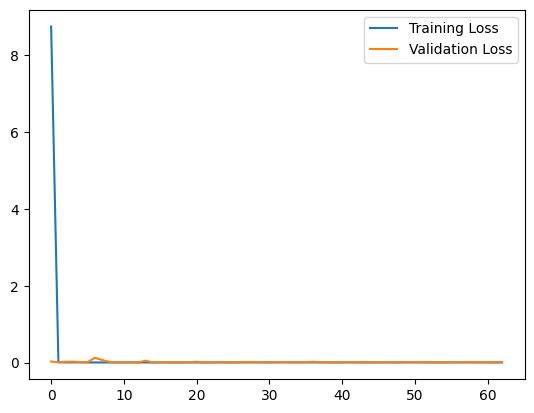

Epoch 1/1000
213/213 [==============================] - 24s 72ms/step - loss: 8.6471 - mean_directional_accuracy: 0.9624 - val_loss: 0.1661 - val_mean_directional_accuracy: 0.4444
Epoch 2/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0116 - mean_directional_accuracy: 0.9640 - val_loss: 0.0144 - val_mean_directional_accuracy: 0.4444
Epoch 3/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0075 - mean_directional_accuracy: 0.9765 - val_loss: 0.0293 - val_mean_directional_accuracy: 0.5556
Epoch 4/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0060 - mean_directional_accuracy: 0.9844 - val_loss: 0.0042 - val_mean_directional_accuracy: 0.5556
Epoch 5/1000
213/213 [==============================] - 15s 72ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9812 - val_loss: 0.0053 - val_mean_directional_accuracy: 0.5556
Epoch 6/1000
213/213 [==============================] - 15s 72ms/step - loss: 0.0046 - mean_directio

213/213 [==============================] - 14s 65ms/step - loss: 0.0058 - mean_directional_accuracy: 0.9890 - val_loss: 0.0115 - val_mean_directional_accuracy: 0.6296
Epoch 47/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0059 - mean_directional_accuracy: 0.9844 - val_loss: 0.0079 - val_mean_directional_accuracy: 0.5185
Epoch 48/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9750 - val_loss: 0.0083 - val_mean_directional_accuracy: 0.5556
Epoch 49/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0054 - mean_directional_accuracy: 0.9828 - val_loss: 0.0103 - val_mean_directional_accuracy: 0.5926
Epoch 50/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0887 - mean_directional_accuracy: 0.9797 - val_loss: 0.0119 - val_mean_directional_accuracy: 0.6296
Epoch 51/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0061 - mean_directional_accu

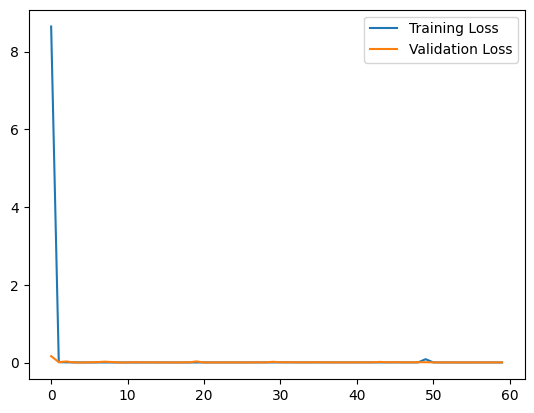

Epoch 1/1000
213/213 [==============================] - 22s 74ms/step - loss: 8.3360 - mean_directional_accuracy: 0.9640 - val_loss: 0.0142 - val_mean_directional_accuracy: 0.4444
Epoch 2/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.0107 - mean_directional_accuracy: 0.9812 - val_loss: 0.0166 - val_mean_directional_accuracy: 0.4815
Epoch 3/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0062 - mean_directional_accuracy: 0.9781 - val_loss: 0.0257 - val_mean_directional_accuracy: 0.5556
Epoch 4/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0051 - mean_directional_accuracy: 0.9781 - val_loss: 0.0061 - val_mean_directional_accuracy: 0.5556
Epoch 5/1000
213/213 [==============================] - 14s 64ms/step - loss: 0.0058 - mean_directional_accuracy: 0.9781 - val_loss: 0.0460 - val_mean_directional_accuracy: 0.5556
Epoch 6/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0051 - mean_directio

213/213 [==============================] - 17s 79ms/step - loss: 0.0061 - mean_directional_accuracy: 0.9812 - val_loss: 0.0082 - val_mean_directional_accuracy: 0.5556
Epoch 47/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0063 - mean_directional_accuracy: 0.9844 - val_loss: 0.0086 - val_mean_directional_accuracy: 0.5926
Epoch 48/1000
213/213 [==============================] - 14s 68ms/step - loss: 0.0057 - mean_directional_accuracy: 0.9765 - val_loss: 0.0099 - val_mean_directional_accuracy: 0.5556
Epoch 49/1000
213/213 [==============================] - 14s 67ms/step - loss: 0.0056 - mean_directional_accuracy: 0.9828 - val_loss: 0.0083 - val_mean_directional_accuracy: 0.5556
Epoch 50/1000
213/213 [==============================] - 14s 66ms/step - loss: 0.1168 - mean_directional_accuracy: 0.9671 - val_loss: 0.1739 - val_mean_directional_accuracy: 0.5185
Epoch 51/1000
213/213 [==============================] - 14s 65ms/step - loss: 0.0629 - mean_directional_accu

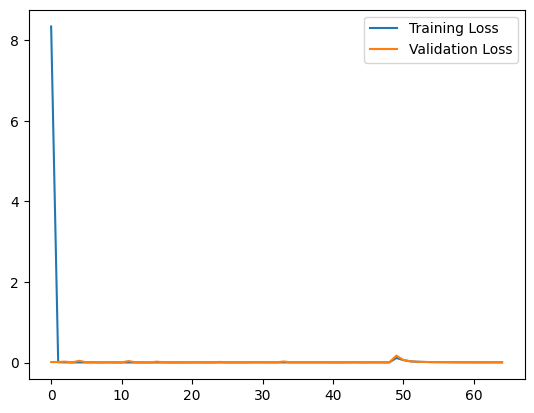

In [53]:
all_predictions = []
final_close_predictions = []
final_models = []
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



for i, trial in enumerate(top_5_trials):
    best_params = trial.params
    
    # Créer le modèle de réseau neuronal
    final_model = create_model(
            num_layers = best_params_final['num_layers'],
            units_per_layer=[2 ** (best_params_final[f'units_power_{i}']) for i in range(int(best_params_final['num_layers']))],
            layer_type=[best_params_final[f'layer_type_{i}'] for i in range(best_params_final['num_layers'])],
            dropout_per_layer=[best_params_final[f'dropout_{i}'] for i in range(best_params_final['num_layers'])],
            input_shape=((best_params_final['look_back']), (len(reduced_df.columns) + 1)),
            use_conv1d=best_params_final['use_conv1d'],
            conv1d_filters=2 ** best_params_final.get('conv1d_filters', 0),
            conv1d_kernel_size=best_params_final.get('conv1d_kernel_size', None),
            use_residual_connection=best_params_final['use_residual_connection'],
            attention_layer=best_params_final['use_attention_layer'],
            l1_reg=best_params_final['l1_reg'],
            l2_reg=best_params_final['l2_reg']
    )
    
    #Création de séquences

    X_train_final, y_train_final = create_sequences(final_combined_data.iloc[:train_size].values, best_params_final['look_back'])
    X_test_final, y_test_final = create_sequences(final_combined_data.iloc[train_size:].values, best_params_final['look_back'])

    history = final_model.fit(
        X_train_final, y_train_final,
        validation_data=(X_test_final, y_test_final),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping]
    )

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()
    
    # Initialiser l'entrée récursive avec les dernières valeurs réelles des caractéristiques filtrées et la valeur du SP500 de la veille
    initial_input_features = final_combined_data[final_features].iloc[-(best_params_final['look_back']):].values
    initial_input_sp500_close = final_combined_data[('GSPC', 'Close')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)
    initial_input_sp500_open = final_combined_data[('GSPC', 'Open')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)

    # Alternance des valeurs 'Close' et 'Open'
    initial_input_sp500 = np.column_stack((initial_input_sp500_close, initial_input_sp500_open)).ravel().reshape(-1, 1)

    # Concaténer les caractéristiques et la valeur du SP500 pour former l'entrée récursive initiale
    initial_input = np.hstack([np.repeat(initial_input_features, 2, axis=0), initial_input_sp500])


    # Effectuer la prédiction récursive avec le modèle final
    last_n_real_values_sp500 = combined_data[('GSPC', 'Close')].iloc[-10-len(y_test_final):].values.flatten()
    predictions = recursive_prediction_final_model(final_model, initial_input, best_params_final['look_back'], best_model_per_feature, final_scalers, best_params_final['look_back'])
    
    # Ne conserver que les prédictions de clôture (positions impaires)
    close_predictions = predictions[1::2]  # Commence à l'index 1 et prend chaque deuxième élément à partir de là
    final_close_predictions.append(close_predictions)
    
    all_predictions.append(predictions)
    final_models.append(final_model)


#### Utiliser la médiane des prédictions

In [54]:
median_predictions = np.median(np.array(final_close_predictions), axis=0)

In [55]:
#Appliquer le filtre gaussien aux données réelles
smoothed_real_values = gaussian_filter1d(real_values, sigma=5)

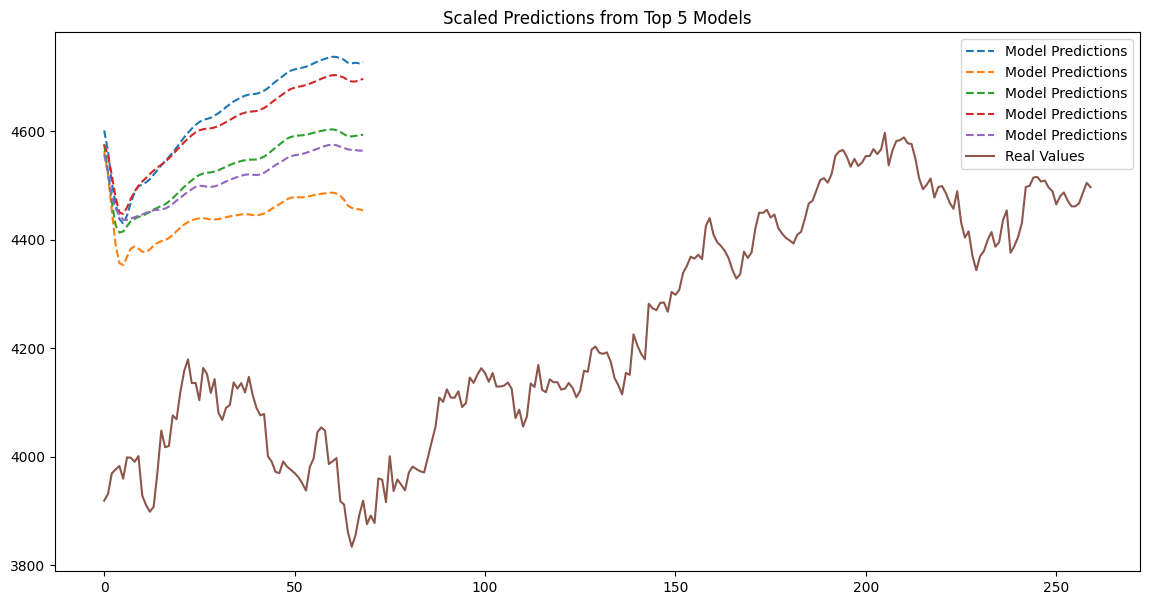

In [56]:
plt.figure(figsize=(14, 7))

for predictions in all_predictions:
    
    predictions_close = predictions[:, 0]
    predictions_close_inverse = sp500_scaler.inverse_transform(predictions_close)
    plt.plot(predictions_close_inverse[:, 0], label='Model Predictions', linestyle='--')

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]
plt.plot(inverse_real_values_close, label='Real Values')
plt.legend()

plt.title('Scaled Predictions from Top 5 Models')

plt.show()


#### Graphique comparatif avec les valeurs réelles

In [57]:
inverse_final_predictions = sp500_scaler.inverse_transform(median_predictions[:,0])

In [58]:
# Afficher les dernières valeurs réelles pour chaque feature (y compris le SP500)
print("Dernières valeurs réelles :")
for feature in final_features:
    real_value = combined_data[feature].iloc[-1-len(y_test)]
    print(f"{feature}: {real_value}")

real_sp500 = combined_data[('GSPC', 'Close')].iloc[-1-len(y_test)]
print(f"GSPC_Close: {real_sp500}")

print("\nPremières valeurs prédites :")
# Afficher les premières valeurs prédites pour chaque feature
for feature in final_features:
    model_type = best_model_per_feature['Best Model'][feature]
    predicted_feature_value = all_recursive_preds[model_type][feature][0]
    # Inversez la mise à l'échelle pour la caractéristique prédite
    print(f"{feature}: {predicted_feature_value}")

# Afficher la première valeur prédite pour le SP500
predicted_sp500_value = median_predictions[0]
inverse_sp500_prediction = sp500_scaler.inverse_transform(np.array(predicted_sp500_value).reshape(-1, 1))
print(f"GSPC_Close (avant correction): {inverse_sp500_prediction[0][0]}")

Dernières valeurs réelles :
('VIX', 'Close'): 18.729999542236328
('FVX', 'Close'): 3.4830000400543213
('NVDA', 'Close'): 217.08999633789062
GSPC_Close: 4179.759765625

Premières valeurs prédites :
('VIX', 'Close'): [21.5970278]
('FVX', 'Close'): [4.13156516]
('NVDA', 'Close'): 195.7141571044922
GSPC_Close (avant correction): 4526.29150390625


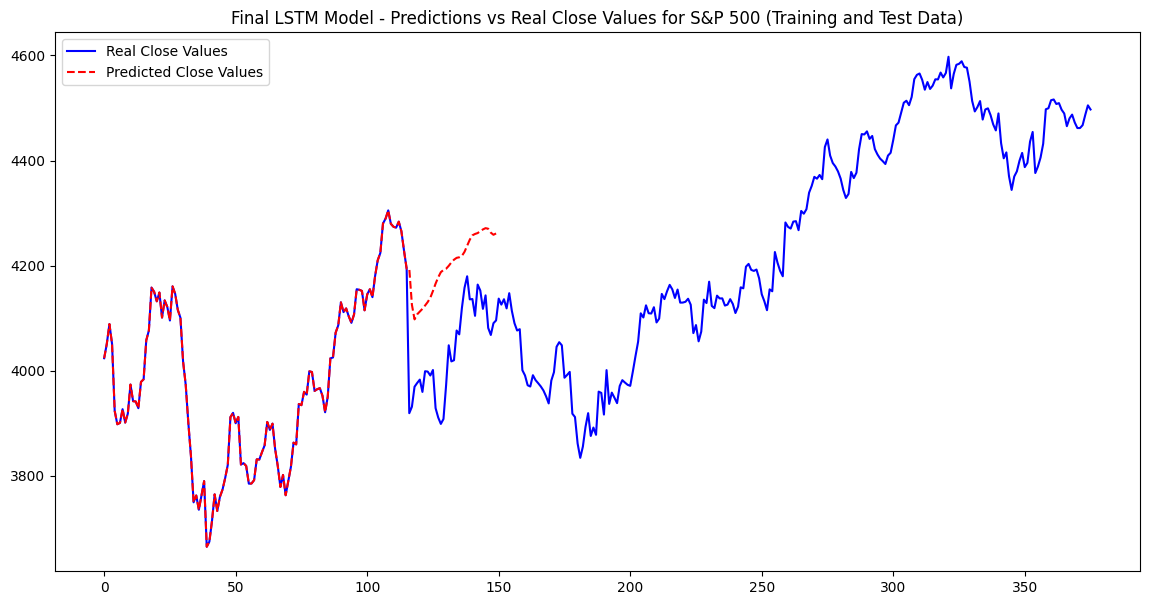

array([4194.2905, 4125.5474, 4097.788 , 4107.3975, 4112.5596, 4117.85  ,
       4124.1313, 4130.785 , 4139.011 , 4151.8223, 4165.794 , 4177.7983,
       4187.6523, 4191.787 , 4194.126 , 4199.676 , 4206.169 , 4211.3574,
       4214.876 , 4215.9814, 4218.4844, 4226.3325, 4238.012 , 4249.4277,
       4257.767 , 4260.336 , 4262.05  , 4265.684 , 4268.978 , 4271.3926,
       4270.2827, 4262.83  , 4258.784 , 4261.316 ], dtype=float32)

In [59]:
inverse_final_predictions_close = inverse_final_predictions[:, 0]
# Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement pour le S&P 500
last_real_values_train_scaled = y_train_final
last_real_values_train = sp500_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1))[:, 0]  # On prend seulement les valeurs de clôture

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
real_values = np.concatenate([last_real_values_train, inverse_real_values_close])


inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
predicted_values = np.concatenate([last_real_values_train, inverse_final_predictions_close])

inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])
plt.figure(figsize=(14,7))

# Tracer les valeurs réelles
plt.plot(real_values[-150 - (len(real_values) - len(predicted_values)):], label='Real Close Values', color='blue')
# Tracer les valeurs prédites
plt.plot(predicted_values[-150:], label='Predicted Close Values', color='red', linestyle='--')

plt.title("Final LSTM Model - Predictions vs Real Close Values for S&P 500 (Training and Test Data)")
plt.legend()
plt.show()

inverse_final_predictions_close

#### Métrique d'évaluation:

In [60]:
min_length = min(len(inverse_real_values_close), len(inverse_final_predictions_close))
mse = mean_squared_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
rmse = np.sqrt(mse)
mae = mean_absolute_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
r2 = r2_score(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])

print(f"Erreur quadratique moyenne MSE: {mse}")
print(f"Racine de l'erreur quadratique moyenne RMSE: {rmse}")
print(f"Erreur absolue moyenne MAE: {mae}")
print(f"Coefficient de détermination R²: {r2}")

Erreur quadratique moyenne MSE: 29491.006691685026
Racine de l'erreur quadratique moyenne RMSE: 171.72945784484685
Erreur absolue moyenne MAE: 162.02190680459407
Coefficient de détermination R²: -3.1501982066542737


# Simulation Gain/Perte (ajouter méchanisme d'anticipation)

In [61]:
def simulate_trading_strategy(predictions, actual_prices, min_yield=0.000117, stop_loss=0.05, take_profit=0.05, transaction_fee=0.001):
    capital = 150
    realized_gain = [0]  # Gain that is realized by selling
    stock_quantity = 0  # Number of stocks owned
    capital_over_time = [capital]  # Track capital over time
    realized_gain_over_time = [realized_gain]  # Track realized gain over time

    # Initialize the last price as the first actual price
    last_price = actual_prices[0]


    for i in range(1, len(predictions)):
        
        # Only execute trading actions every 5 days
        if i % 5 != 0:
            continue

        pred_today = predictions[i]
        pred_yesterday = predictions[i - 5]
        actual_today = actual_prices[i]
        actual_yesterday = actual_prices[i - 5]
        expected_return = (pred_today - pred_yesterday) / pred_yesterday
        actual_return = (actual_today - actual_yesterday) / actual_yesterday

        # If both predicted and actual trends are upward, increase confidence
        if expected_return > min_yield and actual_return > min_yield:
            confidence_factor = 1.2
        else:
            confidence_factor = 1.0

        # Implementing Dynamic Stop-Loss and Take-Profit
        dynamic_stop_loss = stop_loss * confidence_factor
        dynamic_take_profit = take_profit * confidence_factor


        # Implementing Take-Profit and Stop-Loss

        if stock_quantity > 0:
            gain_loss = (actual_today - last_price) / last_price

            if gain_loss >= dynamic_take_profit:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

            elif gain_loss <= -dynamic_stop_loss:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

        # Implementing the Threshold-based Strategy
        if expected_return > min_yield and capital > 0:
            buy_quantity = capital / actual_today  # Buy as much as possible with available capital
            capital -= buy_quantity * actual_today  # Deduct from capital
            stock_quantity += buy_quantity  # Add to stock quantity
            last_price = actual_today  # Update the last price when a new stock is bought
            print(f"Buy executed on day {i}. New stock quantity : {stock_quantity}")

        # Calculate total capital as liquid capital plus the value of stocks owned
        total_capital = capital + stock_quantity * actual_today
        capital_over_time.append(total_capital[0])
        realized_gain_over_time.append(realized_gain[0])

    strategy_returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]
    return strategy_returns, capital_over_time, realized_gain_over_time


strategy_returns, capital_over_time, realized_gain_over_time = simulate_trading_strategy(inverse_final_predictions_close, inverse_real_values)
realized_gain_over_time[0] = 0

Buy executed on day 10. New stock quantity : [0.03817901]


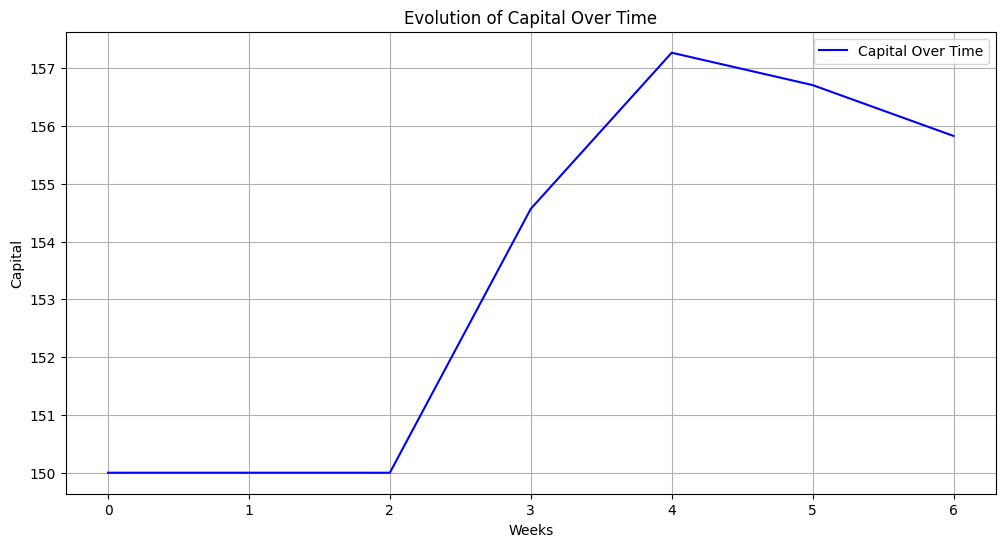

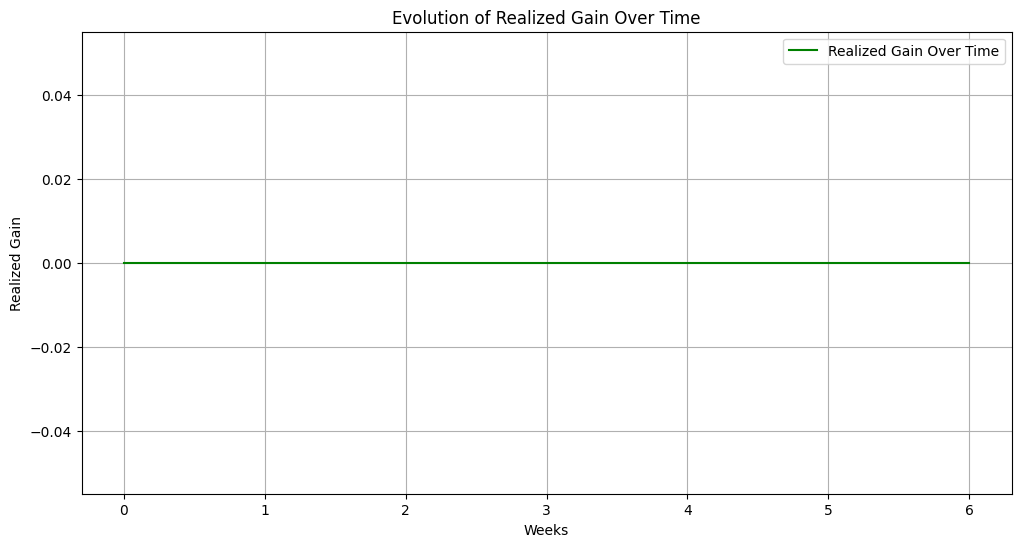

In [62]:
# Generate some sample data for the sake of demonstration
days = list(range(len(capital_over_time)))

# Plotting the evolution of capital over time
plt.figure(figsize=(12, 6))
plt.plot(days, capital_over_time, label="Capital Over Time", color='blue')
plt.xlabel("Weeks")
plt.ylabel("Capital")
plt.title("Evolution of Capital Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the evolution of realized gain over time
plt.figure(figsize=(12, 6))
plt.plot(days, realized_gain_over_time, label="Realized Gain Over Time", color='green')
plt.xlabel("Weeks")
plt.ylabel("Realized Gain")
plt.title("Evolution of Realized Gain Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Calculate the absolute and percentage gain/loss

initial_capital = capital_over_time[0]

final_capital = capital_over_time[-1]



absolute_gain_loss = final_capital - initial_capital

percentage_gain_loss = ((final_capital - initial_capital) / initial_capital) * 100



# Calculate volatility as the standard deviation of the returns

returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]

volatility = np.std(returns)

print(f"Gain/perte absolu sur {len(capital_over_time)*5 -1} jours : {absolute_gain_loss}")
print(f"Gain/perte en % sur {len(capital_over_time)*5 -1} jours : {percentage_gain_loss}")
print(f"Volatilité de l'indice sur {len(capital_over_time)*5 -1} jours : {volatility}")

annualized_return_percentage = ((1 + percentage_gain_loss/100) ** (252 / len(capital_over_time)/5 -1) - 1) * 100

print(f"Taux gain/perte annualisé : {annualized_return_percentage}")

Gain/perte absolu sur 34 jours : 5.827640399684071
Gain/perte en % sur 34 jours : 3.8850935997893807
Volatilité de l'indice sur 34 jours : 0.013077364677778845
Taux gain/perte annualisé : 26.657251524973603


In [64]:
# Calcul du ratio de Sharpe
mean_return = np.mean(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])
sharpe_ratio = mean_return / np.std(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])

print(f"Ratio de Sharpe: {sharpe_ratio}")

Ratio de Sharpe: 0.08202017960276073


## Conclusion

In [66]:
def calculate_directional_accuracy(real_values, predicted_values):
    correct_directions = 0
    total_directions = 0
    
    #fenêtre glissante sur 10 jours (2 semaines, du lundi au vendredi)
    for i in range(0, len(predicted_values), 5): #first cycle of 5 never used
        real_diff = real_values[i] - real_values[i-5]
        predicted_diff = predicted_values[i] - predicted_values[i-5]

        if (real_diff > 0 and predicted_diff > 0) or (real_diff < 0 and predicted_diff < 0):
            correct_directions += 1
        else: 
            print(f"Variation entre n°{i-5} et n°{i} fausse")

        total_directions += 1

    directional_accuracy = (correct_directions / total_directions) * 100
    return directional_accuracy

directional_accuracy = calculate_directional_accuracy(inverse_real_values_close, inverse_final_predictions_close)
print(f"Précision directionnelle sur 1 semaine: {directional_accuracy:.2f}%")

Variation entre n°0 et n°5 fausse
Variation entre n°5 et n°10 fausse
Variation entre n°20 et n°25 fausse
Variation entre n°25 et n°30 fausse
Précision directionnelle sur 1 semaine: 42.86%


Les résultats sont très encourageant, un investissement naif au jour 0 aurait conduit à une perte de capital à j + 50 (34 jours ouvrables, correspondant aux 34 prédictions)

Quelques points et améliorations cepandant à soulever :

- Les prédictions des features autres que la valeur de l'indice lui même ne sont disponibles que pour la valeur de clôture (et pas d'ouverture), la précision pour les modèles des features ainsi que le modèles final peut donc être encore augmenté.


- Toute la partie sur la simulation de gain/perte suppose que ce notebook n'est jamais réexecuté pendant 50 jours/ 34 jours ouvrables, or, dans les faits, prédire à nouveau la valeur de l'indice avec les nouvelles valeurs réelles augmentera les chances de corriger les prédictions directionnelles fausses à plus long terme.


- Les performances passées ne préjugent pas des performances futures, c'est valable pour un fonds investi en actions tout comme les performances de ce notebook, prennez du recul sur les résultats produits par ce dernier s'il a une quelconque influence sur vos investisements.
